# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-28 07:29:28.351455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 07:29:28.601032: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 07:29:28.739672: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 07:29:29.636688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [23]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 256

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [29]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [30]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [31]:
# FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 14
Y_TYPE_DICT["direction_ma_timespan"] = 14
Y_TYPE_DICT["derivation_ma_timespan"] = 14
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 14,
 'direction_ma_timespan': 14,
 'derivation_ma_timespan': 14}

In [32]:
TARGET_FEATURE_CNT = 256

In [33]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(384, 256, 256)

In [34]:
import numpy as np
a = np.array([1,2,3,4])
a[[1,3]]

array([2, 4])

In [35]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
        
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [36]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-03-28 07:29:33.927555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 07:29:34.004052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 07:29:34.004234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 07:29:34.006906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [37]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout

In [38]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBigger",
      "VERSION": "3_FutureOnly",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [39]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBigger_3_FutureOnly_GPU_256LB'

In [40]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-04,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [41]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [42]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [43]:
gc.collect()

9885

In [44]:
epoch_add = 31

In [45]:
CALLBACK_EVERY_N_BATCHES = 2000

In [46]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [47]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [48]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [49]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB20230328-072936'

In [50]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-28 07:29:36.093420: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-28 07:29:36.093443: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-28 07:29:36.094214: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-28 07:29:36.094489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-28 07:29:36.202210: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-28 07:29:36.202456: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [51]:
model.load_weights("/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_end/model.h5")

In [106]:
stop

NameError: name 'stop' is not defined

In [107]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [108]:
# model.fit(tfGenTraining,
#           epochs=1,
#           verbose = 1,
#           callbacks=[tensorboard_callback, cc])

In [109]:
# model.optimizer.learning_rate = 5e-6

In [110]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [111]:
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/3


INFO:root:File 'IE00B6X2VY59.csv' loaded, 531 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 530 left
INFO:root:File 'DE000A0F5UF5.csv' loaded, 529 left
INFO:root:File 'DE000ETFL441.csv' loaded, 528 left
INFO:root:File 'LU1781541179.csv' loaded, 527 left
INFO:root:File 'LU1650487926.csv' loaded, 526 left
INFO:root:File 'LU1285960032.csv' loaded, 525 left
INFO:root:File 'IE00B1FZSD53.csv' loaded, 524 left
INFO:root:File 'IE00B5KQNG97.csv' loaded, 523 left


      4/Unknown - 25s 269ms/step - loss: 0.3000 - mae: 0.0466

2023-03-27 17:09:27.234038: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-27 17:09:27.234070: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 25s 321ms/step - loss: 0.2003 - mae: 0.0355WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1358s vs `on_train_batch_end` time: 0.1370s). Check your callbacks.


INFO:root:File 'IE00BYM31M36.csv' loaded, 522 left


     15/Unknown - 29s 343ms/step - loss: 0.0807 - mae: 0.0205

INFO:root:File 'LU2082996542.csv' loaded, 521 left


     25/Unknown - 32s 327ms/step - loss: 0.1089 - mae: 0.0228

INFO:root:File 'IE00BF4G7076.csv' loaded, 520 left


     34/Unknown - 35s 330ms/step - loss: 0.0935 - mae: 0.0244

INFO:root:File 'IE00BQN1K786.csv' loaded, 519 left


     45/Unknown - 38s 334ms/step - loss: 0.0762 - mae: 0.0250

INFO:root:File 'LU0136240974.csv' loaded, 518 left


     59/Unknown - 44s 355ms/step - loss: 0.0586 - mae: 0.0214

INFO:root:File 'IE00BLDGH447.csv' loaded, 517 left


     61/Unknown - 45s 359ms/step - loss: 0.0575 - mae: 0.0211

INFO:root:File 'IE00BFTWP510.csv' loaded, 516 left


     67/Unknown - 48s 364ms/step - loss: 0.0577 - mae: 0.0215

INFO:root:File 'IE00BQT3WG13.csv' loaded, 515 left


     77/Unknown - 51s 362ms/step - loss: 0.0507 - mae: 0.0200

INFO:root:File 'LU1407888053.csv' loaded, 514 left


     99/Unknown - 58s 352ms/step - loss: 0.0431 - mae: 0.0185

2023-03-27 17:10:01.154664: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-27 17:10:01.159639: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
INFO:root:File 'IE00BMYDM794.csv' loaded, 513 left
2023-03-27 17:10:01.498852: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 585793 callback api events and 588499 activity events. 
INFO:root:File 'IE00B441G979.csv' loaded, 512 left
2023-03-27 17:10:06.812259: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
INFO:root:File 'IE00B8X9NY41.csv' loaded, 511 left
INFO:root:File 'IE00BMDH1538.csv' loaded, 510 left
2023-03-27 17:10:11.421810: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/bigdata/log/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB20230327-170839/plugins/profile/2023_03_27_17_10_06

INFO:root:File 'IE00BLF7VX27.csv' loaded, 509 le

    100/Unknown - 77s 537ms/step - loss: 0.0426 - mae: 0.0183

INFO:root:File 'LU1079842321.csv' loaded, 507 left


    101/Unknown - 78s 542ms/step - loss: 0.0422 - mae: 0.0182

INFO:root:File 'IE00BKVL7778.csv' loaded, 506 left


    105/Unknown - 80s 537ms/step - loss: 0.0406 - mae: 0.0178

INFO:root:File 'LU1681045537.csv' loaded, 505 left


    109/Unknown - 82s 539ms/step - loss: 0.0392 - mae: 0.0175

INFO:root:File 'IE00B60SX287.csv' loaded, 504 left


    125/Unknown - 88s 516ms/step - loss: 0.0348 - mae: 0.0165

INFO:root:File 'IE00BJXRT698.csv' loaded in retry loop, 503 left


    147/Unknown - 94s 481ms/step - loss: 0.0466 - mae: 0.0178

INFO:root:File 'IE00B40B8R38.csv' loaded, 502 left


    153/Unknown - 96s 477ms/step - loss: 0.0448 - mae: 0.0173

INFO:root:File 'IE00BYTH5T38.csv' loaded, 501 left


    156/Unknown - 97s 475ms/step - loss: 0.0440 - mae: 0.0171

INFO:root:File 'IE00077FRP95.csv' loaded, 500 left


    160/Unknown - 99s 472ms/step - loss: 0.0429 - mae: 0.0168

INFO:root:File 'DE0002635273.csv' loaded, 499 left


    165/Unknown - 102s 477ms/step - loss: 0.0421 - mae: 0.0167

INFO:root:File 'IE00B5WHFQ43.csv' loaded in retry loop, 498 left


    178/Unknown - 107s 468ms/step - loss: 0.0392 - mae: 0.0161

INFO:root:File 'IE00BKVL7D31.csv' loaded, 497 left


    192/Unknown - 111s 455ms/step - loss: 0.0366 - mae: 0.0155

INFO:root:File 'LU2356220926.csv' loaded, 496 left


    199/Unknown - 113s 450ms/step - loss: 0.0353 - mae: 0.0152

INFO:root:File 'IE00BYZK4883.csv' loaded, 495 left


    203/Unknown - 115s 449ms/step - loss: 0.0356 - mae: 0.0153

INFO:root:File 'IE00B4YBJ215.csv' loaded, 494 left


    205/Unknown - 116s 453ms/step - loss: 0.0353 - mae: 0.0153

INFO:root:File 'IE00BMDKNW35.csv' loaded, 493 left


    214/Unknown - 119s 448ms/step - loss: 0.0358 - mae: 0.0155

INFO:root:File 'LU1769088581.csv' loaded, 492 left


    218/Unknown - 121s 449ms/step - loss: 0.0352 - mae: 0.0154

INFO:root:File 'IE00B6YX5B26.csv' loaded, 491 left


    233/Unknown - 128s 447ms/step - loss: 0.0340 - mae: 0.0152

INFO:root:File 'LU2023678449.csv' loaded, 490 left


    236/Unknown - 129s 448ms/step - loss: 0.0335 - mae: 0.0151

INFO:root:File 'LU1953188833.csv' loaded, 489 left


    247/Unknown - 133s 446ms/step - loss: 0.0321 - mae: 0.0147

INFO:root:File 'LU1861134382.csv' loaded, 488 left


    248/Unknown - 134s 445ms/step - loss: 0.0319 - mae: 0.0146

INFO:root:File 'IE00BLRPN388.csv' loaded, 487 left


    250/Unknown - 136s 450ms/step - loss: 0.0317 - mae: 0.0147

INFO:root:File 'LU1781540957.csv' loaded, 486 left


    258/Unknown - 139s 449ms/step - loss: 0.0308 - mae: 0.0145

INFO:root:File 'IE00BD9MMF62.csv' loaded, 485 left


    260/Unknown - 141s 452ms/step - loss: 0.0305 - mae: 0.0144

INFO:root:File 'LU1806495575.csv' loaded, 484 left


    267/Unknown - 144s 452ms/step - loss: 0.0487 - mae: 0.0164

INFO:root:File 'DE000A0H08N1.csv' loaded, 483 left


    276/Unknown - 149s 456ms/step - loss: 0.0538 - mae: 0.0168

INFO:root:File 'LU2082997946.csv' loaded, 482 left


    283/Unknown - 152s 455ms/step - loss: 0.0994 - mae: 0.0213

INFO:root:File 'DE0002635307.csv' loaded, 481 left


    285/Unknown - 155s 463ms/step - loss: 0.1055 - mae: 0.0220

INFO:root:File 'IE00BWBXM492.csv' loaded, 480 left


    289/Unknown - 158s 465ms/step - loss: 0.1144 - mae: 0.0230

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 479 left


    290/Unknown - 158s 464ms/step - loss: 0.1140 - mae: 0.0230

INFO:root:File 'LU0832436512.csv' loaded, 478 left


    291/Unknown - 161s 473ms/step - loss: 0.1136 - mae: 0.0229

INFO:root:File 'IE00BD3V0B10.csv' loaded, 477 left


    299/Unknown - 164s 472ms/step - loss: 0.1107 - mae: 0.0225

INFO:root:File 'IE00BYTRR863.csv' loaded, 476 left


    306/Unknown - 168s 472ms/step - loss: 0.1142 - mae: 0.0230

INFO:root:File 'DE000ETFL037.csv' loaded, 475 left


    322/Unknown - 175s 471ms/step - loss: 0.1086 - mae: 0.0223

INFO:root:File 'IE00B60SX170.csv' loaded in retry loop, 474 left


    337/Unknown - 182s 470ms/step - loss: 0.1038 - mae: 0.0216

INFO:root:File 'LU1215454460.csv' loaded, 473 left


    345/Unknown - 185s 469ms/step - loss: 0.1014 - mae: 0.0213

INFO:root:File 'IE00BJXRZ273.csv' loaded, 472 left


    356/Unknown - 189s 467ms/step - loss: 0.0984 - mae: 0.0209

INFO:root:File 'IE00BKT1CS59.csv' loaded, 471 left


    363/Unknown - 192s 466ms/step - loss: 0.0966 - mae: 0.0207

INFO:root:File 'LU1287023342.csv' loaded, 470 left


    364/Unknown - 193s 466ms/step - loss: 0.0963 - mae: 0.0207

INFO:root:File 'LU1981859819.csv' loaded, 469 left


    373/Unknown - 198s 469ms/step - loss: 0.0945 - mae: 0.0206

INFO:root:File 'LU1841731745.csv' loaded, 468 left


    384/Unknown - 203s 467ms/step - loss: 0.0919 - mae: 0.0203

INFO:root:File 'IE000L5NW549.csv' loaded, 467 left


    388/Unknown - 204s 467ms/step - loss: 0.0910 - mae: 0.0202

INFO:root:File 'IE00B4LN9N13.csv' loaded, 466 left


    389/Unknown - 205s 466ms/step - loss: 0.0908 - mae: 0.0202

INFO:root:File 'FR0010869578.csv' loaded, 465 left


    401/Unknown - 211s 469ms/step - loss: 0.0883 - mae: 0.0199

INFO:root:File 'IE00BCRY6557.csv' loaded, 464 left


    414/Unknown - 217s 467ms/step - loss: 0.0971 - mae: 0.0209

INFO:root:File 'LU2090062949.csv' loaded, 463 left


    419/Unknown - 219s 467ms/step - loss: 0.1047 - mae: 0.0216

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 462 left


    422/Unknown - 221s 470ms/step - loss: 0.1107 - mae: 0.0224

INFO:root:File 'IE00B1TXHL60.csv' loaded, 461 left


    423/Unknown - 222s 470ms/step - loss: 0.1105 - mae: 0.0223

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 460 left


    427/Unknown - 226s 474ms/step - loss: 0.1223 - mae: 0.0235

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 459 left


    428/Unknown - 226s 473ms/step - loss: 0.1272 - mae: 0.0240

INFO:root:File 'LU1525418643.csv' loaded, 458 left
INFO:root:File 'IE00BJK9H753.csv' loaded, 457 left


    452/Unknown - 237s 472ms/step - loss: 0.1727 - mae: 0.0288

INFO:root:File 'LU2082997359.csv' loaded, 456 left


    463/Unknown - 241s 470ms/step - loss: 0.2210 - mae: 0.0339

INFO:root:File 'IE00B6YX5L24.csv' loaded, 455 left


    465/Unknown - 243s 472ms/step - loss: 0.2219 - mae: 0.0340

INFO:root:File 'LU2082996898.csv' loaded, 454 left


    467/Unknown - 244s 473ms/step - loss: 0.2209 - mae: 0.0339

INFO:root:File 'IE00B3B8PX14.csv' loaded, 453 left


    469/Unknown - 247s 476ms/step - loss: 0.2200 - mae: 0.0338

INFO:root:File 'IE00B02KXL92.csv' loaded, 452 left


    479/Unknown - 252s 477ms/step - loss: 0.2155 - mae: 0.0333

INFO:root:File 'LU1681041205.csv' loaded, 451 left


    482/Unknown - 255s 480ms/step - loss: 0.2142 - mae: 0.0331

INFO:root:File 'IE00BHZPJ015.csv' loaded, 450 left


    485/Unknown - 256s 480ms/step - loss: 0.2128 - mae: 0.0330

INFO:root:File 'LU0959210278.csv' loaded, 449 left


    497/Unknown - 262s 480ms/step - loss: 0.2080 - mae: 0.0325

INFO:root:File 'IE000KPJJWM6.csv' loaded, 448 left


    498/Unknown - 262s 480ms/step - loss: 0.2076 - mae: 0.0325

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 447 left


    506/Unknown - 266s 480ms/step - loss: 0.2043 - mae: 0.0321

INFO:root:File 'IE000NDWFGA5.csv' loaded, 446 left


    507/Unknown - 267s 480ms/step - loss: 0.2039 - mae: 0.0320

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 445 left


    538/Unknown - 278s 473ms/step - loss: 0.1941 - mae: 0.0309

INFO:root:File 'IE00BGJWWY63.csv' loaded, 444 left


    540/Unknown - 279s 474ms/step - loss: 0.1934 - mae: 0.0308

INFO:root:File 'IE00BJK9HD13.csv' loaded, 443 left


    552/Unknown - 284s 472ms/step - loss: 0.2011 - mae: 0.0318

INFO:root:File 'IE00BMH5Y871.csv' loaded, 442 left


    554/Unknown - 285s 473ms/step - loss: 0.2036 - mae: 0.0321

INFO:root:File 'IE00BYV1Y969.csv' loaded, 441 left


    555/Unknown - 286s 473ms/step - loss: 0.2033 - mae: 0.0320

INFO:root:File 'LU0392496427.csv' loaded, 440 left


    556/Unknown - 288s 475ms/step - loss: 0.2029 - mae: 0.0320

INFO:root:File 'IE00BNDS1P30.csv' loaded, 439 left


    559/Unknown - 290s 477ms/step - loss: 0.2018 - mae: 0.0318

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 438 left


    563/Unknown - 293s 479ms/step - loss: 0.2004 - mae: 0.0317

INFO:root:File 'DE000A0H08H3.csv' loaded, 437 left


    564/Unknown - 293s 479ms/step - loss: 0.2001 - mae: 0.0316

INFO:root:File 'IE00BHXMHL11.csv' loaded, 436 left


    566/Unknown - 297s 484ms/step - loss: 0.1994 - mae: 0.0316

INFO:root:File 'IE00BYTRRC02.csv' loaded, 435 left


    572/Unknown - 300s 484ms/step - loss: 0.1973 - mae: 0.0313

INFO:root:File 'DE000ETF7011.csv' loaded, 434 left


    588/Unknown - 307s 482ms/step - loss: 0.1951 - mae: 0.0310

INFO:root:File 'IE00BYPLS672.csv' loaded, 433 left


    589/Unknown - 308s 483ms/step - loss: 0.1948 - mae: 0.0310

INFO:root:File 'IE00B2NPL135.csv' loaded, 432 left


    603/Unknown - 314s 483ms/step - loss: 0.1903 - mae: 0.0304

INFO:root:File 'DE000ETFL565.csv' loaded, 431 left


    613/Unknown - 318s 481ms/step - loss: 0.1872 - mae: 0.0301

INFO:root:File 'IE00BYSX4846.csv' loaded, 430 left


    618/Unknown - 321s 481ms/step - loss: 0.1857 - mae: 0.0299

INFO:root:File 'IE0032895942.csv' loaded, 429 left


    619/Unknown - 321s 481ms/step - loss: 0.1854 - mae: 0.0299

INFO:root:File 'LU1230561679.csv' loaded, 428 left


    640/Unknown - 331s 481ms/step - loss: 0.1794 - mae: 0.0291

INFO:root:File 'IE00BZ048462.csv' loaded, 427 left


    648/Unknown - 335s 481ms/step - loss: 0.1773 - mae: 0.0289

INFO:root:File 'LU1829218822.csv' loaded, 426 left


    658/Unknown - 340s 481ms/step - loss: 0.1752 - mae: 0.0288

INFO:root:File 'LU2182388400.csv' loaded, 425 left


    664/Unknown - 342s 480ms/step - loss: 0.1736 - mae: 0.0286

INFO:root:File 'IE00BM8R0N95.csv' loaded, 424 left


    669/Unknown - 344s 480ms/step - loss: 0.1723 - mae: 0.0284

INFO:root:File 'IE00BK5BR626.csv' loaded, 423 left


    672/Unknown - 346s 480ms/step - loss: 0.1716 - mae: 0.0283

INFO:root:File 'IE00B4L5YC18.csv' loaded, 422 left


    673/Unknown - 348s 482ms/step - loss: 0.1713 - mae: 0.0283

INFO:root:File 'LU2197908721.csv' loaded in retry loop, 421 left


    677/Unknown - 350s 482ms/step - loss: 0.1703 - mae: 0.0282

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


    685/Unknown - 354s 483ms/step - loss: 0.1683 - mae: 0.0279

INFO:root:File 'IE00BYV1YH46.csv' loaded, 419 left


    689/Unknown - 357s 484ms/step - loss: 0.1674 - mae: 0.0278

INFO:root:File 'IE00B3YLTY66.csv' loaded, 418 left


    698/Unknown - 361s 484ms/step - loss: 0.1658 - mae: 0.0277

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 417 left


    713/Unknown - 366s 481ms/step - loss: 0.1624 - mae: 0.0273

INFO:root:File 'IE000EBFYWX3.csv' loaded, 416 left


    715/Unknown - 367s 481ms/step - loss: 0.1619 - mae: 0.0272

INFO:root:File 'LU1829219390.csv' loaded, 415 left


    716/Unknown - 369s 482ms/step - loss: 0.1617 - mae: 0.0272

INFO:root:File 'DE0005933931.csv' loaded, 414 left


    719/Unknown - 373s 486ms/step - loss: 0.1611 - mae: 0.0272

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 413 left


    744/Unknown - 381s 481ms/step - loss: 0.1559 - mae: 0.0266

INFO:root:File 'DE0006289499.csv' loaded, 412 left


    747/Unknown - 384s 483ms/step - loss: 0.1553 - mae: 0.0266

INFO:root:File 'LU1812090543.csv' loaded, 411 left


    763/Unknown - 391s 482ms/step - loss: 0.1522 - mae: 0.0263

INFO:root:File 'DE0006289390.csv' loaded, 410 left


    768/Unknown - 395s 484ms/step - loss: 0.1512 - mae: 0.0261

INFO:root:File 'IE00BM9GRM34.csv' loaded, 409 left


    774/Unknown - 398s 484ms/step - loss: 0.1502 - mae: 0.0261

INFO:root:File 'DE0002635299.csv' loaded, 408 left


    778/Unknown - 401s 485ms/step - loss: 0.1495 - mae: 0.0260

INFO:root:File 'LU1377382368.csv' loaded, 407 left


    780/Unknown - 403s 486ms/step - loss: 0.1491 - mae: 0.0260

INFO:root:File 'LU1437015735.csv' loaded, 406 left


    795/Unknown - 408s 484ms/step - loss: 0.1464 - mae: 0.0257

INFO:root:File 'IE00B7452L46.csv' loaded, 405 left


    816/Unknown - 416s 482ms/step - loss: 0.1474 - mae: 0.0258

INFO:root:File 'IE00BYTRRB94.csv' loaded, 404 left


    822/Unknown - 419s 482ms/step - loss: 0.1464 - mae: 0.0257

INFO:root:File 'IE00BHZRQY00.csv' loaded, 403 left


    834/Unknown - 424s 480ms/step - loss: 0.1443 - mae: 0.0255

INFO:root:File 'LU1437018168.csv' loaded, 402 left


    845/Unknown - 428s 479ms/step - loss: 0.1446 - mae: 0.0255

INFO:root:File 'LU1291098827.csv' loaded, 401 left


    863/Unknown - 435s 477ms/step - loss: 0.1418 - mae: 0.0251

INFO:root:File 'LU1681042609.csv' loaded in retry loop, 400 left


    873/Unknown - 440s 477ms/step - loss: 0.1412 - mae: 0.0251

INFO:root:File 'LU1681047319.csv' loaded, 399 left


    877/Unknown - 443s 478ms/step - loss: 0.1406 - mae: 0.0251

INFO:root:File 'LU1681044480.csv' loaded, 398 left


    878/Unknown - 443s 478ms/step - loss: 0.1405 - mae: 0.0250

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 397 left


    889/Unknown - 449s 479ms/step - loss: 0.1387 - mae: 0.0248

INFO:root:File 'DE000A0Q4R36.csv' loaded, 396 left


    893/Unknown - 453s 481ms/step - loss: 0.1381 - mae: 0.0247

INFO:root:File 'LU1900066975.csv' loaded, 395 left


    904/Unknown - 459s 482ms/step - loss: 0.1365 - mae: 0.0246

INFO:root:File 'LU2109786827.csv' loaded, 394 left


    920/Unknown - 464s 479ms/step - loss: 0.1341 - mae: 0.0243

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


    921/Unknown - 466s 480ms/step - loss: 0.1340 - mae: 0.0242

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 392 left


    936/Unknown - 472s 480ms/step - loss: 0.1319 - mae: 0.0241

INFO:root:File 'FR0011475078.csv' loaded, 391 left


    961/Unknown - 481s 477ms/step - loss: 0.1285 - mae: 0.0236

INFO:root:File 'IE00B5MTYK77.csv' loaded, 390 left


    964/Unknown - 484s 478ms/step - loss: 0.1281 - mae: 0.0236

INFO:root:File 'LU0629460089.csv' loaded, 389 left


    967/Unknown - 487s 479ms/step - loss: 0.1277 - mae: 0.0235

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


    970/Unknown - 488s 479ms/step - loss: 0.1274 - mae: 0.0235

INFO:root:File 'IE00BWTNM966.csv' loaded, 387 left


    991/Unknown - 496s 477ms/step - loss: 0.1247 - mae: 0.0231

INFO:root:File 'IE00B52SF786.csv' loaded, 386 left


   1006/Unknown - 503s 476ms/step - loss: 0.1228 - mae: 0.0229

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 385 left


   1013/Unknown - 506s 476ms/step - loss: 0.1220 - mae: 0.0228

INFO:root:File 'LU1650491795.csv' loaded, 384 left


   1016/Unknown - 507s 477ms/step - loss: 0.1216 - mae: 0.0228

INFO:root:File 'IE00BHJYDV33.csv' loaded, 383 left


   1017/Unknown - 508s 476ms/step - loss: 0.1216 - mae: 0.0228

INFO:root:File 'IE00BYZK4669.csv' loaded, 382 left


   1026/Unknown - 512s 477ms/step - loss: 0.1206 - mae: 0.0227

INFO:root:File 'IE00B1FZS350.csv' loaded, 381 left


   1042/Unknown - 519s 476ms/step - loss: 0.1188 - mae: 0.0224

INFO:root:File 'IE00BLRPRR04.csv' loaded, 380 left


   1047/Unknown - 522s 476ms/step - loss: 0.1182 - mae: 0.0224

INFO:root:File 'LU0603940916.csv' loaded, 379 left


   1049/Unknown - 524s 477ms/step - loss: 0.1180 - mae: 0.0223

INFO:root:File 'IE00B979GK47.csv' loaded, 378 left


   1050/Unknown - 524s 477ms/step - loss: 0.1180 - mae: 0.0224

INFO:root:File 'IE00BYPC1H27.csv' loaded, 377 left


   1060/Unknown - 529s 477ms/step - loss: 0.1170 - mae: 0.0223

INFO:root:File 'DE000ETFL482.csv' loaded, 376 left


   1061/Unknown - 529s 477ms/step - loss: 0.1169 - mae: 0.0223

INFO:root:File 'LU2056739464.csv' loaded, 375 left


   1064/Unknown - 532s 478ms/step - loss: 0.1167 - mae: 0.0223

INFO:root:File 'IE000ST40PX8.csv' loaded, 374 left


   1065/Unknown - 532s 478ms/step - loss: 0.1165 - mae: 0.0223

INFO:root:File 'IE00BQN1K901.csv' loaded, 373 left


   1071/Unknown - 535s 478ms/step - loss: 0.1176 - mae: 0.0224

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 372 left


   1072/Unknown - 536s 478ms/step - loss: 0.1175 - mae: 0.0223

INFO:root:File 'IE00BJQRDM08.csv' loaded, 371 left


   1078/Unknown - 539s 479ms/step - loss: 0.1169 - mae: 0.0223

INFO:root:File 'IE00B8FHGS14.csv' loaded, 370 left


   1086/Unknown - 543s 479ms/step - loss: 0.1178 - mae: 0.0223

INFO:root:File 'IE00B1FZS913.csv' loaded, 369 left


   1095/Unknown - 548s 479ms/step - loss: 0.1169 - mae: 0.0223

INFO:root:File 'LU2198883410.csv' loaded, 368 left


   1109/Unknown - 553s 478ms/step - loss: 0.1156 - mae: 0.0221

INFO:root:File 'IE00B5MTZM66.csv' loaded, 367 left


   1111/Unknown - 556s 479ms/step - loss: 0.1154 - mae: 0.0221

INFO:root:File 'IE00B1W57M07.csv' loaded, 366 left


   1120/Unknown - 561s 480ms/step - loss: 0.1145 - mae: 0.0220

INFO:root:File 'IE00BMDBMT65.csv' loaded, 365 left


   1129/Unknown - 564s 479ms/step - loss: 0.1141 - mae: 0.0220

INFO:root:File 'LU1681039134.csv' loaded, 364 left


   1131/Unknown - 566s 480ms/step - loss: 0.1139 - mae: 0.0220

INFO:root:File 'LU1681041544.csv' loaded, 363 left


   1132/Unknown - 567s 481ms/step - loss: 0.1138 - mae: 0.0220

INFO:root:File 'IE00B8GF1M35.csv' loaded, 362 left


   1145/Unknown - 573s 480ms/step - loss: 0.1125 - mae: 0.0218

INFO:root:File 'FR0010361683.csv' loaded, 361 left


   1150/Unknown - 577s 481ms/step - loss: 0.1121 - mae: 0.0218

INFO:root:File 'IE00BDDRF478.csv' loaded, 360 left


   1179/Unknown - 587s 478ms/step - loss: 0.1094 - mae: 0.0215

INFO:root:File 'IE00BGBN6P67.csv' loaded, 359 left


   1183/Unknown - 589s 478ms/step - loss: 0.1090 - mae: 0.0214

INFO:root:File 'LU1650488494.csv' loaded, 358 left


   1204/Unknown - 598s 477ms/step - loss: 0.1073 - mae: 0.0213

INFO:root:File 'LU1681045024.csv' loaded, 357 left


   1205/Unknown - 598s 477ms/step - loss: 0.1072 - mae: 0.0212

INFO:root:File 'IE00BYXVGY31.csv' loaded, 356 left
INFO:root:File 'IE00BFNM3B99.csv' loaded, 355 left


   1207/Unknown - 602s 480ms/step - loss: 0.1070 - mae: 0.0212

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 354 left


   1226/Unknown - 609s 478ms/step - loss: 0.1056 - mae: 0.0211

INFO:root:File 'IE0032077012.csv' loaded, 353 left


   1230/Unknown - 612s 479ms/step - loss: 0.1053 - mae: 0.0211

INFO:root:File 'IE00BFXR5W90.csv' loaded, 352 left


   1231/Unknown - 613s 479ms/step - loss: 0.1052 - mae: 0.0211

INFO:root:File 'LU2244386053.csv' loaded, 351 left


   1238/Unknown - 616s 479ms/step - loss: 0.1049 - mae: 0.0211

INFO:root:File 'IE00B3VTML14.csv' loaded, 350 left


   1241/Unknown - 619s 480ms/step - loss: 0.1046 - mae: 0.0211

INFO:root:File 'FR0007056841.csv' loaded, 349 left


   1244/Unknown - 623s 482ms/step - loss: 0.1044 - mae: 0.0211

INFO:root:File 'IE00B23LNQ02.csv' loaded, 348 left


   1257/Unknown - 629s 482ms/step - loss: 0.1048 - mae: 0.0211

INFO:root:File 'IE00BG5J1M21.csv' loaded, 347 left


   1264/Unknown - 631s 481ms/step - loss: 0.1042 - mae: 0.0210

INFO:root:File 'IE00BMFNW783.csv' loaded, 346 left


   1272/Unknown - 635s 481ms/step - loss: 0.1039 - mae: 0.0210

INFO:root:File 'DE000ETF7037.csv' loaded, 345 left


   1276/Unknown - 637s 481ms/step - loss: 0.1035 - mae: 0.0210

INFO:root:File 'FR0011550185.csv' loaded, 344 left


   1289/Unknown - 642s 480ms/step - loss: 0.1026 - mae: 0.0209

INFO:root:File 'IE000XGNMWE1.csv' loaded, 343 left


   1292/Unknown - 643s 480ms/step - loss: 0.1024 - mae: 0.0208

INFO:root:File 'LU1215461325.csv' loaded, 342 left


   1304/Unknown - 648s 479ms/step - loss: 0.1015 - mae: 0.0207

INFO:root:File 'DE000A0D8Q31.csv' loaded, 341 left


   1323/Unknown - 656s 479ms/step - loss: 0.1029 - mae: 0.0209

INFO:root:File 'LU1437017350.csv' loaded, 340 left


   1337/Unknown - 662s 478ms/step - loss: 0.1019 - mae: 0.0207

INFO:root:File 'IE00B14X4N27.csv' loaded, 339 left


   1342/Unknown - 665s 478ms/step - loss: 0.1015 - mae: 0.0207

INFO:root:File 'LU1681043599.csv' loaded, 338 left


   1343/Unknown - 666s 478ms/step - loss: 0.1015 - mae: 0.0207

INFO:root:File 'IE00BKP5L730.csv' loaded, 337 left


   1354/Unknown - 672s 479ms/step - loss: 0.1006 - mae: 0.0206

INFO:root:File 'IE00B5MTYL84.csv' loaded, 336 left


   1362/Unknown - 676s 479ms/step - loss: 0.1003 - mae: 0.0206

INFO:root:File 'IE00BYTH5R14.csv' loaded, 335 left


   1363/Unknown - 676s 479ms/step - loss: 0.1002 - mae: 0.0206

INFO:root:File 'LU0136234068.csv' loaded, 334 left


   1370/Unknown - 682s 480ms/step - loss: 0.0997 - mae: 0.0205

INFO:root:File 'IE00BFNM3F38.csv' loaded, 333 left


   1375/Unknown - 684s 480ms/step - loss: 0.0994 - mae: 0.0205

INFO:root:File 'IE00B4WXJG34.csv' loaded, 332 left


   1398/Unknown - 693s 479ms/step - loss: 0.0992 - mae: 0.0204

INFO:root:File 'IE00B4WXJH41.csv' loaded, 331 left


   1403/Unknown - 696s 480ms/step - loss: 0.0988 - mae: 0.0204

INFO:root:File 'IE00BDDRDW15.csv' loaded, 330 left


   1431/Unknown - 706s 477ms/step - loss: 0.0970 - mae: 0.0202

INFO:root:File 'LU1681041627.csv' loaded, 329 left


   1432/Unknown - 706s 477ms/step - loss: 0.0970 - mae: 0.0202

INFO:root:File 'LU1650492256.csv' loaded in retry loop, 328 left


   1441/Unknown - 712s 478ms/step - loss: 0.0967 - mae: 0.0202

INFO:root:File 'FR0010342592.csv' loaded, 327 left


   1453/Unknown - 718s 478ms/step - loss: 0.0959 - mae: 0.0201

INFO:root:File 'DE000A0D8Q49.csv' loaded, 326 left


   1459/Unknown - 722s 479ms/step - loss: 0.0955 - mae: 0.0200

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 325 left


   1473/Unknown - 727s 478ms/step - loss: 0.0949 - mae: 0.0200

INFO:root:File 'LU1681040496.csv' loaded, 324 left


   1475/Unknown - 729s 479ms/step - loss: 0.0948 - mae: 0.0200

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 323 left


   1494/Unknown - 736s 477ms/step - loss: 0.0936 - mae: 0.0198

INFO:root:File 'LU1602144575.csv' loaded, 322 left


   1498/Unknown - 738s 477ms/step - loss: 0.0940 - mae: 0.0199

INFO:root:File 'IE00BKM4H312.csv' loaded, 321 left


   1515/Unknown - 745s 476ms/step - loss: 0.0943 - mae: 0.0199

INFO:root:File 'IE00BFNM3G45.csv' loaded, 320 left


   1519/Unknown - 747s 476ms/step - loss: 0.0941 - mae: 0.0199

INFO:root:File 'LU1686832277.csv' loaded, 319 left


   1532/Unknown - 752s 475ms/step - loss: 0.0933 - mae: 0.0198

INFO:root:File 'LU1437018838.csv' loaded, 318 left


   1533/Unknown - 753s 476ms/step - loss: 0.0932 - mae: 0.0198

INFO:root:File 'IE00B5MTWY73.csv' loaded, 317 left
INFO:root:File 'IE00BYVJRP78.csv' loaded, 316 left


   1539/Unknown - 758s 477ms/step - loss: 0.0929 - mae: 0.0197

INFO:root:File 'LU1834986900.csv' loaded, 315 left


   1542/Unknown - 761s 478ms/step - loss: 0.0927 - mae: 0.0197

INFO:root:File 'IE000IM4K4K2.csv' loaded, 314 left


   1543/Unknown - 761s 478ms/step - loss: 0.0926 - mae: 0.0197

INFO:root:File 'LU0496786574.csv' loaded, 313 left


   1559/Unknown - 768s 478ms/step - loss: 0.0929 - mae: 0.0197

INFO:root:File 'IE00BGPP6473.csv' loaded, 312 left


   1563/Unknown - 770s 478ms/step - loss: 0.0927 - mae: 0.0197

INFO:root:File 'LU2023678282.csv' loaded, 311 left


   1574/Unknown - 774s 477ms/step - loss: 0.0927 - mae: 0.0197

INFO:root:File 'LU1280303014.csv' loaded, 310 left


   1578/Unknown - 777s 477ms/step - loss: 0.0925 - mae: 0.0197

INFO:root:File 'IE00BG0J4C88.csv' loaded, 309 left


   1580/Unknown - 778s 478ms/step - loss: 0.0924 - mae: 0.0197

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 308 left


   1581/Unknown - 779s 478ms/step - loss: 0.0924 - mae: 0.0197

INFO:root:File 'IE00B0M62Q58.csv' loaded, 307 left


   1584/Unknown - 782s 479ms/step - loss: 0.0922 - mae: 0.0197

INFO:root:File 'IE00B5MTWD60.csv' loaded, 306 left


   1598/Unknown - 788s 479ms/step - loss: 0.0914 - mae: 0.0196

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 305 left


   1606/Unknown - 792s 479ms/step - loss: 0.0921 - mae: 0.0196

INFO:root:File 'IE00B6TLBW47.csv' loaded, 304 left


   1624/Unknown - 800s 478ms/step - loss: 0.0911 - mae: 0.0195

INFO:root:File 'LU1829219713.csv' loaded, 303 left


   1630/Unknown - 803s 478ms/step - loss: 0.0908 - mae: 0.0194

INFO:root:File 'LU1291101555.csv' loaded, 302 left


   1634/Unknown - 805s 479ms/step - loss: 0.0911 - mae: 0.0195

INFO:root:File 'IE00B6S2Z822.csv' loaded, 301 left


   1660/Unknown - 815s 477ms/step - loss: 0.0897 - mae: 0.0193

INFO:root:File 'LU1215415214.csv' loaded, 300 left


   1678/Unknown - 822s 476ms/step - loss: 0.0889 - mae: 0.0192

INFO:root:File 'DE000A0H08J9.csv' loaded, 299 left


   1682/Unknown - 826s 477ms/step - loss: 0.0887 - mae: 0.0192

INFO:root:File 'IE00B0M63284.csv' loaded, 298 left


   1684/Unknown - 828s 478ms/step - loss: 0.0886 - mae: 0.0192

INFO:root:File 'LU1681044720.csv' loaded, 297 left


   1687/Unknown - 831s 479ms/step - loss: 0.0885 - mae: 0.0192

INFO:root:File 'LU0950381748.csv' loaded, 296 left


   1705/Unknown - 838s 478ms/step - loss: 0.0876 - mae: 0.0191

INFO:root:File 'IE00B5377D42.csv' loaded, 295 left


   1707/Unknown - 841s 479ms/step - loss: 0.0875 - mae: 0.0191

INFO:root:File 'LU1852211215.csv' loaded, 294 left


   1713/Unknown - 843s 479ms/step - loss: 0.0873 - mae: 0.0191

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 293 left


   1714/Unknown - 844s 479ms/step - loss: 0.0872 - mae: 0.0191

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 292 left


   1734/Unknown - 853s 478ms/step - loss: 0.0870 - mae: 0.0191

INFO:root:File 'IE00B449XP68.csv' loaded, 291 left


   1755/Unknown - 861s 477ms/step - loss: 0.0860 - mae: 0.0190

INFO:root:File 'IE00BDFK1573.csv' loaded, 290 left


   1769/Unknown - 866s 477ms/step - loss: 0.0864 - mae: 0.0192

INFO:root:File 'IE00B3VWM098.csv' loaded, 289 left


   1786/Unknown - 873s 476ms/step - loss: 0.0858 - mae: 0.0191

INFO:root:File 'IE00BG0J4841.csv' loaded, 288 left


   1788/Unknown - 875s 476ms/step - loss: 0.0857 - mae: 0.0191

INFO:root:File 'IE00BNGFMY78.csv' loaded, 287 left


   1799/Unknown - 879s 476ms/step - loss: 0.0852 - mae: 0.0190

INFO:root:File 'IE00BX7RR706.csv' loaded, 286 left


   1800/Unknown - 880s 476ms/step - loss: 0.0851 - mae: 0.0190

INFO:root:File 'LU1602144229.csv' loaded, 285 left


   1809/Unknown - 884s 476ms/step - loss: 0.0847 - mae: 0.0190

INFO:root:File 'IE00BYML9W36.csv' loaded, 284 left


   1811/Unknown - 886s 476ms/step - loss: 0.0846 - mae: 0.0190

INFO:root:File 'IE00BQN1K562.csv' loaded, 283 left


   1814/Unknown - 888s 477ms/step - loss: 0.0845 - mae: 0.0189

INFO:root:File 'IE0002MXIF34.csv' loaded, 282 left


   1815/Unknown - 888s 477ms/step - loss: 0.0844 - mae: 0.0189

INFO:root:File 'IE00BYVZV757.csv' loaded, 281 left


   1829/Unknown - 894s 476ms/step - loss: 0.0839 - mae: 0.0189

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 280 left


   1830/Unknown - 894s 476ms/step - loss: 0.0838 - mae: 0.0189

INFO:root:File 'LU0832435464.csv' loaded, 279 left


   1839/Unknown - 900s 477ms/step - loss: 0.0866 - mae: 0.0192

INFO:root:File 'IE00B41RYL63.csv' loaded, 278 left


   1846/Unknown - 903s 477ms/step - loss: 0.0876 - mae: 0.0193

INFO:root:File 'IE00BLSNMW37.csv' loaded, 277 left


   1851/Unknown - 906s 477ms/step - loss: 0.0874 - mae: 0.0192

INFO:root:File 'IE00BCRY6003.csv' loaded, 276 left


   1859/Unknown - 910s 477ms/step - loss: 0.0870 - mae: 0.0192

INFO:root:File 'IE00BMDX0M10.csv' loaded, 275 left


   1868/Unknown - 913s 477ms/step - loss: 0.0866 - mae: 0.0191

INFO:root:File 'DE000ETF7029.csv' loaded, 274 left


   1869/Unknown - 914s 477ms/step - loss: 0.0865 - mae: 0.0191

INFO:root:File 'IE00BFD2H405.csv' loaded, 273 left


   1874/Unknown - 917s 477ms/step - loss: 0.0863 - mae: 0.0191

INFO:root:File 'LU1437018598.csv' loaded, 272 left


   1880/Unknown - 920s 477ms/step - loss: 0.0863 - mae: 0.0191

INFO:root:File 'LU0480132876.csv' loaded, 271 left


   1893/Unknown - 926s 477ms/step - loss: 0.0858 - mae: 0.0191

INFO:root:File 'IE00B0M62X26.csv' loaded, 270 left


   1900/Unknown - 930s 477ms/step - loss: 0.0855 - mae: 0.0190

INFO:root:File 'IE00BF59RW70.csv' loaded, 269 left


   1904/Unknown - 932s 477ms/step - loss: 0.0853 - mae: 0.0190

INFO:root:File 'IE00B3S5XW04.csv' loaded, 268 left


   1905/Unknown - 932s 477ms/step - loss: 0.0853 - mae: 0.0190

INFO:root:File 'IE00BYTRR970.csv' loaded, 267 left


   1916/Unknown - 938s 478ms/step - loss: 0.0848 - mae: 0.0190

INFO:root:File 'LU1681040819.csv' loaded, 266 left


   1917/Unknown - 939s 478ms/step - loss: 0.0857 - mae: 0.0191

INFO:root:File 'IE00B02KXK85.csv' loaded, 265 left


   1923/Unknown - 944s 479ms/step - loss: 0.0864 - mae: 0.0191

INFO:root:File 'LU1799934903.csv' loaded, 264 left


   1927/Unknown - 946s 479ms/step - loss: 0.0863 - mae: 0.0191

INFO:root:File 'IE00BK5BC891.csv' loaded, 263 left


   1931/Unknown - 948s 479ms/step - loss: 0.0861 - mae: 0.0191

INFO:root:File 'IE00B4WXJD03.csv' loaded, 262 left


   1949/Unknown - 956s 478ms/step - loss: 0.0853 - mae: 0.0190

INFO:root:File 'LU1681041890.csv' loaded, 261 left


   1950/Unknown - 956s 478ms/step - loss: 0.0853 - mae: 0.0190

INFO:root:File 'IE00BJK3WF00.csv' loaded, 260 left


   1968/Unknown - 963s 478ms/step - loss: 0.0846 - mae: 0.0189

INFO:root:File 'DE000ETFL540.csv' loaded, 259 left


   1973/Unknown - 965s 478ms/step - loss: 0.0847 - mae: 0.0190

INFO:root:File 'IE00BYSX4739.csv' loaded, 258 left


   1983/Unknown - 969s 477ms/step - loss: 0.0844 - mae: 0.0189

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 257 left


   1989/Unknown - 972s 477ms/step - loss: 0.0841 - mae: 0.0189

INFO:root:File 'IE00B3VPKB53.csv' loaded, 256 left


   1994/Unknown - 975s 477ms/step - loss: 0.0839 - mae: 0.0189

INFO:root:File 'IE00B5L8K969.csv' loaded, 255 left


   1996/Unknown - 977s 478ms/step - loss: 0.0839 - mae: 0.0189

INFO:root:File 'DE000A0F5UH1.csv' loaded, 254 left


   2000/Unknown - 980s 479ms/step - loss: 0.0837 - mae: 0.0189

INFO:root:2023-03-27 17:25:23.408921
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/w.pickle'
INFO:root:Did a gc collect: 0


   2002/Unknown - 982s 479ms/step - loss: 0.0836 - mae: 0.0189

INFO:root:File 'IE00B2QWDR12.csv' loaded, 253 left


   2006/Unknown - 985s 479ms/step - loss: 0.0834 - mae: 0.0189

INFO:root:File 'IE00BK5BCH80.csv' loaded, 252 left


   2019/Unknown - 989s 478ms/step - loss: 0.0829 - mae: 0.0188

INFO:root:File 'LU0721552973.csv' loaded, 251 left


   2020/Unknown - 990s 478ms/step - loss: 0.0829 - mae: 0.0188

INFO:root:File 'IE00BMZ17W23.csv' loaded, 250 left


   2031/Unknown - 995s 478ms/step - loss: 0.0824 - mae: 0.0187

INFO:root:File 'LU0446734526.csv' loaded, 249 left


   2032/Unknown - 995s 478ms/step - loss: 0.0824 - mae: 0.0187

INFO:root:File 'DE000ETFL029.csv' loaded, 248 left


   2051/Unknown - 1005s 479ms/step - loss: 0.0819 - mae: 0.0187

INFO:root:File 'IE00BYYW2V44.csv' loaded, 247 left


   2078/Unknown - 1014s 477ms/step - loss: 0.0809 - mae: 0.0186

INFO:root:File 'LU1781541252.csv' loaded, 246 left


   2083/Unknown - 1017s 477ms/step - loss: 0.0807 - mae: 0.0186

INFO:root:File 'LU2082999306.csv' loaded, 245 left


   2084/Unknown - 1017s 477ms/step - loss: 0.0807 - mae: 0.0186

INFO:root:File 'IE00BYTRRG40.csv' loaded, 244 left


   2093/Unknown - 1021s 477ms/step - loss: 0.0806 - mae: 0.0186

INFO:root:File 'IE000KDY10O3.csv' loaded, 243 left


   2094/Unknown - 1022s 477ms/step - loss: 0.0814 - mae: 0.0187

INFO:root:File 'LU1681049109.csv' loaded, 242 left


   2096/Unknown - 1024s 477ms/step - loss: 0.0814 - mae: 0.0186

INFO:root:File 'IE00BNG8L278.csv' loaded, 241 left


   2098/Unknown - 1025s 477ms/step - loss: 0.0813 - mae: 0.0186

INFO:root:File 'LU1681043086.csv' loaded, 240 left


   2106/Unknown - 1029s 478ms/step - loss: 0.0810 - mae: 0.0186

INFO:root:File 'IE00BF11F458.csv' loaded, 239 left


   2111/Unknown - 1032s 478ms/step - loss: 0.0811 - mae: 0.0186

INFO:root:File 'IE00BYSX4283.csv' loaded, 238 left


   2112/Unknown - 1032s 478ms/step - loss: 0.0815 - mae: 0.0187

INFO:root:File 'LU2082997516.csv' loaded, 237 left


   2126/Unknown - 1038s 477ms/step - loss: 0.0812 - mae: 0.0187

INFO:root:File 'IE00BKLWY790.csv' loaded, 236 left


   2128/Unknown - 1039s 477ms/step - loss: 0.0811 - mae: 0.0187

INFO:root:File 'DE000ETF9033.csv' loaded, 235 left


   2130/Unknown - 1041s 478ms/step - loss: 0.0812 - mae: 0.0187

INFO:root:File 'IE00BLDGH553.csv' loaded, 234 left


   2134/Unknown - 1043s 478ms/step - loss: 0.0811 - mae: 0.0187

INFO:root:File 'LU1681040223.csv' loaded, 233 left


   2141/Unknown - 1047s 478ms/step - loss: 0.0817 - mae: 0.0188

INFO:root:File 'IE0002PG6CA6.csv' loaded, 232 left


   2143/Unknown - 1048s 478ms/step - loss: 0.0816 - mae: 0.0188

INFO:root:File 'IE00BD4TYG73.csv' loaded, 231 left


   2144/Unknown - 1048s 478ms/step - loss: 0.0817 - mae: 0.0188

INFO:root:File 'IE00BGL86Z12.csv' loaded, 230 left


   2145/Unknown - 1051s 479ms/step - loss: 0.0817 - mae: 0.0188

INFO:root:File 'LU1681046857.csv' loaded, 229 left


   2146/Unknown - 1051s 479ms/step - loss: 0.0817 - mae: 0.0188

INFO:root:File 'IE000APK27S2.csv' loaded, 228 left


   2147/Unknown - 1052s 479ms/step - loss: 0.0816 - mae: 0.0188

INFO:root:File 'IE00B4K48X80.csv' loaded, 227 left


   2152/Unknown - 1056s 480ms/step - loss: 0.0814 - mae: 0.0188

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 226 left


   2168/Unknown - 1063s 479ms/step - loss: 0.0809 - mae: 0.0187

INFO:root:File 'IE00BMFNWC33.csv' loaded, 225 left


   2176/Unknown - 1066s 479ms/step - loss: 0.0806 - mae: 0.0187

INFO:root:File 'LU1650489385.csv' loaded, 224 left


   2179/Unknown - 1069s 480ms/step - loss: 0.0805 - mae: 0.0187

INFO:root:File 'IE00B53QDK08.csv' loaded in retry loop, 223 left


   2196/Unknown - 1076s 479ms/step - loss: 0.0799 - mae: 0.0186

INFO:root:File 'LU1753045415.csv' loaded, 222 left


   2199/Unknown - 1078s 480ms/step - loss: 0.0798 - mae: 0.0186

INFO:root:File 'IE00BFNM3M05.csv' loaded, 221 left


   2209/Unknown - 1082s 479ms/step - loss: 0.0794 - mae: 0.0185

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 220 left


   2227/Unknown - 1089s 478ms/step - loss: 0.0796 - mae: 0.0185

INFO:root:File 'LU2206598109.csv' loaded, 219 left


   2228/Unknown - 1089s 478ms/step - loss: 0.0796 - mae: 0.0185

INFO:root:File 'NL0010273801.csv' loaded, 218 left


   2229/Unknown - 1091s 479ms/step - loss: 0.0796 - mae: 0.0185

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 217 left


   2231/Unknown - 1093s 479ms/step - loss: 0.0795 - mae: 0.0185

INFO:root:File 'IE00B23D9570.csv' loaded, 216 left


   2237/Unknown - 1096s 480ms/step - loss: 0.0793 - mae: 0.0185

INFO:root:File 'IE00B0M63391.csv' loaded, 215 left


   2243/Unknown - 1100s 480ms/step - loss: 0.0791 - mae: 0.0185

INFO:root:File 'IE000QNJAOX1.csv' loaded, 214 left


   2244/Unknown - 1101s 480ms/step - loss: 0.0797 - mae: 0.0185

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 213 left


   2245/Unknown - 1102s 480ms/step - loss: 0.0799 - mae: 0.0186

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 212 left


   2246/Unknown - 1102s 480ms/step - loss: 0.0805 - mae: 0.0186

INFO:root:File 'DE000ETFL557.csv' loaded, 211 left


   2258/Unknown - 1107s 480ms/step - loss: 0.0801 - mae: 0.0186

INFO:root:File 'IE00BKVD2J03.csv' loaded, 210 left


   2260/Unknown - 1108s 480ms/step - loss: 0.0803 - mae: 0.0186

INFO:root:File 'LU0603942888.csv' loaded, 209 left


   2263/Unknown - 1111s 481ms/step - loss: 0.0810 - mae: 0.0187

INFO:root:File 'IE00BZ0G8860.csv' loaded, 208 left


   2266/Unknown - 1113s 481ms/step - loss: 0.0810 - mae: 0.0187

INFO:root:File 'IE00BD1F4M44.csv' loaded, 207 left


   2273/Unknown - 1116s 481ms/step - loss: 0.0808 - mae: 0.0187

INFO:root:File 'IE00BF2B0L69.csv' loaded, 206 left


   2301/Unknown - 1126s 479ms/step - loss: 0.0811 - mae: 0.0188

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 205 left


   2302/Unknown - 1127s 479ms/step - loss: 0.0810 - mae: 0.0188

INFO:root:File 'IE00B1FZS806.csv' loaded, 204 left


   2309/Unknown - 1131s 480ms/step - loss: 0.0808 - mae: 0.0188

INFO:root:File 'IE00B6YX5D40.csv' loaded, 203 left


   2310/Unknown - 1132s 480ms/step - loss: 0.0808 - mae: 0.0188

INFO:root:File 'IE00B87RLX93.csv' loaded, 202 left


   2313/Unknown - 1135s 481ms/step - loss: 0.0807 - mae: 0.0188

INFO:root:File 'IE00BN4Q1675.csv' loaded, 201 left


   2316/Unknown - 1136s 481ms/step - loss: 0.0805 - mae: 0.0187

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 200 left


   2319/Unknown - 1138s 481ms/step - loss: 0.0804 - mae: 0.0187

INFO:root:File 'IE00B6YX5C33.csv' loaded, 199 left


   2320/Unknown - 1139s 481ms/step - loss: 0.0804 - mae: 0.0187

INFO:root:File 'IE0004U3TX15.csv' loaded, 198 left


   2321/Unknown - 1140s 481ms/step - loss: 0.0804 - mae: 0.0187

INFO:root:File 'IE00B7KMNP07.csv' loaded, 197 left


   2325/Unknown - 1143s 482ms/step - loss: 0.0802 - mae: 0.0187

INFO:root:File 'IE00BD4TXV59.csv' loaded, 196 left


   2344/Unknown - 1150s 481ms/step - loss: 0.0796 - mae: 0.0186

INFO:root:File 'IE0031442068.csv' loaded, 195 left


   2348/Unknown - 1153s 481ms/step - loss: 0.0796 - mae: 0.0186

INFO:root:File 'IE00BHZPJ783.csv' loaded, 194 left


   2363/Unknown - 1159s 481ms/step - loss: 0.0791 - mae: 0.0186

INFO:root:File 'IE00B43HR379.csv' loaded, 193 left


   2372/Unknown - 1163s 480ms/step - loss: 0.0796 - mae: 0.0186

INFO:root:File 'IE00B2QWCY14.csv' loaded, 192 left


   2379/Unknown - 1167s 481ms/step - loss: 0.0794 - mae: 0.0186

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 191 left


   2390/Unknown - 1172s 481ms/step - loss: 0.0791 - mae: 0.0186

INFO:root:File 'IE00BLCHJ534.csv' loaded, 190 left


   2392/Unknown - 1173s 481ms/step - loss: 0.0790 - mae: 0.0186

INFO:root:File 'IE000L2ZNB07.csv' loaded, 189 left


   2393/Unknown - 1174s 481ms/step - loss: 0.0790 - mae: 0.0186

INFO:root:File 'IE00B77D4428.csv' loaded, 188 left


   2395/Unknown - 1176s 481ms/step - loss: 0.0789 - mae: 0.0186

INFO:root:File 'IE00BLCHJN13.csv' loaded, 187 left


   2397/Unknown - 1177s 481ms/step - loss: 0.0789 - mae: 0.0186

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 186 left


   2399/Unknown - 1178s 481ms/step - loss: 0.0789 - mae: 0.0186

INFO:root:File 'LU1437016204.csv' loaded, 185 left


   2411/Unknown - 1183s 481ms/step - loss: 0.0785 - mae: 0.0185

INFO:root:File 'LU1327051279.csv' loaded, 184 left


   2413/Unknown - 1185s 481ms/step - loss: 0.0784 - mae: 0.0185

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 183 left


   2419/Unknown - 1189s 482ms/step - loss: 0.0783 - mae: 0.0185

INFO:root:File 'IE00BHBFDF83.csv' loaded, 182 left


   2441/Unknown - 1197s 481ms/step - loss: 0.0844 - mae: 0.0191

INFO:root:File 'LU1686830909.csv' loaded, 181 left


   2461/Unknown - 1205s 480ms/step - loss: 0.0914 - mae: 0.0198

INFO:root:File 'LU1481203070.csv' loaded, 180 left


   2469/Unknown - 1208s 480ms/step - loss: 0.1011 - mae: 0.0208

INFO:root:File 'LU1852212965.csv' loaded, 179 left


   2478/Unknown - 1212s 480ms/step - loss: 0.1090 - mae: 0.0216

INFO:root:File 'LU1861137484.csv' loaded, 178 left


   2479/Unknown - 1212s 480ms/step - loss: 0.1103 - mae: 0.0218

INFO:root:File 'LU0671493277.csv' loaded, 177 left


   2480/Unknown - 1213s 480ms/step - loss: 0.1118 - mae: 0.0219

INFO:root:File 'IE00B466KX20.csv' loaded, 176 left


   2496/Unknown - 1221s 480ms/step - loss: 0.1229 - mae: 0.0231

INFO:root:File 'IE00BCLWRB83.csv' loaded, 175 left


   2498/Unknown - 1223s 480ms/step - loss: 0.1230 - mae: 0.0231

INFO:root:File 'DE0006289382.csv' loaded, 174 left


   2499/Unknown - 1224s 480ms/step - loss: 0.1232 - mae: 0.0232

INFO:root:File 'IE00B53HP851.csv' loaded, 173 left


   2506/Unknown - 1230s 482ms/step - loss: 0.1294 - mae: 0.0238

INFO:root:File 'LU1681046691.csv' loaded, 172 left


   2519/Unknown - 1236s 481ms/step - loss: 0.1325 - mae: 0.0241

INFO:root:File 'IE00B23D8X81.csv' loaded, 171 left


   2529/Unknown - 1241s 481ms/step - loss: 0.1320 - mae: 0.0240

INFO:root:File 'LU1650488817.csv' loaded, 170 left


   2542/Unknown - 1246s 481ms/step - loss: 0.1313 - mae: 0.0239

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 169 left


   2561/Unknown - 1253s 480ms/step - loss: 0.1303 - mae: 0.0238

INFO:root:File 'DE000A0Q4R69.csv' loaded, 168 left


   2563/Unknown - 1254s 480ms/step - loss: 0.1302 - mae: 0.0238

INFO:root:File 'IE00BJRCLL96.csv' loaded, 167 left


   2564/Unknown - 1255s 480ms/step - loss: 0.1302 - mae: 0.0238

INFO:root:File 'IE00BLP53M98.csv' loaded, 166 left


   2569/Unknown - 1257s 480ms/step - loss: 0.1301 - mae: 0.0238

INFO:root:File 'IE00BMH5XY61.csv' loaded, 165 left


   2573/Unknown - 1259s 480ms/step - loss: 0.1299 - mae: 0.0238

INFO:root:File 'IE00BCBJF711.csv' loaded, 164 left


   2578/Unknown - 1261s 480ms/step - loss: 0.1304 - mae: 0.0239

INFO:root:File 'IE00B1FZSB30.csv' loaded, 163 left


   2585/Unknown - 1265s 480ms/step - loss: 0.1301 - mae: 0.0238

INFO:root:File 'IE00BN4PXC48.csv' loaded, 162 left


   2593/Unknown - 1268s 480ms/step - loss: 0.1304 - mae: 0.0239

INFO:root:File 'LU1829218319.csv' loaded, 161 left


   2595/Unknown - 1270s 480ms/step - loss: 0.1303 - mae: 0.0239

INFO:root:File 'IE00BRKWGL70.csv' loaded, 160 left


   2596/Unknown - 1271s 481ms/step - loss: 0.1307 - mae: 0.0239

INFO:root:File 'IE00B02KXH56.csv' loaded, 159 left


   2630/Unknown - 1283s 479ms/step - loss: 0.1383 - mae: 0.0246

INFO:root:File 'NL0010408704.csv' loaded, 158 left


   2636/Unknown - 1286s 479ms/step - loss: 0.1380 - mae: 0.0246

INFO:root:File 'LU1861136247.csv' loaded, 157 left


   2642/Unknown - 1289s 479ms/step - loss: 0.1412 - mae: 0.0249

INFO:root:File 'IE00BG8BCY43.csv' loaded, 156 left


   2650/Unknown - 1292s 479ms/step - loss: 0.1429 - mae: 0.0251

INFO:root:File 'IE00BP2C1V62.csv' loaded, 155 left


   2653/Unknown - 1293s 479ms/step - loss: 0.1427 - mae: 0.0251

INFO:root:File 'LU1686832194.csv' loaded in retry loop, 154 left


   2657/Unknown - 1295s 479ms/step - loss: 0.1425 - mae: 0.0251

INFO:root:File 'LU2250132763.csv' loaded, 153 left


   2658/Unknown - 1296s 479ms/step - loss: 0.1424 - mae: 0.0251

INFO:root:File 'LU0950674928.csv' loaded, 152 left


   2665/Unknown - 1299s 479ms/step - loss: 0.1424 - mae: 0.0251

INFO:root:File 'IE00BKSBGV72.csv' loaded, 151 left


   2667/Unknown - 1300s 479ms/step - loss: 0.1423 - mae: 0.0251

INFO:root:File 'IE00B4M7GH52.csv' loaded, 150 left


   2668/Unknown - 1300s 479ms/step - loss: 0.1422 - mae: 0.0251

INFO:root:File 'DE000A0F5UE8.csv' loaded, 149 left


   2672/Unknown - 1305s 480ms/step - loss: 0.1420 - mae: 0.0250

INFO:root:File 'IE00B9KNR336.csv' loaded in retry loop, 148 left


   2680/Unknown - 1309s 480ms/step - loss: 0.1417 - mae: 0.0250

INFO:root:File 'IE00B0M63623.csv' loaded, 147 left


   2696/Unknown - 1315s 479ms/step - loss: 0.1410 - mae: 0.0249

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 146 left


   2699/Unknown - 1318s 480ms/step - loss: 0.1408 - mae: 0.0249

INFO:root:File 'IE00BYXPXL17.csv' loaded, 145 left


   2708/Unknown - 1321s 479ms/step - loss: 0.1404 - mae: 0.0249

INFO:root:File 'LU1829218749.csv' loaded, 144 left


   2729/Unknown - 1329s 479ms/step - loss: 0.1400 - mae: 0.0248

INFO:root:File 'FR0010296061.csv' loaded, 143 left


   2738/Unknown - 1334s 479ms/step - loss: 0.1396 - mae: 0.0248

INFO:root:File 'LU0392494992.csv' loaded, 142 left


   2741/Unknown - 1336s 479ms/step - loss: 0.1395 - mae: 0.0248

INFO:root:File 'IE00BHZRR147.csv' loaded, 141 left


   2753/Unknown - 1341s 479ms/step - loss: 0.1389 - mae: 0.0247

INFO:root:File 'DE0006289473.csv' loaded, 140 left


   2764/Unknown - 1346s 479ms/step - loss: 0.1383 - mae: 0.0246

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 139 left


   2765/Unknown - 1346s 479ms/step - loss: 0.1383 - mae: 0.0246

INFO:root:File 'IE00BN76Y761.csv' loaded, 138 left


   2771/Unknown - 1349s 478ms/step - loss: 0.1380 - mae: 0.0246

INFO:root:File 'LU2297533809.csv' loaded, 137 left


   2774/Unknown - 1350s 478ms/step - loss: 0.1378 - mae: 0.0246

INFO:root:File 'FR0011720911.csv' loaded, 136 left


   2781/Unknown - 1354s 478ms/step - loss: 0.1376 - mae: 0.0246

INFO:root:File 'LU1681047236.csv' loaded, 135 left


   2790/Unknown - 1358s 478ms/step - loss: 0.1372 - mae: 0.0245

INFO:root:File 'LU1215451524.csv' loaded, 134 left


   2807/Unknown - 1364s 478ms/step - loss: 0.1364 - mae: 0.0244

INFO:root:File 'LU2082998670.csv' loaded, 133 left


   2820/Unknown - 1368s 477ms/step - loss: 0.1362 - mae: 0.0244

INFO:root:File 'IE00B66F4759.csv' loaded, 132 left


   2833/Unknown - 1374s 477ms/step - loss: 0.1356 - mae: 0.0243

INFO:root:File 'IE00B4K6B022.csv' loaded, 131 left


   2834/Unknown - 1374s 477ms/step - loss: 0.1355 - mae: 0.0243

INFO:root:File 'IE00BK5BQY34.csv' loaded, 130 left


   2841/Unknown - 1378s 477ms/step - loss: 0.1352 - mae: 0.0243

INFO:root:File 'IE00BP3QZ601.csv' loaded, 129 left


   2842/Unknown - 1379s 477ms/step - loss: 0.1352 - mae: 0.0243

INFO:root:File 'LU2082998324.csv' loaded, 128 left


   2853/Unknown - 1383s 477ms/step - loss: 0.1349 - mae: 0.0243

INFO:root:File 'LU1287023003.csv' loaded, 127 left


   2855/Unknown - 1386s 477ms/step - loss: 0.1348 - mae: 0.0243

INFO:root:File 'IE000GOJO2A3.csv' loaded, 126 left


   2856/Unknown - 1386s 477ms/step - loss: 0.1348 - mae: 0.0243

INFO:root:File 'IE00B3VWN179.csv' loaded, 125 left
INFO:root:File 'IE00BKY59G90.csv' loaded, 124 left


   2869/Unknown - 1392s 477ms/step - loss: 0.1371 - mae: 0.0245

INFO:root:File 'DE000A0Q4R28.csv' loaded, 123 left


   2885/Unknown - 1400s 477ms/step - loss: 0.1377 - mae: 0.0246

INFO:root:File 'IE00BYVJRR92.csv' loaded, 122 left


   2898/Unknown - 1404s 477ms/step - loss: 0.1384 - mae: 0.0247

INFO:root:File 'DE0005933923.csv' loaded, 121 left


   2899/Unknown - 1405s 476ms/step - loss: 0.1384 - mae: 0.0247

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 120 left


   2910/Unknown - 1411s 477ms/step - loss: 0.1379 - mae: 0.0246

INFO:root:File 'DE000ETFL011.csv' loaded, 119 left


   2928/Unknown - 1418s 476ms/step - loss: 0.1370 - mae: 0.0245

INFO:root:File 'LU2082999058.csv' loaded, 118 left


   2929/Unknown - 1418s 476ms/step - loss: 0.1370 - mae: 0.0245

INFO:root:File 'DE000A0Q4R02.csv' loaded, 117 left


   2930/Unknown - 1421s 477ms/step - loss: 0.1369 - mae: 0.0245

INFO:root:File 'IE000BPQIAA3.csv' loaded, 116 left


   2931/Unknown - 1422s 477ms/step - loss: 0.1369 - mae: 0.0245

INFO:root:File 'IE000XFORJ80.csv' loaded, 115 left
INFO:root:File 'LU1931975152.csv' loaded, 114 left


   2941/Unknown - 1426s 477ms/step - loss: 0.1364 - mae: 0.0245

INFO:root:File 'IE00B23D8S39.csv' loaded, 113 left


   2953/Unknown - 1432s 477ms/step - loss: 0.1359 - mae: 0.0244

INFO:root:File 'IE00BFNM3C07.csv' loaded, 112 left


   2954/Unknown - 1432s 477ms/step - loss: 0.1359 - mae: 0.0244

INFO:root:File 'LU1861132840.csv' loaded, 111 left


   2956/Unknown - 1434s 477ms/step - loss: 0.1358 - mae: 0.0244

INFO:root:File 'IE00B53L4350.csv' loaded, 110 left


   2980/Unknown - 1442s 476ms/step - loss: 0.1347 - mae: 0.0243

INFO:root:File 'LU2265794276.csv' loaded, 109 left


   2982/Unknown - 1444s 476ms/step - loss: 0.1347 - mae: 0.0243

INFO:root:File 'LU1681045370.csv' loaded, 108 left


   2990/Unknown - 1447s 476ms/step - loss: 0.1348 - mae: 0.0243

INFO:root:File 'IE00B5MJYC95.csv' loaded, 107 left


   3018/Unknown - 1457s 475ms/step - loss: 0.1336 - mae: 0.0242

INFO:root:File 'LU0908501488.csv' loaded, 106 left


   3021/Unknown - 1459s 475ms/step - loss: 0.1335 - mae: 0.0241

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 105 left


   3031/Unknown - 1463s 475ms/step - loss: 0.1330 - mae: 0.0241

INFO:root:File 'IE00BD1F4L37.csv' loaded, 104 left


   3050/Unknown - 1469s 474ms/step - loss: 0.1323 - mae: 0.0240

INFO:root:File 'IE000QUOSE01.csv' loaded, 103 left
INFO:root:File 'IE00BDZZTM54.csv' loaded, 102 left


   3052/Unknown - 1471s 474ms/step - loss: 0.1322 - mae: 0.0240

INFO:root:File 'IE00BFNM3N12.csv' loaded, 101 left


   3059/Unknown - 1474s 474ms/step - loss: 0.1319 - mae: 0.0240

INFO:root:File 'IE00BCLWRD08.csv' loaded, 100 left


   3070/Unknown - 1478s 474ms/step - loss: 0.1315 - mae: 0.0239

INFO:root:File 'DE000ETFL383.csv' loaded, 99 left


   3071/Unknown - 1480s 474ms/step - loss: 0.1314 - mae: 0.0239

INFO:root:File 'LU0488317701.csv' loaded, 98 left


   3075/Unknown - 1483s 475ms/step - loss: 0.1313 - mae: 0.0239

INFO:root:File 'IE00BP3QZ825.csv' loaded, 97 left


   3080/Unknown - 1485s 475ms/step - loss: 0.1311 - mae: 0.0239

INFO:root:File 'IE00BLSN7P11.csv' loaded, 96 left


   3081/Unknown - 1486s 475ms/step - loss: 0.1310 - mae: 0.0239

INFO:root:File 'LU0378437502.csv' loaded, 95 left


   3085/Unknown - 1489s 475ms/step - loss: 0.1308 - mae: 0.0239

INFO:root:File 'IE00B0M63730.csv' loaded, 94 left


   3089/Unknown - 1492s 476ms/step - loss: 0.1307 - mae: 0.0238

INFO:root:File 'LU1861138961.csv' loaded in retry loop, 93 left


   3090/Unknown - 1493s 476ms/step - loss: 0.1306 - mae: 0.0238

INFO:root:File 'IE00BJP26D89.csv' loaded, 92 left


   3107/Unknown - 1499s 475ms/step - loss: 0.1305 - mae: 0.0239

INFO:root:File 'DE0006289465.csv' loaded, 91 left


   3114/Unknown - 1503s 475ms/step - loss: 0.1302 - mae: 0.0239

INFO:root:File 'DE000ETF9090.csv' loaded, 90 left


   3126/Unknown - 1507s 475ms/step - loss: 0.1298 - mae: 0.0238

INFO:root:File 'LU0599612842.csv' loaded, 89 left


   3131/Unknown - 1510s 475ms/step - loss: 0.1296 - mae: 0.0238

INFO:root:File 'IE00BKX55S42.csv' loaded, 88 left


   3133/Unknown - 1512s 475ms/step - loss: 0.1295 - mae: 0.0238

INFO:root:File 'IE00B5MTY077.csv' loaded, 87 left


   3156/Unknown - 1520s 474ms/step - loss: 0.1291 - mae: 0.0237

INFO:root:File 'IE00B1FZSC47.csv' loaded, 86 left


   3163/Unknown - 1524s 475ms/step - loss: 0.1288 - mae: 0.0237

INFO:root:File 'IE00B1FZS244.csv' loaded, 85 left


   3186/Unknown - 1533s 474ms/step - loss: 0.1279 - mae: 0.0236

INFO:root:File 'IE00B6R52143.csv' loaded, 84 left


   3189/Unknown - 1535s 474ms/step - loss: 0.1278 - mae: 0.0236

INFO:root:File 'FR0010245514.csv' loaded, 83 left


   3209/Unknown - 1543s 474ms/step - loss: 0.1270 - mae: 0.0235

INFO:root:File 'LU0721553864.csv' loaded, 82 left


   3212/Unknown - 1546s 474ms/step - loss: 0.1269 - mae: 0.0235

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 81 left


   3232/Unknown - 1552s 473ms/step - loss: 0.1261 - mae: 0.0234

INFO:root:File 'LU1484799769.csv' loaded, 80 left


   3244/Unknown - 1557s 473ms/step - loss: 0.1268 - mae: 0.0234

INFO:root:File 'IE000UQND7H4.csv' loaded, 79 left


   3245/Unknown - 1557s 473ms/step - loss: 0.1267 - mae: 0.0234

INFO:root:File 'DE000A0H08D2.csv' loaded, 78 left


   3254/Unknown - 1562s 473ms/step - loss: 0.1266 - mae: 0.0234

INFO:root:File 'LU1563454310.csv' loaded, 77 left


   3268/Unknown - 1567s 472ms/step - loss: 0.1266 - mae: 0.0235

INFO:root:File 'IE000BWKUES1.csv' loaded, 76 left


   3271/Unknown - 1569s 472ms/step - loss: 0.1265 - mae: 0.0234

INFO:root:File 'LU2008763935.csv' loaded, 75 left


   3273/Unknown - 1570s 473ms/step - loss: 0.1264 - mae: 0.0234

INFO:root:File 'IE00BYZK4776.csv' loaded, 74 left


   3274/Unknown - 1570s 473ms/step - loss: 0.1264 - mae: 0.0234

INFO:root:File 'IE0001VXZTV7.csv' loaded, 73 left


   3275/Unknown - 1572s 473ms/step - loss: 0.1264 - mae: 0.0234

INFO:root:File 'IE00B459R192.csv' loaded, 72 left


   3282/Unknown - 1576s 473ms/step - loss: 0.1262 - mae: 0.0234

INFO:root:File 'IE00BFWXDY69.csv' loaded, 71 left


   3288/Unknown - 1578s 473ms/step - loss: 0.1263 - mae: 0.0234

INFO:root:File 'IE00B802KR88.csv' loaded, 70 left


   3291/Unknown - 1580s 473ms/step - loss: 0.1268 - mae: 0.0235

INFO:root:File 'IE00BYZTVV78.csv' loaded, 69 left


   3294/Unknown - 1582s 473ms/step - loss: 0.1267 - mae: 0.0235

INFO:root:File 'DE000A0Q4R85.csv' loaded, 68 left


   3312/Unknown - 1588s 473ms/step - loss: 0.1292 - mae: 0.0238

INFO:root:File 'IE00B539F030.csv' loaded, 67 left


   3316/Unknown - 1591s 473ms/step - loss: 0.1292 - mae: 0.0239

INFO:root:File 'IE00BMH5YF48.csv' loaded, 66 left


   3317/Unknown - 1592s 473ms/step - loss: 0.1293 - mae: 0.0239

INFO:root:File 'IE00BDR55927.csv' loaded, 65 left


   3320/Unknown - 1594s 473ms/step - loss: 0.1292 - mae: 0.0239

INFO:root:File 'DE0005933972.csv' loaded, 64 left


   3322/Unknown - 1597s 474ms/step - loss: 0.1291 - mae: 0.0239

INFO:root:File 'IE00BMP3HG27.csv' loaded, 63 left


   3340/Unknown - 1603s 473ms/step - loss: 0.1292 - mae: 0.0240

INFO:root:File 'IE00B0M62V02.csv' loaded, 62 left


   3351/Unknown - 1609s 473ms/step - loss: 0.1288 - mae: 0.0240

INFO:root:File 'LU1646360971.csv' loaded, 61 left


   3357/Unknown - 1613s 473ms/step - loss: 0.1286 - mae: 0.0239

INFO:root:File 'LU2182388582.csv' loaded, 60 left


   3362/Unknown - 1615s 473ms/step - loss: 0.1284 - mae: 0.0239

INFO:root:File 'IE00BSPLC413.csv' loaded, 59 left


   3365/Unknown - 1617s 474ms/step - loss: 0.1283 - mae: 0.0239

INFO:root:File 'LU1691909508.csv' loaded, 58 left


   3372/Unknown - 1620s 473ms/step - loss: 0.1280 - mae: 0.0239

INFO:root:File 'LU1079841273.csv' loaded, 57 left


   3381/Unknown - 1623s 473ms/step - loss: 0.1277 - mae: 0.0238

INFO:root:File 'LU1602144906.csv' loaded, 56 left


   3400/Unknown - 1630s 473ms/step - loss: 0.1275 - mae: 0.0238

INFO:root:File 'FR0007052782.csv' loaded, 55 left


   3407/Unknown - 1634s 473ms/step - loss: 0.1272 - mae: 0.0237

INFO:root:File 'IE000NRGX9M3.csv' loaded, 54 left


   3408/Unknown - 1635s 473ms/step - loss: 0.1272 - mae: 0.0237

INFO:root:File 'IE00BMCZLH06.csv' loaded, 53 left


   3414/Unknown - 1637s 473ms/step - loss: 0.1271 - mae: 0.0237

INFO:root:File 'IE00BJQRDK83.csv' loaded, 52 left


   3418/Unknown - 1639s 473ms/step - loss: 0.1269 - mae: 0.0237

INFO:root:File 'LU1681044647.csv' loaded, 51 left


   3420/Unknown - 1642s 473ms/step - loss: 0.1268 - mae: 0.0237

INFO:root:File 'IE00B74DQ490.csv' loaded, 50 left


   3425/Unknown - 1644s 473ms/step - loss: 0.1267 - mae: 0.0237

INFO:root:File 'IE00BK5BC677.csv' loaded, 49 left


   3437/Unknown - 1649s 473ms/step - loss: 0.1262 - mae: 0.0236

INFO:root:File 'LU2082996385.csv' loaded, 48 left


   3448/Unknown - 1652s 472ms/step - loss: 0.1258 - mae: 0.0235

INFO:root:File 'LU1390062831.csv' loaded, 47 left


   3452/Unknown - 1655s 473ms/step - loss: 0.1257 - mae: 0.0235

INFO:root:File 'IE00B4X9L533.csv' loaded, 46 left


   3466/Unknown - 1660s 472ms/step - loss: 0.1252 - mae: 0.0235

INFO:root:File 'LU1805389258.csv' loaded, 45 left


   3481/Unknown - 1666s 472ms/step - loss: 0.1248 - mae: 0.0235

INFO:root:File 'LU1681040736.csv' loaded, 44 left


   3493/Unknown - 1671s 472ms/step - loss: 0.1274 - mae: 0.0238

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 43 left


   3494/Unknown - 1671s 472ms/step - loss: 0.1273 - mae: 0.0238

INFO:root:File 'LU0392496260.csv' loaded, 42 left


   3495/Unknown - 1674s 472ms/step - loss: 0.1278 - mae: 0.0239

INFO:root:File 'IE00BD1F4K20.csv' loaded, 41 left


   3497/Unknown - 1676s 473ms/step - loss: 0.1277 - mae: 0.0238

INFO:root:File 'LU1900068328.csv' loaded, 40 left


   3522/Unknown - 1685s 472ms/step - loss: 0.1268 - mae: 0.0237

INFO:root:File 'IE00BNG8L385.csv' loaded, 39 left


   3532/Unknown - 1689s 471ms/step - loss: 0.1265 - mae: 0.0237

INFO:root:File 'IE00BLCHJH52.csv' loaded, 38 left


   3536/Unknown - 1690s 471ms/step - loss: 0.1264 - mae: 0.0237

INFO:root:File 'LU0136234654.csv' loaded, 37 left


   3538/Unknown - 1693s 472ms/step - loss: 0.1263 - mae: 0.0237

INFO:root:File 'LU1829219127.csv' loaded, 36 left


   3539/Unknown - 1695s 472ms/step - loss: 0.1263 - mae: 0.0237

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 35 left


   3547/Unknown - 1698s 472ms/step - loss: 0.1260 - mae: 0.0236

INFO:root:File 'LU1900065811.csv' loaded, 34 left


   3561/Unknown - 1704s 472ms/step - loss: 0.1255 - mae: 0.0236

INFO:root:File 'LU1681046931.csv' loaded, 33 left


   3564/Unknown - 1707s 472ms/step - loss: 0.1254 - mae: 0.0235

INFO:root:File 'IE00BKX55Q28.csv' loaded, 32 left


   3573/Unknown - 1711s 472ms/step - loss: 0.1251 - mae: 0.0235

INFO:root:File 'LU1681046006.csv' loaded, 31 left


   3597/Unknown - 1719s 472ms/step - loss: 0.1242 - mae: 0.0234

INFO:root:File 'IE00BLCHJB90.csv' loaded, 30 left


   3602/Unknown - 1721s 471ms/step - loss: 0.1241 - mae: 0.0234

INFO:root:File 'LU1974696418.csv' loaded, 29 left


   3620/Unknown - 1727s 471ms/step - loss: 0.1237 - mae: 0.0233

INFO:root:File 'LU1220245556.csv' loaded, 28 left


   3622/Unknown - 1729s 471ms/step - loss: 0.1236 - mae: 0.0233

INFO:root:File 'LU1681042864.csv' loaded, 27 left


   3623/Unknown - 1729s 471ms/step - loss: 0.1236 - mae: 0.0233

INFO:root:File 'IE00B6YX5M31.csv' loaded, 26 left


   3631/Unknown - 1735s 471ms/step - loss: 0.1233 - mae: 0.0233

INFO:root:File 'FR0007054358.csv' loaded, 25 left


   3638/Unknown - 1739s 472ms/step - loss: 0.1231 - mae: 0.0233

INFO:root:File 'DE0005933949.csv' loaded, 24 left


   3669/Unknown - 1751s 471ms/step - loss: 0.1228 - mae: 0.0232

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 23 left


   3674/Unknown - 1753s 471ms/step - loss: 0.1226 - mae: 0.0232

INFO:root:File 'LU0392495023.csv' loaded, 22 left


   3690/Unknown - 1759s 470ms/step - loss: 0.1226 - mae: 0.0232

INFO:root:File 'LU2037748345.csv' loaded, 21 left


   3693/Unknown - 1761s 471ms/step - loss: 0.1225 - mae: 0.0232

INFO:root:File 'LU1169821292.csv' loaded, 20 left


   3702/Unknown - 1764s 470ms/step - loss: 0.1222 - mae: 0.0231

INFO:root:File 'DE000A2QP349.csv' loaded, 19 left


   3708/Unknown - 1766s 470ms/step - loss: 0.1220 - mae: 0.0231

INFO:root:File 'IE00BFXR5T61.csv' loaded, 18 left


   3709/Unknown - 1767s 470ms/step - loss: 0.1220 - mae: 0.0231

INFO:root:File 'IE000YDZG487.csv' loaded, 17 left


   3710/Unknown - 1768s 470ms/step - loss: 0.1220 - mae: 0.0231

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 16 left


   3711/Unknown - 1768s 470ms/step - loss: 0.1219 - mae: 0.0231

INFO:root:File 'LU1615092217.csv' loaded, 15 left


   3712/Unknown - 1770s 471ms/step - loss: 0.1219 - mae: 0.0231

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 14 left


   3725/Unknown - 1776s 470ms/step - loss: 0.1215 - mae: 0.0231

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 13 left


   3735/Unknown - 1780s 470ms/step - loss: 0.1212 - mae: 0.0230

INFO:root:File 'DE0005933956.csv' loaded, 12 left


   3747/Unknown - 1786s 470ms/step - loss: 0.1208 - mae: 0.0230

INFO:root:File 'LU2244387457.csv' loaded, 11 left


   3758/Unknown - 1789s 470ms/step - loss: 0.1212 - mae: 0.0230

INFO:root:File 'IE00BD9MMD49.csv' loaded, 10 left


   3763/Unknown - 1792s 470ms/step - loss: 0.1210 - mae: 0.0230

INFO:root:File 'LU1974693662.csv' loaded, 9 left


   3768/Unknown - 1794s 470ms/step - loss: 0.1209 - mae: 0.0230

INFO:root:File 'IE00B3FH7618.csv' loaded, 8 left


   3769/Unknown - 1794s 470ms/step - loss: 0.1209 - mae: 0.0230

INFO:root:File 'IE00B3B8Q275.csv' loaded, 7 left


   3777/Unknown - 1800s 470ms/step - loss: 0.1217 - mae: 0.0231

INFO:root:File 'LU1435356149.csv' loaded, 6 left


   3784/Unknown - 1803s 470ms/step - loss: 0.1214 - mae: 0.0231

INFO:root:File 'DE000ETFL581.csv' loaded, 5 left


   3788/Unknown - 1805s 470ms/step - loss: 0.1219 - mae: 0.0231

INFO:root:File 'LU1681048127.csv' loaded, 4 left


   3793/Unknown - 1807s 470ms/step - loss: 0.1223 - mae: 0.0232

INFO:root:File 'IE00B3F81409.csv' loaded, 3 left


   3799/Unknown - 1810s 470ms/step - loss: 0.1232 - mae: 0.0233

INFO:root:File 'IE00BLF7VW10.csv' loaded, 2 left


   3802/Unknown - 1811s 470ms/step - loss: 0.1232 - mae: 0.0233

INFO:root:File 'IE00B1XNHC34.csv' loaded, 1 left


   3812/Unknown - 1816s 470ms/step - loss: 0.1249 - mae: 0.0234

INFO:root:File 'IE00BMH5YL08.csv' loaded, 0 left


   3816/Unknown - 1818s 470ms/step - loss: 0.1271 - mae: 0.0237

   3817/Unknown - 1818s 470ms/step - loss: 0.1280 - mae: 0.0238

INFO:root:2023-03-27 17:39:22.347557
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_31_end/w.pickle'
INFO:root:Did a gc collect: 0


3817/3817 [==============================] - 1820s 471ms/step - loss: 0.1280 - mae: 0.0238
Epoch 2/3


INFO:root:File 'IE00B6X2VY59.csv' loaded, 531 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 530 left
INFO:root:File 'DE000A0F5UF5.csv' loaded, 529 left
INFO:root:File 'DE000ETFL441.csv' loaded, 528 left
INFO:root:File 'LU1781541179.csv' loaded, 527 left
INFO:root:File 'LU1650487926.csv' loaded, 526 left
INFO:root:File 'LU1285960032.csv' loaded, 525 left
INFO:root:File 'IE00B1FZSD53.csv' loaded, 524 left


  12/3817 [..............................] - ETA: 23:38 - loss: 0.1007 - mae: 0.0213

INFO:root:File 'IE00B5KQNG97.csv' loaded, 523 left


  31/3817 [..............................] - ETA: 23:39 - loss: 0.0969 - mae: 0.0200

INFO:root:File 'IE00BYM31M36.csv' loaded, 522 left


  38/3817 [..............................] - ETA: 24:26 - loss: 0.0902 - mae: 0.0219

INFO:root:File 'LU2082996542.csv' loaded, 521 left


  45/3817 [..............................] - ETA: 24:26 - loss: 0.0762 - mae: 0.0194

INFO:root:File 'IE00BF4G7076.csv' loaded, 520 left


  53/3817 [..............................] - ETA: 24:28 - loss: 0.0651 - mae: 0.0180

INFO:root:File 'IE00BQN1K786.csv' loaded, 519 left


  61/3817 [..............................] - ETA: 24:48 - loss: 0.0575 - mae: 0.0166

INFO:root:File 'LU0136240974.csv' loaded, 518 left


  72/3817 [..............................] - ETA: 25:53 - loss: 0.0537 - mae: 0.0165

INFO:root:File 'IE00BLDGH447.csv' loaded, 517 left


  73/3817 [..............................] - ETA: 26:02 - loss: 0.0530 - mae: 0.0164

INFO:root:File 'IE00BFTWP510.csv' loaded, 516 left


  77/3817 [..............................] - ETA: 26:47 - loss: 0.0507 - mae: 0.0161

INFO:root:File 'IE00BQT3WG13.csv' loaded, 515 left


  85/3817 [..............................] - ETA: 26:43 - loss: 0.0491 - mae: 0.0165

INFO:root:File 'LU1407888053.csv' loaded, 514 left


 104/3817 [..............................] - ETA: 25:36 - loss: 0.0410 - mae: 0.0149

INFO:root:File 'IE00BMYDM794.csv' loaded, 513 left


 109/3817 [..............................] - ETA: 25:30 - loss: 0.0392 - mae: 0.0146

INFO:root:File 'IE00B441G979.csv' loaded, 512 left


 114/3817 [..............................] - ETA: 25:58 - loss: 0.0375 - mae: 0.0142

INFO:root:File 'IE00B8X9NY41.csv' loaded, 511 left


 117/3817 [..............................] - ETA: 26:22 - loss: 0.0365 - mae: 0.0141

INFO:root:File 'IE00BMDH1538.csv' loaded, 510 left


 122/3817 [..............................] - ETA: 26:15 - loss: 0.0350 - mae: 0.0138

INFO:root:File 'IE00BLF7VX27.csv' loaded, 509 left


 126/3817 [..............................] - ETA: 26:13 - loss: 0.0345 - mae: 0.0139

INFO:root:File 'IE00BYMS5W68.csv' loaded, 508 left


 131/3817 [>.............................] - ETA: 26:18 - loss: 0.0334 - mae: 0.0138

INFO:root:File 'LU1079842321.csv' loaded, 507 left


 132/3817 [>.............................] - ETA: 26:35 - loss: 0.0333 - mae: 0.0139

INFO:root:File 'IE00BKVL7778.csv' loaded, 506 left


 134/3817 [>.............................] - ETA: 26:54 - loss: 0.0328 - mae: 0.0138

INFO:root:File 'LU1681045537.csv' loaded, 505 left


 136/3817 [>.............................] - ETA: 27:31 - loss: 0.0324 - mae: 0.0136

INFO:root:File 'IE00B60SX287.csv' loaded, 504 left


 148/3817 [>.............................] - ETA: 27:21 - loss: 0.0463 - mae: 0.0155

INFO:root:File 'IE00BJXRT698.csv' loaded in retry loop, 503 left


 166/3817 [>.............................] - ETA: 26:24 - loss: 0.0419 - mae: 0.0147

INFO:root:File 'IE00B40B8R38.csv' loaded, 502 left


 170/3817 [>.............................] - ETA: 26:30 - loss: 0.0409 - mae: 0.0145

INFO:root:File 'IE00BYTH5T38.csv' loaded, 501 left


 172/3817 [>.............................] - ETA: 26:33 - loss: 0.0404 - mae: 0.0144

INFO:root:File 'IE00077FRP95.csv' loaded, 500 left


 175/3817 [>.............................] - ETA: 26:31 - loss: 0.0399 - mae: 0.0144

INFO:root:File 'DE0002635273.csv' loaded, 499 left


 178/3817 [>.............................] - ETA: 27:04 - loss: 0.0392 - mae: 0.0142

INFO:root:File 'IE00B5WHFQ43.csv' loaded in retry loop, 498 left


 188/3817 [>.............................] - ETA: 26:59 - loss: 0.0371 - mae: 0.0138

INFO:root:File 'IE00BKVL7D31.csv' loaded, 497 left


 199/3817 [>.............................] - ETA: 26:34 - loss: 0.0353 - mae: 0.0135

INFO:root:File 'LU2356220926.csv' loaded, 496 left


 204/3817 [>.............................] - ETA: 26:27 - loss: 0.0354 - mae: 0.0137

INFO:root:File 'IE00BYZK4883.csv' loaded, 495 left


 206/3817 [>.............................] - ETA: 26:37 - loss: 0.0352 - mae: 0.0137

INFO:root:File 'IE00B4YBJ215.csv' loaded, 494 left


 207/3817 [>.............................] - ETA: 26:55 - loss: 0.0351 - mae: 0.0137

INFO:root:File 'IE00BMDKNW35.csv' loaded, 493 left


 214/3817 [>.............................] - ETA: 26:45 - loss: 0.0357 - mae: 0.0139

INFO:root:File 'LU1769088581.csv' loaded, 492 left


 218/3817 [>.............................] - ETA: 26:47 - loss: 0.0352 - mae: 0.0138

INFO:root:File 'IE00B6YX5B26.csv' loaded, 491 left


 233/3817 [>.............................] - ETA: 26:25 - loss: 0.0340 - mae: 0.0137

INFO:root:File 'LU2023678449.csv' loaded, 490 left


 236/3817 [>.............................] - ETA: 26:26 - loss: 0.0335 - mae: 0.0136

INFO:root:File 'LU1953188833.csv' loaded, 489 left


 247/3817 [>.............................] - ETA: 26:06 - loss: 0.0321 - mae: 0.0133

INFO:root:File 'LU1861134382.csv' loaded, 488 left


 248/3817 [>.............................] - ETA: 26:11 - loss: 0.0319 - mae: 0.0132

INFO:root:File 'IE00BLRPN388.csv' loaded, 487 left


 250/3817 [>.............................] - ETA: 26:16 - loss: 0.0317 - mae: 0.0133

INFO:root:File 'LU1781540957.csv' loaded, 486 left


 258/3817 [=>............................] - ETA: 26:07 - loss: 0.0308 - mae: 0.0131

INFO:root:File 'IE00BD9MMF62.csv' loaded, 485 left


 260/3817 [=>............................] - ETA: 26:12 - loss: 0.0305 - mae: 0.0131

INFO:root:File 'LU1806495575.csv' loaded, 484 left


 267/3817 [=>............................] - ETA: 26:06 - loss: 0.0487 - mae: 0.0151

INFO:root:File 'DE000A0H08N1.csv' loaded, 483 left


 276/3817 [=>............................] - ETA: 26:15 - loss: 0.0537 - mae: 0.0154

INFO:root:File 'LU2082997946.csv' loaded, 482 left


 283/3817 [=>............................] - ETA: 26:05 - loss: 0.0993 - mae: 0.0200

INFO:root:File 'DE0002635307.csv' loaded, 481 left


 285/3817 [=>............................] - ETA: 26:28 - loss: 0.1054 - mae: 0.0206

INFO:root:File 'IE00BWBXM492.csv' loaded, 480 left


 289/3817 [=>............................] - ETA: 26:32 - loss: 0.1143 - mae: 0.0217

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 479 left


 290/3817 [=>............................] - ETA: 26:42 - loss: 0.1139 - mae: 0.0216

INFO:root:File 'LU0832436512.csv' loaded, 478 left


 291/3817 [=>............................] - ETA: 26:59 - loss: 0.1136 - mae: 0.0216

INFO:root:File 'IE00BD3V0B10.csv' loaded, 477 left


 299/3817 [=>............................] - ETA: 26:49 - loss: 0.1106 - mae: 0.0212

INFO:root:File 'IE00BYTRR863.csv' loaded, 476 left


 306/3817 [=>............................] - ETA: 26:43 - loss: 0.1142 - mae: 0.0217

INFO:root:File 'DE000ETFL037.csv' loaded, 475 left


 322/3817 [=>............................] - ETA: 26:25 - loss: 0.1085 - mae: 0.0210

INFO:root:File 'IE00B60SX170.csv' loaded in retry loop, 474 left


 337/3817 [=>............................] - ETA: 26:10 - loss: 0.1037 - mae: 0.0204

INFO:root:File 'LU1215454460.csv' loaded, 473 left


 345/3817 [=>............................] - ETA: 26:04 - loss: 0.1014 - mae: 0.0201

INFO:root:File 'IE00BJXRZ273.csv' loaded, 472 left


 356/3817 [=>............................] - ETA: 25:47 - loss: 0.0983 - mae: 0.0198

INFO:root:File 'IE00BKT1CS59.csv' loaded, 471 left


 363/3817 [=>............................] - ETA: 25:40 - loss: 0.0965 - mae: 0.0196

INFO:root:File 'LU1287023342.csv' loaded, 470 left


 364/3817 [=>............................] - ETA: 25:42 - loss: 0.0962 - mae: 0.0196

INFO:root:File 'LU1981859819.csv' loaded, 469 left


 373/3817 [=>............................] - ETA: 25:43 - loss: 0.0945 - mae: 0.0195

INFO:root:File 'LU1841731745.csv' loaded, 468 left


 384/3817 [==>...........................] - ETA: 25:29 - loss: 0.0919 - mae: 0.0192

INFO:root:File 'IE000L5NW549.csv' loaded, 467 left


 388/3817 [==>...........................] - ETA: 25:25 - loss: 0.0909 - mae: 0.0191

INFO:root:File 'IE00B4LN9N13.csv' loaded, 466 left


 389/3817 [==>...........................] - ETA: 25:24 - loss: 0.0908 - mae: 0.0191

INFO:root:File 'FR0010869578.csv' loaded, 465 left


 401/3817 [==>...........................] - ETA: 25:24 - loss: 0.0882 - mae: 0.0189

INFO:root:File 'IE00BCRY6557.csv' loaded, 464 left


 414/3817 [==>...........................] - ETA: 25:12 - loss: 0.0971 - mae: 0.0199

INFO:root:File 'LU2090062949.csv' loaded, 463 left


 419/3817 [==>...........................] - ETA: 25:07 - loss: 0.1046 - mae: 0.0206

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 462 left


 422/3817 [==>...........................] - ETA: 25:13 - loss: 0.1107 - mae: 0.0213

INFO:root:File 'IE00B1TXHL60.csv' loaded, 461 left


 423/3817 [==>...........................] - ETA: 25:12 - loss: 0.1104 - mae: 0.0213

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 460 left


 427/3817 [==>...........................] - ETA: 25:23 - loss: 0.1222 - mae: 0.0225

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 459 left


 428/3817 [==>...........................] - ETA: 25:27 - loss: 0.1271 - mae: 0.0230

INFO:root:File 'LU1525418643.csv' loaded, 458 left
INFO:root:File 'IE00BJK9H753.csv' loaded, 457 left


 452/3817 [==>...........................] - ETA: 25:01 - loss: 0.1726 - mae: 0.0278

INFO:root:File 'LU2082997359.csv' loaded, 456 left


 463/3817 [==>...........................] - ETA: 24:46 - loss: 0.2209 - mae: 0.0329

INFO:root:File 'IE00B6YX5L24.csv' loaded, 455 left


 465/3817 [==>...........................] - ETA: 24:53 - loss: 0.2218 - mae: 0.0331

INFO:root:File 'LU2082996898.csv' loaded, 454 left


 467/3817 [==>...........................] - ETA: 24:54 - loss: 0.2208 - mae: 0.0329

INFO:root:File 'IE00B3B8PX14.csv' loaded, 453 left


 469/3817 [==>...........................] - ETA: 25:03 - loss: 0.2199 - mae: 0.0328

INFO:root:File 'IE00B02KXL92.csv' loaded, 452 left


 479/3817 [==>...........................] - ETA: 25:02 - loss: 0.2154 - mae: 0.0323

INFO:root:File 'LU1681041205.csv' loaded, 451 left


 482/3817 [==>...........................] - ETA: 25:07 - loss: 0.2141 - mae: 0.0322

INFO:root:File 'IE00BHZPJ015.csv' loaded, 450 left


 485/3817 [==>...........................] - ETA: 25:07 - loss: 0.2127 - mae: 0.0320

INFO:root:File 'LU0959210278.csv' loaded, 449 left


 497/3817 [==>...........................] - ETA: 24:56 - loss: 0.2079 - mae: 0.0316

INFO:root:File 'IE000KPJJWM6.csv' loaded, 448 left


 498/3817 [==>...........................] - ETA: 24:54 - loss: 0.2075 - mae: 0.0315

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 447 left


 506/3817 [==>...........................] - ETA: 24:51 - loss: 0.2042 - mae: 0.0312

INFO:root:File 'IE000NDWFGA5.csv' loaded, 446 left


 507/3817 [==>...........................] - ETA: 24:51 - loss: 0.2038 - mae: 0.0311

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 445 left


 538/3817 [===>..........................] - ETA: 24:11 - loss: 0.1940 - mae: 0.0300

INFO:root:File 'IE00BGJWWY63.csv' loaded, 444 left


 540/3817 [===>..........................] - ETA: 24:12 - loss: 0.1933 - mae: 0.0300

INFO:root:File 'IE00BJK9HD13.csv' loaded, 443 left


 552/3817 [===>..........................] - ETA: 23:59 - loss: 0.2010 - mae: 0.0310

INFO:root:File 'IE00BMH5Y871.csv' loaded, 442 left


 554/3817 [===>..........................] - ETA: 23:59 - loss: 0.2036 - mae: 0.0312

INFO:root:File 'IE00BYV1Y969.csv' loaded, 441 left


 555/3817 [===>..........................] - ETA: 24:01 - loss: 0.2032 - mae: 0.0312

INFO:root:File 'LU0392496427.csv' loaded, 440 left


 556/3817 [===>..........................] - ETA: 24:10 - loss: 0.2028 - mae: 0.0311

INFO:root:File 'IE00BNDS1P30.csv' loaded, 439 left


 559/3817 [===>..........................] - ETA: 24:10 - loss: 0.2017 - mae: 0.0310

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 438 left


 563/3817 [===>..........................] - ETA: 24:14 - loss: 0.2003 - mae: 0.0308

INFO:root:File 'DE000A0H08H3.csv' loaded, 437 left


 564/3817 [===>..........................] - ETA: 24:13 - loss: 0.2000 - mae: 0.0308

INFO:root:File 'IE00BHXMHL11.csv' loaded, 436 left


 566/3817 [===>..........................] - ETA: 24:27 - loss: 0.1993 - mae: 0.0307

INFO:root:File 'IE00BYTRRC02.csv' loaded, 435 left


 572/3817 [===>..........................] - ETA: 24:24 - loss: 0.1972 - mae: 0.0305

INFO:root:File 'DE000ETF7011.csv' loaded, 434 left


 588/3817 [===>..........................] - ETA: 24:07 - loss: 0.1950 - mae: 0.0302

INFO:root:File 'IE00BYPLS672.csv' loaded, 433 left


 589/3817 [===>..........................] - ETA: 24:08 - loss: 0.1947 - mae: 0.0302

INFO:root:File 'IE00B2NPL135.csv' loaded, 432 left


 603/3817 [===>..........................] - ETA: 24:02 - loss: 0.1902 - mae: 0.0296

INFO:root:File 'DE000ETFL565.csv' loaded, 431 left


 613/3817 [===>..........................] - ETA: 23:52 - loss: 0.1871 - mae: 0.0293

INFO:root:File 'IE00BYSX4846.csv' loaded, 430 left


 618/3817 [===>..........................] - ETA: 23:50 - loss: 0.1856 - mae: 0.0291

INFO:root:File 'IE0032895942.csv' loaded, 429 left


 619/3817 [===>..........................] - ETA: 23:48 - loss: 0.1853 - mae: 0.0291

INFO:root:File 'LU1230561679.csv' loaded, 428 left


 640/3817 [====>.........................] - ETA: 23:38 - loss: 0.1793 - mae: 0.0284

INFO:root:File 'IE00BZ048462.csv' loaded, 427 left


 648/3817 [====>.........................] - ETA: 23:32 - loss: 0.1772 - mae: 0.0282

INFO:root:File 'LU1829218822.csv' loaded, 426 left


 658/3817 [====>.........................] - ETA: 23:28 - loss: 0.1751 - mae: 0.0281

INFO:root:File 'LU2182388400.csv' loaded, 425 left


 664/3817 [====>.........................] - ETA: 23:23 - loss: 0.1736 - mae: 0.0279

INFO:root:File 'IE00BM8R0N95.csv' loaded, 424 left


 669/3817 [====>.........................] - ETA: 23:19 - loss: 0.1723 - mae: 0.0277

INFO:root:File 'IE00BK5BR626.csv' loaded, 423 left


 672/3817 [====>.........................] - ETA: 23:18 - loss: 0.1715 - mae: 0.0276

INFO:root:File 'IE00B4L5YC18.csv' loaded, 422 left


 673/3817 [====>.........................] - ETA: 23:23 - loss: 0.1712 - mae: 0.0276

INFO:root:File 'LU2197908721.csv' loaded in retry loop, 421 left


 677/3817 [====>.........................] - ETA: 23:22 - loss: 0.1702 - mae: 0.0275

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 685/3817 [====>.........................] - ETA: 23:21 - loss: 0.1683 - mae: 0.0273

INFO:root:File 'IE00BYV1YH46.csv' loaded, 419 left


 689/3817 [====>.........................] - ETA: 23:20 - loss: 0.1673 - mae: 0.0271

INFO:root:File 'IE00B3YLTY66.csv' loaded, 418 left


 698/3817 [====>.........................] - ETA: 23:16 - loss: 0.1657 - mae: 0.0270

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 417 left


 713/3817 [====>.........................] - ETA: 23:01 - loss: 0.1623 - mae: 0.0266

INFO:root:File 'IE000EBFYWX3.csv' loaded, 416 left


 715/3817 [====>.........................] - ETA: 23:00 - loss: 0.1619 - mae: 0.0266

INFO:root:File 'LU1829219390.csv' loaded, 415 left


 716/3817 [====>.........................] - ETA: 22:59 - loss: 0.1616 - mae: 0.0266

INFO:root:File 'DE0005933931.csv' loaded, 414 left


 719/3817 [====>.........................] - ETA: 23:12 - loss: 0.1610 - mae: 0.0265

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 413 left


 744/3817 [====>.........................] - ETA: 22:46 - loss: 0.1558 - mae: 0.0260

INFO:root:File 'DE0006289499.csv' loaded, 412 left


 747/3817 [====>.........................] - ETA: 22:52 - loss: 0.1552 - mae: 0.0259

INFO:root:File 'LU1812090543.csv' loaded, 411 left


 763/3817 [====>.........................] - ETA: 22:40 - loss: 0.1521 - mae: 0.0256

INFO:root:File 'DE0006289390.csv' loaded, 410 left


 768/3817 [=====>........................] - ETA: 22:44 - loss: 0.1511 - mae: 0.0255

INFO:root:File 'IE00BM9GRM34.csv' loaded, 409 left


 774/3817 [=====>........................] - ETA: 22:39 - loss: 0.1502 - mae: 0.0255

INFO:root:File 'DE0002635299.csv' loaded, 408 left


 778/3817 [=====>........................] - ETA: 22:43 - loss: 0.1494 - mae: 0.0254

INFO:root:File 'LU1377382368.csv' loaded, 407 left


 780/3817 [=====>........................] - ETA: 22:44 - loss: 0.1490 - mae: 0.0253

INFO:root:File 'LU1437015735.csv' loaded, 406 left


 795/3817 [=====>........................] - ETA: 22:31 - loss: 0.1463 - mae: 0.0251

INFO:root:File 'IE00B7452L46.csv' loaded, 405 left


 816/3817 [=====>........................] - ETA: 22:14 - loss: 0.1473 - mae: 0.0252

INFO:root:File 'IE00BYTRRB94.csv' loaded, 404 left


 822/3817 [=====>........................] - ETA: 22:11 - loss: 0.1463 - mae: 0.0251

INFO:root:File 'IE00BHZRQY00.csv' loaded, 403 left


 834/3817 [=====>........................] - ETA: 22:01 - loss: 0.1443 - mae: 0.0249

INFO:root:File 'LU1437018168.csv' loaded, 402 left


 845/3817 [=====>........................] - ETA: 21:53 - loss: 0.1446 - mae: 0.0249

INFO:root:File 'LU1291098827.csv' loaded, 401 left


 863/3817 [=====>........................] - ETA: 21:38 - loss: 0.1417 - mae: 0.0245

INFO:root:File 'LU1681042609.csv' loaded in retry loop, 400 left


 873/3817 [=====>........................] - ETA: 21:34 - loss: 0.1411 - mae: 0.0245

INFO:root:File 'LU1681047319.csv' loaded, 399 left


 877/3817 [=====>........................] - ETA: 21:36 - loss: 0.1405 - mae: 0.0245

INFO:root:File 'LU1681044480.csv' loaded, 398 left


 878/3817 [=====>........................] - ETA: 21:39 - loss: 0.1404 - mae: 0.0245

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 397 left


 889/3817 [=====>........................] - ETA: 21:32 - loss: 0.1387 - mae: 0.0243

INFO:root:File 'DE000A0Q4R36.csv' loaded, 396 left


 893/3817 [======>.......................] - ETA: 21:37 - loss: 0.1381 - mae: 0.0242

INFO:root:File 'LU1900066975.csv' loaded, 395 left


 904/3817 [======>.......................] - ETA: 21:32 - loss: 0.1364 - mae: 0.0240

INFO:root:File 'LU2109786827.csv' loaded, 394 left


 920/3817 [======>.......................] - ETA: 21:19 - loss: 0.1340 - mae: 0.0237

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 921/3817 [======>.......................] - ETA: 21:22 - loss: 0.1339 - mae: 0.0237

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 392 left


 936/3817 [======>.......................] - ETA: 21:12 - loss: 0.1319 - mae: 0.0235

INFO:root:File 'FR0011475078.csv' loaded, 391 left


 961/3817 [======>.......................] - ETA: 20:52 - loss: 0.1284 - mae: 0.0231

INFO:root:File 'IE00B5MTYK77.csv' loaded, 390 left


 964/3817 [======>.......................] - ETA: 20:55 - loss: 0.1281 - mae: 0.0231

INFO:root:File 'LU0629460089.csv' loaded, 389 left


 967/3817 [======>.......................] - ETA: 20:56 - loss: 0.1277 - mae: 0.0230

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 970/3817 [======>.......................] - ETA: 20:55 - loss: 0.1273 - mae: 0.0230

INFO:root:File 'IE00BWTNM966.csv' loaded, 387 left


 991/3817 [======>.......................] - ETA: 20:39 - loss: 0.1246 - mae: 0.0226

INFO:root:File 'IE00B52SF786.csv' loaded, 386 left


1006/3817 [======>.......................] - ETA: 20:31 - loss: 0.1228 - mae: 0.0224

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 385 left


1013/3817 [======>.......................] - ETA: 20:28 - loss: 0.1220 - mae: 0.0223

INFO:root:File 'LU1650491795.csv' loaded, 384 left


1016/3817 [======>.......................] - ETA: 20:26 - loss: 0.1216 - mae: 0.0223

INFO:root:File 'IE00BHJYDV33.csv' loaded, 383 left


1017/3817 [======>.......................] - ETA: 20:27 - loss: 0.1215 - mae: 0.0223

INFO:root:File 'IE00BYZK4669.csv' loaded, 382 left


1026/3817 [=======>......................] - ETA: 20:22 - loss: 0.1205 - mae: 0.0222

INFO:root:File 'IE00B1FZS350.csv' loaded, 381 left


1042/3817 [=======>......................] - ETA: 20:14 - loss: 0.1187 - mae: 0.0220

INFO:root:File 'IE00BLRPRR04.csv' loaded, 380 left


1047/3817 [=======>......................] - ETA: 20:11 - loss: 0.1182 - mae: 0.0219

INFO:root:File 'LU0603940916.csv' loaded, 379 left


1049/3817 [=======>......................] - ETA: 20:13 - loss: 0.1179 - mae: 0.0219

INFO:root:File 'IE00B979GK47.csv' loaded, 378 left


1050/3817 [=======>......................] - ETA: 20:13 - loss: 0.1180 - mae: 0.0219

INFO:root:File 'IE00BYPC1H27.csv' loaded, 377 left


1060/3817 [=======>......................] - ETA: 20:07 - loss: 0.1169 - mae: 0.0218

INFO:root:File 'DE000ETFL482.csv' loaded, 376 left


1061/3817 [=======>......................] - ETA: 20:08 - loss: 0.1168 - mae: 0.0218

INFO:root:File 'LU2056739464.csv' loaded, 375 left


1064/3817 [=======>......................] - ETA: 20:08 - loss: 0.1166 - mae: 0.0218

INFO:root:File 'IE000ST40PX8.csv' loaded, 374 left


1065/3817 [=======>......................] - ETA: 20:07 - loss: 0.1165 - mae: 0.0218

INFO:root:File 'IE00BQN1K901.csv' loaded, 373 left


1071/3817 [=======>......................] - ETA: 20:06 - loss: 0.1175 - mae: 0.0219

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 372 left


1072/3817 [=======>......................] - ETA: 20:05 - loss: 0.1174 - mae: 0.0219

INFO:root:File 'IE00BJQRDM08.csv' loaded, 371 left


1078/3817 [=======>......................] - ETA: 20:04 - loss: 0.1169 - mae: 0.0218

INFO:root:File 'IE00B8FHGS14.csv' loaded, 370 left


1086/3817 [=======>......................] - ETA: 20:01 - loss: 0.1177 - mae: 0.0219

INFO:root:File 'IE00B1FZS913.csv' loaded, 369 left


1095/3817 [=======>......................] - ETA: 19:58 - loss: 0.1168 - mae: 0.0218

INFO:root:File 'LU2198883410.csv' loaded, 368 left


1109/3817 [=======>......................] - ETA: 19:48 - loss: 0.1156 - mae: 0.0217

INFO:root:File 'IE00B5MTZM66.csv' loaded, 367 left


1111/3817 [=======>......................] - ETA: 19:50 - loss: 0.1154 - mae: 0.0216

INFO:root:File 'IE00B1W57M07.csv' loaded, 366 left


1120/3817 [=======>......................] - ETA: 19:47 - loss: 0.1145 - mae: 0.0216

INFO:root:File 'IE00BMDBMT65.csv' loaded, 365 left


1129/3817 [=======>......................] - ETA: 19:41 - loss: 0.1140 - mae: 0.0216

INFO:root:File 'LU1681039134.csv' loaded, 364 left


1131/3817 [=======>......................] - ETA: 19:42 - loss: 0.1138 - mae: 0.0215

INFO:root:File 'LU1681041544.csv' loaded, 363 left


1132/3817 [=======>......................] - ETA: 19:45 - loss: 0.1137 - mae: 0.0215

INFO:root:File 'IE00B8GF1M35.csv' loaded, 362 left


1145/3817 [=======>......................] - ETA: 19:38 - loss: 0.1125 - mae: 0.0214

INFO:root:File 'FR0010361683.csv' loaded, 361 left


1150/3817 [========>.....................] - ETA: 19:38 - loss: 0.1120 - mae: 0.0213

INFO:root:File 'IE00BDDRF478.csv' loaded, 360 left


1179/3817 [========>.....................] - ETA: 19:17 - loss: 0.1093 - mae: 0.0210

INFO:root:File 'IE00BGBN6P67.csv' loaded, 359 left


1183/3817 [========>.....................] - ETA: 19:15 - loss: 0.1090 - mae: 0.0210

INFO:root:File 'LU1650488494.csv' loaded, 358 left


1204/3817 [========>.....................] - ETA: 19:03 - loss: 0.1072 - mae: 0.0208

INFO:root:File 'LU1681045024.csv' loaded, 357 left


1205/3817 [========>.....................] - ETA: 19:05 - loss: 0.1071 - mae: 0.0208

INFO:root:File 'IE00BYXVGY31.csv' loaded, 356 left
INFO:root:File 'IE00BFNM3B99.csv' loaded, 355 left


1207/3817 [========>.....................] - ETA: 19:07 - loss: 0.1070 - mae: 0.0208

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 354 left


1226/3817 [========>.....................] - ETA: 18:54 - loss: 0.1056 - mae: 0.0207

INFO:root:File 'IE0032077012.csv' loaded, 353 left


1230/3817 [========>.....................] - ETA: 18:56 - loss: 0.1052 - mae: 0.0206

INFO:root:File 'IE00BFXR5W90.csv' loaded, 352 left


1231/3817 [========>.....................] - ETA: 18:56 - loss: 0.1052 - mae: 0.0206

INFO:root:File 'LU2244386053.csv' loaded, 351 left


1238/3817 [========>.....................] - ETA: 18:52 - loss: 0.1048 - mae: 0.0207

INFO:root:File 'IE00B3VTML14.csv' loaded, 350 left


1241/3817 [========>.....................] - ETA: 18:53 - loss: 0.1046 - mae: 0.0207

INFO:root:File 'FR0007056841.csv' loaded, 349 left


1244/3817 [========>.....................] - ETA: 18:56 - loss: 0.1043 - mae: 0.0206

INFO:root:File 'IE00B23LNQ02.csv' loaded, 348 left


1257/3817 [========>.....................] - ETA: 18:50 - loss: 0.1047 - mae: 0.0207

INFO:root:File 'IE00BG5J1M21.csv' loaded, 347 left


1264/3817 [========>.....................] - ETA: 18:46 - loss: 0.1041 - mae: 0.0206

INFO:root:File 'IE00BMFNW783.csv' loaded, 346 left


1272/3817 [========>.....................] - ETA: 18:41 - loss: 0.1038 - mae: 0.0206

INFO:root:File 'DE000ETF7037.csv' loaded, 345 left


1276/3817 [=========>....................] - ETA: 18:39 - loss: 0.1035 - mae: 0.0206

INFO:root:File 'FR0011550185.csv' loaded, 344 left


1289/3817 [=========>....................] - ETA: 18:32 - loss: 0.1026 - mae: 0.0205

INFO:root:File 'IE000XGNMWE1.csv' loaded, 343 left


1292/3817 [=========>....................] - ETA: 18:30 - loss: 0.1023 - mae: 0.0204

INFO:root:File 'LU1215461325.csv' loaded, 342 left


1304/3817 [=========>....................] - ETA: 18:23 - loss: 0.1014 - mae: 0.0203

INFO:root:File 'DE000A0D8Q31.csv' loaded, 341 left


1323/3817 [=========>....................] - ETA: 18:13 - loss: 0.1029 - mae: 0.0205

INFO:root:File 'LU1437017350.csv' loaded, 340 left


1337/3817 [=========>....................] - ETA: 18:04 - loss: 0.1018 - mae: 0.0204

INFO:root:File 'IE00B14X4N27.csv' loaded, 339 left


1342/3817 [=========>....................] - ETA: 18:04 - loss: 0.1015 - mae: 0.0203

INFO:root:File 'LU1681043599.csv' loaded, 338 left


1343/3817 [=========>....................] - ETA: 18:06 - loss: 0.1014 - mae: 0.0203

INFO:root:File 'IE00BKP5L730.csv' loaded, 337 left


1354/3817 [=========>....................] - ETA: 18:00 - loss: 0.1006 - mae: 0.0202

INFO:root:File 'IE00B5MTYL84.csv' loaded, 336 left


1362/3817 [=========>....................] - ETA: 17:57 - loss: 0.1003 - mae: 0.0202

INFO:root:File 'IE00BYTH5R14.csv' loaded, 335 left


1363/3817 [=========>....................] - ETA: 17:57 - loss: 0.1002 - mae: 0.0202

INFO:root:File 'LU0136234068.csv' loaded, 334 left


1370/3817 [=========>....................] - ETA: 17:56 - loss: 0.0997 - mae: 0.0201

INFO:root:File 'IE00BFNM3F38.csv' loaded, 333 left


1375/3817 [=========>....................] - ETA: 17:54 - loss: 0.0993 - mae: 0.0201

INFO:root:File 'IE00B4WXJG34.csv' loaded, 332 left


1398/3817 [=========>....................] - ETA: 17:41 - loss: 0.0991 - mae: 0.0201

INFO:root:File 'IE00B4WXJH41.csv' loaded, 331 left


1403/3817 [==========>...................] - ETA: 17:40 - loss: 0.0988 - mae: 0.0200

INFO:root:File 'IE00BDDRDW15.csv' loaded, 330 left


1431/3817 [==========>...................] - ETA: 17:21 - loss: 0.0970 - mae: 0.0198

INFO:root:File 'LU1681041627.csv' loaded, 329 left


1432/3817 [==========>...................] - ETA: 17:23 - loss: 0.0969 - mae: 0.0198

INFO:root:File 'LU1650492256.csv' loaded in retry loop, 328 left


1441/3817 [==========>...................] - ETA: 17:19 - loss: 0.0966 - mae: 0.0198

INFO:root:File 'FR0010342592.csv' loaded, 327 left


1453/3817 [==========>...................] - ETA: 17:14 - loss: 0.0958 - mae: 0.0197

INFO:root:File 'DE000A0D8Q49.csv' loaded, 326 left


1459/3817 [==========>...................] - ETA: 17:13 - loss: 0.0954 - mae: 0.0196

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 325 left


1473/3817 [==========>...................] - ETA: 17:04 - loss: 0.0949 - mae: 0.0196

INFO:root:File 'LU1681040496.csv' loaded, 324 left


1475/3817 [==========>...................] - ETA: 17:05 - loss: 0.0948 - mae: 0.0196

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 323 left


1494/3817 [==========>...................] - ETA: 16:53 - loss: 0.0936 - mae: 0.0195

INFO:root:File 'LU1602144575.csv' loaded, 322 left


1498/3817 [==========>...................] - ETA: 16:52 - loss: 0.0940 - mae: 0.0195

INFO:root:File 'IE00BKM4H312.csv' loaded, 321 left


1515/3817 [==========>...................] - ETA: 16:42 - loss: 0.0943 - mae: 0.0196

INFO:root:File 'IE00BFNM3G45.csv' loaded, 320 left


1519/3817 [==========>...................] - ETA: 16:40 - loss: 0.0940 - mae: 0.0196

INFO:root:File 'LU1686832277.csv' loaded, 319 left


1532/3817 [===========>..................] - ETA: 16:32 - loss: 0.0933 - mae: 0.0195

INFO:root:File 'LU1437018838.csv' loaded, 318 left


1533/3817 [===========>..................] - ETA: 16:32 - loss: 0.0932 - mae: 0.0194

INFO:root:File 'IE00B5MTWY73.csv' loaded, 317 left
INFO:root:File 'IE00BYVJRP78.csv' loaded, 316 left


1539/3817 [===========>..................] - ETA: 16:33 - loss: 0.0928 - mae: 0.0194

INFO:root:File 'LU1834986900.csv' loaded, 315 left


1542/3817 [===========>..................] - ETA: 16:34 - loss: 0.0927 - mae: 0.0194

INFO:root:File 'IE000IM4K4K2.csv' loaded, 314 left


1543/3817 [===========>..................] - ETA: 16:33 - loss: 0.0926 - mae: 0.0194

INFO:root:File 'LU0496786574.csv' loaded, 313 left


1559/3817 [===========>..................] - ETA: 16:25 - loss: 0.0929 - mae: 0.0194

INFO:root:File 'IE00BGPP6473.csv' loaded, 312 left


1563/3817 [===========>..................] - ETA: 16:24 - loss: 0.0926 - mae: 0.0194

INFO:root:File 'LU2023678282.csv' loaded, 311 left


1574/3817 [===========>..................] - ETA: 16:17 - loss: 0.0927 - mae: 0.0194

INFO:root:File 'LU1280303014.csv' loaded, 310 left


1578/3817 [===========>..................] - ETA: 16:16 - loss: 0.0925 - mae: 0.0194

INFO:root:File 'IE00BG0J4C88.csv' loaded, 309 left


1580/3817 [===========>..................] - ETA: 16:16 - loss: 0.0924 - mae: 0.0194

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 308 left


1581/3817 [===========>..................] - ETA: 16:16 - loss: 0.0923 - mae: 0.0194

INFO:root:File 'IE00B0M62Q58.csv' loaded, 307 left


1584/3817 [===========>..................] - ETA: 16:17 - loss: 0.0921 - mae: 0.0193

INFO:root:File 'IE00B5MTWD60.csv' loaded, 306 left


1598/3817 [===========>..................] - ETA: 16:10 - loss: 0.0913 - mae: 0.0192

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 305 left


1606/3817 [===========>..................] - ETA: 16:07 - loss: 0.0921 - mae: 0.0193

INFO:root:File 'IE00B6TLBW47.csv' loaded, 304 left


1624/3817 [===========>..................] - ETA: 15:57 - loss: 0.0911 - mae: 0.0192

INFO:root:File 'LU1829219713.csv' loaded, 303 left


1630/3817 [===========>..................] - ETA: 15:55 - loss: 0.0907 - mae: 0.0191

INFO:root:File 'LU1291101555.csv' loaded, 302 left


1634/3817 [===========>..................] - ETA: 15:54 - loss: 0.0911 - mae: 0.0192

INFO:root:File 'IE00B6S2Z822.csv' loaded, 301 left


1660/3817 [============>.................] - ETA: 15:39 - loss: 0.0897 - mae: 0.0190

INFO:root:File 'LU1215415214.csv' loaded, 300 left


1678/3817 [============>.................] - ETA: 15:29 - loss: 0.0888 - mae: 0.0189

INFO:root:File 'DE000A0H08J9.csv' loaded, 299 left


1682/3817 [============>.................] - ETA: 15:29 - loss: 0.0886 - mae: 0.0189

INFO:root:File 'IE00B0M63284.csv' loaded, 298 left


1684/3817 [============>.................] - ETA: 15:31 - loss: 0.0885 - mae: 0.0189

INFO:root:File 'LU1681044720.csv' loaded, 297 left


1687/3817 [============>.................] - ETA: 15:31 - loss: 0.0885 - mae: 0.0189

INFO:root:File 'LU0950381748.csv' loaded, 296 left


1705/3817 [============>.................] - ETA: 15:21 - loss: 0.0875 - mae: 0.0188

INFO:root:File 'IE00B5377D42.csv' loaded, 295 left


1707/3817 [============>.................] - ETA: 15:22 - loss: 0.0874 - mae: 0.0188

INFO:root:File 'LU1852211215.csv' loaded, 294 left


1713/3817 [============>.................] - ETA: 15:19 - loss: 0.0872 - mae: 0.0188

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 293 left


1714/3817 [============>.................] - ETA: 15:19 - loss: 0.0872 - mae: 0.0188

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 292 left


1734/3817 [============>.................] - ETA: 15:09 - loss: 0.0870 - mae: 0.0188

INFO:root:File 'IE00B449XP68.csv' loaded, 291 left


1755/3817 [============>.................] - ETA: 14:58 - loss: 0.0860 - mae: 0.0187

INFO:root:File 'IE00BDFK1573.csv' loaded, 290 left


1769/3817 [============>.................] - ETA: 14:50 - loss: 0.0863 - mae: 0.0189

INFO:root:File 'IE00B3VWM098.csv' loaded, 289 left


1786/3817 [=============>................] - ETA: 14:42 - loss: 0.0857 - mae: 0.0188

INFO:root:File 'IE00BG0J4841.csv' loaded, 288 left


1788/3817 [=============>................] - ETA: 14:41 - loss: 0.0856 - mae: 0.0188

INFO:root:File 'IE00BNGFMY78.csv' loaded, 287 left


1799/3817 [=============>................] - ETA: 14:35 - loss: 0.0851 - mae: 0.0187

INFO:root:File 'IE00BX7RR706.csv' loaded, 286 left


1800/3817 [=============>................] - ETA: 14:35 - loss: 0.0851 - mae: 0.0187

INFO:root:File 'LU1602144229.csv' loaded, 285 left


1809/3817 [=============>................] - ETA: 14:31 - loss: 0.0847 - mae: 0.0187

INFO:root:File 'IE00BYML9W36.csv' loaded, 284 left


1811/3817 [=============>................] - ETA: 14:31 - loss: 0.0846 - mae: 0.0187

INFO:root:File 'IE00BQN1K562.csv' loaded, 283 left


1814/3817 [=============>................] - ETA: 14:30 - loss: 0.0844 - mae: 0.0186

INFO:root:File 'IE0002MXIF34.csv' loaded, 282 left
INFO:root:File 'IE00BYVZV757.csv' loaded, 281 left


1829/3817 [=============>................] - ETA: 14:23 - loss: 0.0838 - mae: 0.0186

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 280 left


1830/3817 [=============>................] - ETA: 14:23 - loss: 0.0838 - mae: 0.0186

INFO:root:File 'LU0832435464.csv' loaded, 279 left


1839/3817 [=============>................] - ETA: 14:19 - loss: 0.0866 - mae: 0.0189

INFO:root:File 'IE00B41RYL63.csv' loaded, 278 left


1846/3817 [=============>................] - ETA: 14:16 - loss: 0.0876 - mae: 0.0190

INFO:root:File 'IE00BLSNMW37.csv' loaded, 277 left


1851/3817 [=============>................] - ETA: 14:15 - loss: 0.0873 - mae: 0.0189

INFO:root:File 'IE00BCRY6003.csv' loaded, 276 left


1859/3817 [=============>................] - ETA: 14:11 - loss: 0.0870 - mae: 0.0189

INFO:root:File 'IE00BMDX0M10.csv' loaded, 275 left


1868/3817 [=============>................] - ETA: 14:06 - loss: 0.0865 - mae: 0.0188

INFO:root:File 'DE000ETF7029.csv' loaded, 274 left


1869/3817 [=============>................] - ETA: 14:06 - loss: 0.0865 - mae: 0.0188

INFO:root:File 'IE00BFD2H405.csv' loaded, 273 left


1874/3817 [=============>................] - ETA: 14:04 - loss: 0.0863 - mae: 0.0188

INFO:root:File 'LU1437018598.csv' loaded, 272 left


1880/3817 [=============>................] - ETA: 14:02 - loss: 0.0863 - mae: 0.0188

INFO:root:File 'LU0480132876.csv' loaded, 271 left


1893/3817 [=============>................] - ETA: 13:56 - loss: 0.0858 - mae: 0.0188

INFO:root:File 'IE00B0M62X26.csv' loaded, 270 left


1900/3817 [=============>................] - ETA: 13:53 - loss: 0.0855 - mae: 0.0187

INFO:root:File 'IE00BF59RW70.csv' loaded, 269 left


1904/3817 [=============>................] - ETA: 13:52 - loss: 0.0853 - mae: 0.0187

INFO:root:File 'IE00B3S5XW04.csv' loaded, 268 left


1905/3817 [=============>................] - ETA: 13:52 - loss: 0.0853 - mae: 0.0187

INFO:root:File 'IE00BYTRR970.csv' loaded, 267 left


1916/3817 [==============>...............] - ETA: 13:47 - loss: 0.0848 - mae: 0.0187

INFO:root:File 'LU1681040819.csv' loaded, 266 left


1917/3817 [==============>...............] - ETA: 13:48 - loss: 0.0856 - mae: 0.0188

INFO:root:File 'IE00B02KXK85.csv' loaded, 265 left


1923/3817 [==============>...............] - ETA: 13:47 - loss: 0.0864 - mae: 0.0189

INFO:root:File 'LU1799934903.csv' loaded, 264 left


1927/3817 [==============>...............] - ETA: 13:45 - loss: 0.0862 - mae: 0.0188

INFO:root:File 'IE00BK5BC891.csv' loaded, 263 left


1931/3817 [==============>...............] - ETA: 13:43 - loss: 0.0860 - mae: 0.0188

INFO:root:File 'IE00B4WXJD03.csv' loaded, 262 left


1949/3817 [==============>...............] - ETA: 13:34 - loss: 0.0853 - mae: 0.0187

INFO:root:File 'LU1681041890.csv' loaded, 261 left


1950/3817 [==============>...............] - ETA: 13:34 - loss: 0.0853 - mae: 0.0187

INFO:root:File 'IE00BJK3WF00.csv' loaded, 260 left


1968/3817 [==============>...............] - ETA: 13:24 - loss: 0.0846 - mae: 0.0187

INFO:root:File 'DE000ETFL540.csv' loaded, 259 left


1973/3817 [==============>...............] - ETA: 13:22 - loss: 0.0847 - mae: 0.0187

INFO:root:File 'IE00BYSX4739.csv' loaded, 258 left


1983/3817 [==============>...............] - ETA: 13:17 - loss: 0.0843 - mae: 0.0186

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 257 left


1989/3817 [==============>...............] - ETA: 13:14 - loss: 0.0841 - mae: 0.0186

INFO:root:File 'IE00B3VPKB53.csv' loaded, 256 left


1994/3817 [==============>...............] - ETA: 13:12 - loss: 0.0839 - mae: 0.0186

INFO:root:File 'IE00B5L8K969.csv' loaded, 255 left


1996/3817 [==============>...............] - ETA: 13:13 - loss: 0.0838 - mae: 0.0186

INFO:root:File 'DE000A0F5UH1.csv' loaded, 254 left


2000/3817 [==============>...............] - ETA: 13:12 - loss: 0.0837 - mae: 0.0186

INFO:root:2023-03-27 17:54:05.712897
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/w.pickle'
INFO:root:Did a gc collect: 0


2003/3817 [==============>...............] - ETA: 13:11 - loss: 0.0835 - mae: 0.0186

INFO:root:File 'IE00B2QWDR12.csv' loaded, 253 left


2007/3817 [==============>...............] - ETA: 13:10 - loss: 0.0834 - mae: 0.0186

INFO:root:File 'IE00BK5BCH80.csv' loaded, 252 left


2019/3817 [==============>...............] - ETA: 13:04 - loss: 0.0829 - mae: 0.0185

INFO:root:File 'LU0721552973.csv' loaded, 251 left


2020/3817 [==============>...............] - ETA: 13:04 - loss: 0.0828 - mae: 0.0185

INFO:root:File 'IE00BMZ17W23.csv' loaded, 250 left


2031/3817 [==============>...............] - ETA: 12:59 - loss: 0.0824 - mae: 0.0184

INFO:root:File 'LU0446734526.csv' loaded, 249 left


2032/3817 [==============>...............] - ETA: 12:58 - loss: 0.0824 - mae: 0.0184

INFO:root:File 'DE000ETFL029.csv' loaded, 248 left


2051/3817 [===============>..............] - ETA: 12:50 - loss: 0.0818 - mae: 0.0184

INFO:root:File 'IE00BYYW2V44.csv' loaded, 247 left


2078/3817 [===============>..............] - ETA: 12:35 - loss: 0.0809 - mae: 0.0183

INFO:root:File 'LU1781541252.csv' loaded, 246 left


2083/3817 [===============>..............] - ETA: 12:33 - loss: 0.0807 - mae: 0.0183

INFO:root:File 'LU2082999306.csv' loaded, 245 left


2084/3817 [===============>..............] - ETA: 12:33 - loss: 0.0807 - mae: 0.0183

INFO:root:File 'IE00BYTRRG40.csv' loaded, 244 left


2093/3817 [===============>..............] - ETA: 12:29 - loss: 0.0806 - mae: 0.0183

INFO:root:File 'IE000KDY10O3.csv' loaded, 243 left


2094/3817 [===============>..............] - ETA: 12:28 - loss: 0.0814 - mae: 0.0184

INFO:root:File 'LU1681049109.csv' loaded, 242 left


2096/3817 [===============>..............] - ETA: 12:28 - loss: 0.0813 - mae: 0.0184

INFO:root:File 'IE00BNG8L278.csv' loaded, 241 left


2098/3817 [===============>..............] - ETA: 12:27 - loss: 0.0812 - mae: 0.0184

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2106/3817 [===============>..............] - ETA: 12:24 - loss: 0.0809 - mae: 0.0183

INFO:root:File 'IE00BF11F458.csv' loaded, 239 left


2111/3817 [===============>..............] - ETA: 12:22 - loss: 0.0810 - mae: 0.0184

INFO:root:File 'IE00BYSX4283.csv' loaded, 238 left


2112/3817 [===============>..............] - ETA: 12:22 - loss: 0.0814 - mae: 0.0184

INFO:root:File 'LU2082997516.csv' loaded, 237 left


2126/3817 [===============>..............] - ETA: 12:15 - loss: 0.0811 - mae: 0.0184

INFO:root:File 'IE00BKLWY790.csv' loaded, 236 left


2128/3817 [===============>..............] - ETA: 12:14 - loss: 0.0811 - mae: 0.0184

INFO:root:File 'DE000ETF9033.csv' loaded, 235 left


2130/3817 [===============>..............] - ETA: 12:14 - loss: 0.0812 - mae: 0.0185

INFO:root:File 'IE00BLDGH553.csv' loaded, 234 left


2134/3817 [===============>..............] - ETA: 12:12 - loss: 0.0811 - mae: 0.0184

INFO:root:File 'LU1681040223.csv' loaded, 233 left


2141/3817 [===============>..............] - ETA: 12:09 - loss: 0.0817 - mae: 0.0185

INFO:root:File 'IE0002PG6CA6.csv' loaded, 232 left


2143/3817 [===============>..............] - ETA: 12:09 - loss: 0.0816 - mae: 0.0185

INFO:root:File 'IE00BD4TYG73.csv' loaded, 231 left


2144/3817 [===============>..............] - ETA: 12:09 - loss: 0.0817 - mae: 0.0186

INFO:root:File 'IE00BGL86Z12.csv' loaded, 230 left


2145/3817 [===============>..............] - ETA: 12:09 - loss: 0.0817 - mae: 0.0186

INFO:root:File 'LU1681046857.csv' loaded, 229 left


2146/3817 [===============>..............] - ETA: 12:09 - loss: 0.0816 - mae: 0.0185

INFO:root:File 'IE000APK27S2.csv' loaded, 228 left


2147/3817 [===============>..............] - ETA: 12:09 - loss: 0.0816 - mae: 0.0185

INFO:root:File 'IE00B4K48X80.csv' loaded, 227 left


2152/3817 [===============>..............] - ETA: 12:08 - loss: 0.0814 - mae: 0.0185

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 226 left


2168/3817 [================>.............] - ETA: 12:00 - loss: 0.0809 - mae: 0.0185

INFO:root:File 'IE00BMFNWC33.csv' loaded, 225 left


2176/3817 [================>.............] - ETA: 11:56 - loss: 0.0806 - mae: 0.0184

INFO:root:File 'LU1650489385.csv' loaded, 224 left


2179/3817 [================>.............] - ETA: 11:56 - loss: 0.0805 - mae: 0.0184

INFO:root:File 'IE00B53QDK08.csv' loaded in retry loop, 223 left


2196/3817 [================>.............] - ETA: 11:47 - loss: 0.0799 - mae: 0.0183

INFO:root:File 'LU1753045415.csv' loaded, 222 left


2199/3817 [================>.............] - ETA: 11:46 - loss: 0.0798 - mae: 0.0183

INFO:root:File 'IE00BFNM3M05.csv' loaded, 221 left


2209/3817 [================>.............] - ETA: 11:41 - loss: 0.0794 - mae: 0.0183

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 220 left


2227/3817 [================>.............] - ETA: 11:32 - loss: 0.0796 - mae: 0.0183

INFO:root:File 'LU2206598109.csv' loaded, 219 left


2228/3817 [================>.............] - ETA: 11:32 - loss: 0.0796 - mae: 0.0183

INFO:root:File 'NL0010273801.csv' loaded, 218 left


2229/3817 [================>.............] - ETA: 11:32 - loss: 0.0795 - mae: 0.0183

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 217 left


2231/3817 [================>.............] - ETA: 11:32 - loss: 0.0795 - mae: 0.0183

INFO:root:File 'IE00B23D9570.csv' loaded, 216 left


2237/3817 [================>.............] - ETA: 11:29 - loss: 0.0793 - mae: 0.0182

INFO:root:File 'IE00B0M63391.csv' loaded, 215 left


2243/3817 [================>.............] - ETA: 11:28 - loss: 0.0791 - mae: 0.0182

INFO:root:File 'IE000QNJAOX1.csv' loaded, 214 left


2244/3817 [================>.............] - ETA: 11:27 - loss: 0.0797 - mae: 0.0183

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 213 left


2245/3817 [================>.............] - ETA: 11:27 - loss: 0.0799 - mae: 0.0183

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 212 left


2246/3817 [================>.............] - ETA: 11:27 - loss: 0.0804 - mae: 0.0184

INFO:root:File 'DE000ETFL557.csv' loaded, 211 left


2258/3817 [================>.............] - ETA: 11:21 - loss: 0.0801 - mae: 0.0183

INFO:root:File 'IE00BKVD2J03.csv' loaded, 210 left


2260/3817 [================>.............] - ETA: 11:20 - loss: 0.0803 - mae: 0.0184

INFO:root:File 'LU0603942888.csv' loaded, 209 left


2263/3817 [================>.............] - ETA: 11:19 - loss: 0.0810 - mae: 0.0184

INFO:root:File 'IE00BZ0G8860.csv' loaded, 208 left


2266/3817 [================>.............] - ETA: 11:18 - loss: 0.0809 - mae: 0.0184

INFO:root:File 'IE00BD1F4M44.csv' loaded, 207 left


2273/3817 [================>.............] - ETA: 11:15 - loss: 0.0807 - mae: 0.0184

INFO:root:File 'IE00BF2B0L69.csv' loaded, 206 left


2301/3817 [=================>............] - ETA: 11:00 - loss: 0.0810 - mae: 0.0186

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 205 left


2302/3817 [=================>............] - ETA: 11:00 - loss: 0.0810 - mae: 0.0185

INFO:root:File 'IE00B1FZS806.csv' loaded, 204 left


2309/3817 [=================>............] - ETA: 10:58 - loss: 0.0808 - mae: 0.0185

INFO:root:File 'IE00B6YX5D40.csv' loaded, 203 left


2310/3817 [=================>............] - ETA: 10:58 - loss: 0.0807 - mae: 0.0185

INFO:root:File 'IE00B87RLX93.csv' loaded, 202 left


2313/3817 [=================>............] - ETA: 10:57 - loss: 0.0806 - mae: 0.0185

INFO:root:File 'IE00BN4Q1675.csv' loaded, 201 left


2316/3817 [=================>............] - ETA: 10:56 - loss: 0.0805 - mae: 0.0185

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 200 left


2319/3817 [=================>............] - ETA: 10:55 - loss: 0.0804 - mae: 0.0185

INFO:root:File 'IE00B6YX5C33.csv' loaded, 199 left


2320/3817 [=================>............] - ETA: 10:55 - loss: 0.0804 - mae: 0.0185

INFO:root:File 'IE0004U3TX15.csv' loaded, 198 left


2321/3817 [=================>............] - ETA: 10:54 - loss: 0.0803 - mae: 0.0185

INFO:root:File 'IE00B7KMNP07.csv' loaded, 197 left


2325/3817 [=================>............] - ETA: 10:53 - loss: 0.0802 - mae: 0.0185

INFO:root:File 'IE00BD4TXV59.csv' loaded, 196 left


2344/3817 [=================>............] - ETA: 10:43 - loss: 0.0796 - mae: 0.0184

INFO:root:File 'IE0031442068.csv' loaded, 195 left


2348/3817 [=================>............] - ETA: 10:43 - loss: 0.0795 - mae: 0.0184

INFO:root:File 'IE00BHZPJ783.csv' loaded, 194 left


2363/3817 [=================>............] - ETA: 10:35 - loss: 0.0790 - mae: 0.0183

INFO:root:File 'IE00B43HR379.csv' loaded, 193 left


2372/3817 [=================>............] - ETA: 10:31 - loss: 0.0795 - mae: 0.0184

INFO:root:File 'IE00B2QWCY14.csv' loaded, 192 left


2379/3817 [=================>............] - ETA: 10:28 - loss: 0.0793 - mae: 0.0183

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 191 left


2390/3817 [=================>............] - ETA: 10:23 - loss: 0.0791 - mae: 0.0183

INFO:root:File 'IE00BLCHJ534.csv' loaded, 190 left


2392/3817 [=================>............] - ETA: 10:23 - loss: 0.0790 - mae: 0.0183

INFO:root:File 'IE000L2ZNB07.csv' loaded, 189 left


2393/3817 [=================>............] - ETA: 10:22 - loss: 0.0790 - mae: 0.0183

INFO:root:File 'IE00B77D4428.csv' loaded, 188 left


2395/3817 [=================>............] - ETA: 10:22 - loss: 0.0789 - mae: 0.0183

INFO:root:File 'IE00BLCHJN13.csv' loaded, 187 left


2397/3817 [=================>............] - ETA: 10:21 - loss: 0.0788 - mae: 0.0183

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 186 left


2399/3817 [=================>............] - ETA: 10:20 - loss: 0.0788 - mae: 0.0183

INFO:root:File 'LU1437016204.csv' loaded, 185 left


2411/3817 [=================>............] - ETA: 10:15 - loss: 0.0785 - mae: 0.0183

INFO:root:File 'LU1327051279.csv' loaded, 184 left


2413/3817 [=================>............] - ETA: 10:14 - loss: 0.0784 - mae: 0.0183

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 183 left


2419/3817 [==================>...........] - ETA: 10:12 - loss: 0.0782 - mae: 0.0183

INFO:root:File 'IE00BHBFDF83.csv' loaded, 182 left


2441/3817 [==================>...........] - ETA: 10:01 - loss: 0.0844 - mae: 0.0189

INFO:root:File 'LU1686830909.csv' loaded, 181 left


2461/3817 [==================>...........] - ETA: 9:51 - loss: 0.0914 - mae: 0.0196

INFO:root:File 'LU1481203070.csv' loaded, 180 left


2469/3817 [==================>...........] - ETA: 9:48 - loss: 0.1011 - mae: 0.0206

INFO:root:File 'LU1852212965.csv' loaded, 179 left


2478/3817 [==================>...........] - ETA: 9:43 - loss: 0.1090 - mae: 0.0214

INFO:root:File 'LU1861137484.csv' loaded, 178 left


2479/3817 [==================>...........] - ETA: 9:43 - loss: 0.1103 - mae: 0.0215

INFO:root:File 'LU0671493277.csv' loaded, 177 left


2480/3817 [==================>...........] - ETA: 9:43 - loss: 0.1118 - mae: 0.0217

INFO:root:File 'IE00B466KX20.csv' loaded, 176 left


2496/3817 [==================>...........] - ETA: 9:36 - loss: 0.1229 - mae: 0.0229

INFO:root:File 'IE00BCLWRB83.csv' loaded, 175 left


2498/3817 [==================>...........] - ETA: 9:36 - loss: 0.1229 - mae: 0.0229

INFO:root:File 'DE0006289382.csv' loaded, 174 left


2499/3817 [==================>...........] - ETA: 9:35 - loss: 0.1232 - mae: 0.0229

INFO:root:File 'IE00B53HP851.csv' loaded, 173 left


2506/3817 [==================>...........] - ETA: 9:33 - loss: 0.1293 - mae: 0.0236

INFO:root:File 'LU1681046691.csv' loaded, 172 left


2519/3817 [==================>...........] - ETA: 9:28 - loss: 0.1325 - mae: 0.0239

INFO:root:File 'IE00B23D8X81.csv' loaded, 171 left


2529/3817 [==================>...........] - ETA: 9:23 - loss: 0.1319 - mae: 0.0238

INFO:root:File 'LU1650488817.csv' loaded, 170 left


2542/3817 [==================>...........] - ETA: 9:17 - loss: 0.1313 - mae: 0.0237

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 169 left


2561/3817 [===================>..........] - ETA: 9:08 - loss: 0.1303 - mae: 0.0236

INFO:root:File 'DE000A0Q4R69.csv' loaded, 168 left


2563/3817 [===================>..........] - ETA: 9:07 - loss: 0.1302 - mae: 0.0236

INFO:root:File 'IE00BJRCLL96.csv' loaded, 167 left


2564/3817 [===================>..........] - ETA: 9:07 - loss: 0.1301 - mae: 0.0236

INFO:root:File 'IE00BLP53M98.csv' loaded, 166 left


2569/3817 [===================>..........] - ETA: 9:04 - loss: 0.1300 - mae: 0.0236

INFO:root:File 'IE00BMH5XY61.csv' loaded, 165 left


2573/3817 [===================>..........] - ETA: 9:03 - loss: 0.1299 - mae: 0.0236

INFO:root:File 'IE00BCBJF711.csv' loaded, 164 left


2578/3817 [===================>..........] - ETA: 9:01 - loss: 0.1304 - mae: 0.0236

INFO:root:File 'IE00B1FZSB30.csv' loaded, 163 left


2585/3817 [===================>..........] - ETA: 8:58 - loss: 0.1300 - mae: 0.0236

INFO:root:File 'IE00BN4PXC48.csv' loaded, 162 left


2593/3817 [===================>..........] - ETA: 8:54 - loss: 0.1304 - mae: 0.0237

INFO:root:File 'LU1829218319.csv' loaded, 161 left


2595/3817 [===================>..........] - ETA: 8:54 - loss: 0.1303 - mae: 0.0236

INFO:root:File 'IE00BRKWGL70.csv' loaded, 160 left


2596/3817 [===================>..........] - ETA: 8:54 - loss: 0.1306 - mae: 0.0237

INFO:root:File 'IE00B02KXH56.csv' loaded, 159 left


2630/3817 [===================>..........] - ETA: 8:37 - loss: 0.1382 - mae: 0.0244

INFO:root:File 'NL0010408704.csv' loaded, 158 left


2636/3817 [===================>..........] - ETA: 8:35 - loss: 0.1379 - mae: 0.0244

INFO:root:File 'LU1861136247.csv' loaded, 157 left


2642/3817 [===================>..........] - ETA: 8:32 - loss: 0.1411 - mae: 0.0247

INFO:root:File 'IE00BG8BCY43.csv' loaded, 156 left


2650/3817 [===================>..........] - ETA: 8:28 - loss: 0.1428 - mae: 0.0249

INFO:root:File 'IE00BP2C1V62.csv' loaded, 155 left


2653/3817 [===================>..........] - ETA: 8:27 - loss: 0.1427 - mae: 0.0249

INFO:root:File 'LU1686832194.csv' loaded in retry loop, 154 left


2657/3817 [===================>..........] - ETA: 8:26 - loss: 0.1424 - mae: 0.0249

INFO:root:File 'LU2250132763.csv' loaded, 153 left


2658/3817 [===================>..........] - ETA: 8:25 - loss: 0.1424 - mae: 0.0249

INFO:root:File 'LU0950674928.csv' loaded, 152 left


2665/3817 [===================>..........] - ETA: 8:22 - loss: 0.1423 - mae: 0.0249

INFO:root:File 'IE00BKSBGV72.csv' loaded, 151 left


2667/3817 [===================>..........] - ETA: 8:21 - loss: 0.1422 - mae: 0.0249

INFO:root:File 'IE00B4M7GH52.csv' loaded, 150 left


2668/3817 [===================>..........] - ETA: 8:21 - loss: 0.1422 - mae: 0.0249

INFO:root:File 'DE000A0F5UE8.csv' loaded, 149 left


2672/3817 [====================>.........] - ETA: 8:20 - loss: 0.1420 - mae: 0.0248

INFO:root:File 'IE00B9KNR336.csv' loaded in retry loop, 148 left


2680/3817 [====================>.........] - ETA: 8:17 - loss: 0.1416 - mae: 0.0248

INFO:root:File 'IE00B0M63623.csv' loaded, 147 left


2696/3817 [====================>.........] - ETA: 8:09 - loss: 0.1409 - mae: 0.0247

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 146 left


2699/3817 [====================>.........] - ETA: 8:09 - loss: 0.1408 - mae: 0.0247

INFO:root:File 'IE00BYXPXL17.csv' loaded, 145 left


2708/3817 [====================>.........] - ETA: 8:04 - loss: 0.1403 - mae: 0.0247

INFO:root:File 'LU1829218749.csv' loaded, 144 left


2729/3817 [====================>.........] - ETA: 7:55 - loss: 0.1399 - mae: 0.0246

INFO:root:File 'FR0010296061.csv' loaded, 143 left


2738/3817 [====================>.........] - ETA: 7:51 - loss: 0.1396 - mae: 0.0246

INFO:root:File 'LU0392494992.csv' loaded, 142 left


2741/3817 [====================>.........] - ETA: 7:50 - loss: 0.1394 - mae: 0.0246

INFO:root:File 'IE00BHZRR147.csv' loaded, 141 left


2753/3817 [====================>.........] - ETA: 7:44 - loss: 0.1388 - mae: 0.0245

INFO:root:File 'DE0006289473.csv' loaded, 140 left


2764/3817 [====================>.........] - ETA: 7:40 - loss: 0.1383 - mae: 0.0245

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 139 left


2765/3817 [====================>.........] - ETA: 7:39 - loss: 0.1382 - mae: 0.0244

INFO:root:File 'IE00BN76Y761.csv' loaded, 138 left


2771/3817 [====================>.........] - ETA: 7:37 - loss: 0.1379 - mae: 0.0244

INFO:root:File 'LU2297533809.csv' loaded, 137 left


2774/3817 [====================>.........] - ETA: 7:35 - loss: 0.1378 - mae: 0.0244

INFO:root:File 'FR0011720911.csv' loaded, 136 left


2781/3817 [====================>.........] - ETA: 7:32 - loss: 0.1376 - mae: 0.0244

INFO:root:File 'LU1681047236.csv' loaded, 135 left


2790/3817 [====================>.........] - ETA: 7:29 - loss: 0.1372 - mae: 0.0244

INFO:root:File 'LU1215451524.csv' loaded, 134 left


2807/3817 [=====================>........] - ETA: 7:20 - loss: 0.1364 - mae: 0.0243

INFO:root:File 'LU2082998670.csv' loaded, 133 left


2820/3817 [=====================>........] - ETA: 7:14 - loss: 0.1362 - mae: 0.0243

INFO:root:File 'IE00B66F4759.csv' loaded, 132 left


2833/3817 [=====================>........] - ETA: 7:08 - loss: 0.1355 - mae: 0.0242

INFO:root:File 'IE00B4K6B022.csv' loaded, 131 left


2834/3817 [=====================>........] - ETA: 7:08 - loss: 0.1355 - mae: 0.0242

INFO:root:File 'IE00BK5BQY34.csv' loaded, 130 left


2841/3817 [=====================>........] - ETA: 7:05 - loss: 0.1352 - mae: 0.0241

INFO:root:File 'IE00BP3QZ601.csv' loaded, 129 left


2842/3817 [=====================>........] - ETA: 7:05 - loss: 0.1351 - mae: 0.0241

INFO:root:File 'LU2082998324.csv' loaded, 128 left


2853/3817 [=====================>........] - ETA: 7:00 - loss: 0.1349 - mae: 0.0241

INFO:root:File 'LU1287023003.csv' loaded, 127 left


2855/3817 [=====================>........] - ETA: 6:59 - loss: 0.1348 - mae: 0.0241

INFO:root:File 'IE000GOJO2A3.csv' loaded, 126 left


2856/3817 [=====================>........] - ETA: 6:59 - loss: 0.1347 - mae: 0.0241

INFO:root:File 'IE00B3VWN179.csv' loaded, 125 left
INFO:root:File 'IE00BKY59G90.csv' loaded, 124 left


2869/3817 [=====================>........] - ETA: 6:53 - loss: 0.1370 - mae: 0.0244

INFO:root:File 'DE000A0Q4R28.csv' loaded, 123 left


2885/3817 [=====================>........] - ETA: 6:46 - loss: 0.1377 - mae: 0.0245

INFO:root:File 'IE00BYVJRR92.csv' loaded, 122 left


2898/3817 [=====================>........] - ETA: 6:40 - loss: 0.1384 - mae: 0.0245

INFO:root:File 'DE0005933923.csv' loaded, 121 left


2899/3817 [=====================>........] - ETA: 6:41 - loss: 0.1383 - mae: 0.0245

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 120 left


2910/3817 [=====================>........] - ETA: 6:36 - loss: 0.1378 - mae: 0.0245

INFO:root:File 'DE000ETFL011.csv' loaded, 119 left


2928/3817 [======================>.......] - ETA: 6:27 - loss: 0.1370 - mae: 0.0244

INFO:root:File 'LU2082999058.csv' loaded, 118 left


2929/3817 [======================>.......] - ETA: 6:27 - loss: 0.1369 - mae: 0.0244

INFO:root:File 'DE000A0Q4R02.csv' loaded, 117 left


2930/3817 [======================>.......] - ETA: 6:27 - loss: 0.1369 - mae: 0.0244

INFO:root:File 'IE000BPQIAA3.csv' loaded, 116 left


2931/3817 [======================>.......] - ETA: 6:27 - loss: 0.1368 - mae: 0.0244

INFO:root:File 'IE000XFORJ80.csv' loaded, 115 left
INFO:root:File 'LU1931975152.csv' loaded, 114 left


2941/3817 [======================>.......] - ETA: 6:22 - loss: 0.1364 - mae: 0.0243

INFO:root:File 'IE00B23D8S39.csv' loaded, 113 left


2953/3817 [======================>.......] - ETA: 6:17 - loss: 0.1359 - mae: 0.0243

INFO:root:File 'IE00BFNM3C07.csv' loaded, 112 left


2954/3817 [======================>.......] - ETA: 6:17 - loss: 0.1358 - mae: 0.0243

INFO:root:File 'LU1861132840.csv' loaded, 111 left


2956/3817 [======================>.......] - ETA: 6:16 - loss: 0.1357 - mae: 0.0243

INFO:root:File 'IE00B53L4350.csv' loaded, 110 left


2980/3817 [======================>.......] - ETA: 6:05 - loss: 0.1347 - mae: 0.0241

INFO:root:File 'LU2265794276.csv' loaded, 109 left


2982/3817 [======================>.......] - ETA: 6:04 - loss: 0.1347 - mae: 0.0241

INFO:root:File 'LU1681045370.csv' loaded, 108 left


2990/3817 [======================>.......] - ETA: 6:01 - loss: 0.1348 - mae: 0.0241

INFO:root:File 'IE00B5MJYC95.csv' loaded, 107 left


3018/3817 [======================>.......] - ETA: 5:48 - loss: 0.1336 - mae: 0.0240

INFO:root:File 'LU0908501488.csv' loaded, 106 left


3021/3817 [======================>.......] - ETA: 5:47 - loss: 0.1334 - mae: 0.0240

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 105 left


3031/3817 [======================>.......] - ETA: 5:42 - loss: 0.1330 - mae: 0.0239

INFO:root:File 'IE00BD1F4L37.csv' loaded, 104 left


3050/3817 [======================>.......] - ETA: 5:33 - loss: 0.1323 - mae: 0.0239

INFO:root:File 'IE000QUOSE01.csv' loaded, 103 left


3051/3817 [======================>.......] - ETA: 5:33 - loss: 0.1322 - mae: 0.0239

INFO:root:File 'IE00BDZZTM54.csv' loaded, 102 left


3052/3817 [======================>.......] - ETA: 5:33 - loss: 0.1322 - mae: 0.0239

INFO:root:File 'IE00BFNM3N12.csv' loaded, 101 left


3059/3817 [=======================>......] - ETA: 5:29 - loss: 0.1319 - mae: 0.0238

INFO:root:File 'IE00BCLWRD08.csv' loaded, 100 left


3070/3817 [=======================>......] - ETA: 5:25 - loss: 0.1314 - mae: 0.0238

INFO:root:File 'DE000ETFL383.csv' loaded, 99 left


3071/3817 [=======================>......] - ETA: 5:24 - loss: 0.1314 - mae: 0.0238

INFO:root:File 'LU0488317701.csv' loaded, 98 left


3075/3817 [=======================>......] - ETA: 5:23 - loss: 0.1312 - mae: 0.0238

INFO:root:File 'IE00BP3QZ825.csv' loaded, 97 left


3080/3817 [=======================>......] - ETA: 5:21 - loss: 0.1310 - mae: 0.0237

INFO:root:File 'IE00BLSN7P11.csv' loaded, 96 left


3081/3817 [=======================>......] - ETA: 5:20 - loss: 0.1310 - mae: 0.0237

INFO:root:File 'LU0378437502.csv' loaded, 95 left


3085/3817 [=======================>......] - ETA: 5:19 - loss: 0.1308 - mae: 0.0237

INFO:root:File 'IE00B0M63730.csv' loaded, 94 left


3089/3817 [=======================>......] - ETA: 5:18 - loss: 0.1306 - mae: 0.0237

INFO:root:File 'LU1861138961.csv' loaded in retry loop, 93 left


3090/3817 [=======================>......] - ETA: 5:17 - loss: 0.1306 - mae: 0.0237

INFO:root:File 'IE00BJP26D89.csv' loaded, 92 left


3107/3817 [=======================>......] - ETA: 5:09 - loss: 0.1305 - mae: 0.0238

INFO:root:File 'DE0006289465.csv' loaded, 91 left


3114/3817 [=======================>......] - ETA: 5:07 - loss: 0.1302 - mae: 0.0237

INFO:root:File 'DE000ETF9090.csv' loaded, 90 left


3126/3817 [=======================>......] - ETA: 5:01 - loss: 0.1297 - mae: 0.0237

INFO:root:File 'LU0599612842.csv' loaded, 89 left


3131/3817 [=======================>......] - ETA: 4:59 - loss: 0.1295 - mae: 0.0237

INFO:root:File 'IE00BKX55S42.csv' loaded, 88 left


3133/3817 [=======================>......] - ETA: 4:58 - loss: 0.1294 - mae: 0.0236

INFO:root:File 'IE00B5MTY077.csv' loaded, 87 left


3156/3817 [=======================>......] - ETA: 4:48 - loss: 0.1291 - mae: 0.0236

INFO:root:File 'IE00B1FZSC47.csv' loaded, 86 left


3163/3817 [=======================>......] - ETA: 4:45 - loss: 0.1288 - mae: 0.0236

INFO:root:File 'IE00B1FZS244.csv' loaded, 85 left


3186/3817 [========================>.....] - ETA: 4:34 - loss: 0.1279 - mae: 0.0235

INFO:root:File 'IE00B6R52143.csv' loaded, 84 left


3189/3817 [========================>.....] - ETA: 4:33 - loss: 0.1278 - mae: 0.0234

INFO:root:File 'FR0010245514.csv' loaded, 83 left


3209/3817 [========================>.....] - ETA: 4:24 - loss: 0.1270 - mae: 0.0234

INFO:root:File 'LU0721553864.csv' loaded, 82 left


3212/3817 [========================>.....] - ETA: 4:23 - loss: 0.1269 - mae: 0.0233

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 81 left


3232/3817 [========================>.....] - ETA: 4:14 - loss: 0.1261 - mae: 0.0232

INFO:root:File 'LU1484799769.csv' loaded, 80 left


3244/3817 [========================>.....] - ETA: 4:09 - loss: 0.1267 - mae: 0.0233

INFO:root:File 'IE000UQND7H4.csv' loaded, 79 left


3245/3817 [========================>.....] - ETA: 4:08 - loss: 0.1267 - mae: 0.0233

INFO:root:File 'DE000A0H08D2.csv' loaded, 78 left


3254/3817 [========================>.....] - ETA: 4:05 - loss: 0.1266 - mae: 0.0233

INFO:root:File 'LU1563454310.csv' loaded, 77 left


3268/3817 [========================>.....] - ETA: 3:58 - loss: 0.1266 - mae: 0.0233

INFO:root:File 'IE000BWKUES1.csv' loaded, 76 left


3271/3817 [========================>.....] - ETA: 3:57 - loss: 0.1265 - mae: 0.0233

INFO:root:File 'LU2008763935.csv' loaded, 75 left


3273/3817 [========================>.....] - ETA: 3:56 - loss: 0.1264 - mae: 0.0233

INFO:root:File 'IE00BYZK4776.csv' loaded, 74 left


3274/3817 [========================>.....] - ETA: 3:56 - loss: 0.1264 - mae: 0.0233

INFO:root:File 'IE0001VXZTV7.csv' loaded, 73 left


3275/3817 [========================>.....] - ETA: 3:55 - loss: 0.1263 - mae: 0.0233

INFO:root:File 'IE00B459R192.csv' loaded, 72 left


3282/3817 [========================>.....] - ETA: 3:52 - loss: 0.1262 - mae: 0.0233

INFO:root:File 'IE00BFWXDY69.csv' loaded, 71 left


3288/3817 [========================>.....] - ETA: 3:50 - loss: 0.1263 - mae: 0.0233

INFO:root:File 'IE00B802KR88.csv' loaded, 70 left


3291/3817 [========================>.....] - ETA: 3:49 - loss: 0.1268 - mae: 0.0234

INFO:root:File 'IE00BYZTVV78.csv' loaded, 69 left


3294/3817 [========================>.....] - ETA: 3:47 - loss: 0.1267 - mae: 0.0234

INFO:root:File 'DE000A0Q4R85.csv' loaded, 68 left


3312/3817 [=========================>....] - ETA: 3:39 - loss: 0.1292 - mae: 0.0237

INFO:root:File 'IE00B539F030.csv' loaded, 67 left


3316/3817 [=========================>....] - ETA: 3:38 - loss: 0.1292 - mae: 0.0237

INFO:root:File 'IE00BMH5YF48.csv' loaded, 66 left


3317/3817 [=========================>....] - ETA: 3:37 - loss: 0.1292 - mae: 0.0237

INFO:root:File 'IE00BDR55927.csv' loaded, 65 left


3320/3817 [=========================>....] - ETA: 3:36 - loss: 0.1291 - mae: 0.0237

INFO:root:File 'DE0005933972.csv' loaded, 64 left


3322/3817 [=========================>....] - ETA: 3:35 - loss: 0.1290 - mae: 0.0237

INFO:root:File 'IE00BMP3HG27.csv' loaded, 63 left


3340/3817 [=========================>....] - ETA: 3:27 - loss: 0.1292 - mae: 0.0239

INFO:root:File 'IE00B0M62V02.csv' loaded, 62 left


3351/3817 [=========================>....] - ETA: 3:23 - loss: 0.1288 - mae: 0.0238

INFO:root:File 'LU1646360971.csv' loaded, 61 left


3357/3817 [=========================>....] - ETA: 3:20 - loss: 0.1285 - mae: 0.0238

INFO:root:File 'LU2182388582.csv' loaded, 60 left


3362/3817 [=========================>....] - ETA: 3:18 - loss: 0.1283 - mae: 0.0238

INFO:root:File 'IE00BSPLC413.csv' loaded, 59 left


3365/3817 [=========================>....] - ETA: 3:17 - loss: 0.1282 - mae: 0.0238

INFO:root:File 'LU1691909508.csv' loaded, 58 left


3372/3817 [=========================>....] - ETA: 3:14 - loss: 0.1280 - mae: 0.0237

INFO:root:File 'LU1079841273.csv' loaded, 57 left


3381/3817 [=========================>....] - ETA: 3:10 - loss: 0.1276 - mae: 0.0237

INFO:root:File 'LU1602144906.csv' loaded, 56 left


3400/3817 [=========================>....] - ETA: 3:01 - loss: 0.1275 - mae: 0.0236

INFO:root:File 'FR0007052782.csv' loaded, 55 left


3407/3817 [=========================>....] - ETA: 2:58 - loss: 0.1272 - mae: 0.0236

INFO:root:File 'IE000NRGX9M3.csv' loaded, 54 left


3408/3817 [=========================>....] - ETA: 2:58 - loss: 0.1272 - mae: 0.0236

INFO:root:File 'IE00BMCZLH06.csv' loaded, 53 left


3414/3817 [=========================>....] - ETA: 2:55 - loss: 0.1270 - mae: 0.0236

INFO:root:File 'IE00BJQRDK83.csv' loaded, 52 left


3418/3817 [=========================>....] - ETA: 2:53 - loss: 0.1269 - mae: 0.0236

INFO:root:File 'LU1681044647.csv' loaded, 51 left


3420/3817 [=========================>....] - ETA: 2:53 - loss: 0.1268 - mae: 0.0236

INFO:root:File 'IE00B74DQ490.csv' loaded, 50 left


3425/3817 [=========================>....] - ETA: 2:51 - loss: 0.1266 - mae: 0.0235

INFO:root:File 'IE00BK5BC677.csv' loaded, 49 left


3437/3817 [==========================>...] - ETA: 2:45 - loss: 0.1262 - mae: 0.0235

INFO:root:File 'LU2082996385.csv' loaded, 48 left


3448/3817 [==========================>...] - ETA: 2:40 - loss: 0.1258 - mae: 0.0234

INFO:root:File 'LU1390062831.csv' loaded, 47 left


3452/3817 [==========================>...] - ETA: 2:39 - loss: 0.1256 - mae: 0.0234

INFO:root:File 'IE00B4X9L533.csv' loaded, 46 left


3466/3817 [==========================>...] - ETA: 2:32 - loss: 0.1251 - mae: 0.0233

INFO:root:File 'LU1805389258.csv' loaded, 45 left


3481/3817 [==========================>...] - ETA: 2:26 - loss: 0.1248 - mae: 0.0233

INFO:root:File 'LU1681040736.csv' loaded, 44 left


3493/3817 [==========================>...] - ETA: 2:20 - loss: 0.1273 - mae: 0.0237

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 43 left


3494/3817 [==========================>...] - ETA: 2:20 - loss: 0.1273 - mae: 0.0237

INFO:root:File 'LU0392496260.csv' loaded, 42 left


3495/3817 [==========================>...] - ETA: 2:20 - loss: 0.1278 - mae: 0.0237

INFO:root:File 'IE00BD1F4K20.csv' loaded, 41 left


3497/3817 [==========================>...] - ETA: 2:19 - loss: 0.1277 - mae: 0.0237

INFO:root:File 'LU1900068328.csv' loaded, 40 left


3522/3817 [==========================>...] - ETA: 2:08 - loss: 0.1268 - mae: 0.0236

INFO:root:File 'IE00BNG8L385.csv' loaded, 39 left


3532/3817 [==========================>...] - ETA: 2:03 - loss: 0.1265 - mae: 0.0236

INFO:root:File 'IE00BLCHJH52.csv' loaded, 38 left


3536/3817 [==========================>...] - ETA: 2:02 - loss: 0.1263 - mae: 0.0235

INFO:root:File 'LU0136234654.csv' loaded, 37 left


3538/3817 [==========================>...] - ETA: 2:01 - loss: 0.1263 - mae: 0.0235

INFO:root:File 'LU1829219127.csv' loaded, 36 left


3539/3817 [==========================>...] - ETA: 2:01 - loss: 0.1262 - mae: 0.0235

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 35 left


3547/3817 [==========================>...] - ETA: 1:57 - loss: 0.1259 - mae: 0.0235

INFO:root:File 'LU1900065811.csv' loaded, 34 left


3561/3817 [==========================>...] - ETA: 1:51 - loss: 0.1254 - mae: 0.0234

INFO:root:File 'LU1681046931.csv' loaded, 33 left


3564/3817 [===========================>..] - ETA: 1:50 - loss: 0.1253 - mae: 0.0234

INFO:root:File 'IE00BKX55Q28.csv' loaded, 32 left


3573/3817 [===========================>..] - ETA: 1:46 - loss: 0.1250 - mae: 0.0234

INFO:root:File 'LU1681046006.csv' loaded, 31 left


3597/3817 [===========================>..] - ETA: 1:35 - loss: 0.1242 - mae: 0.0233

INFO:root:File 'IE00BLCHJB90.csv' loaded, 30 left


3602/3817 [===========================>..] - ETA: 1:33 - loss: 0.1240 - mae: 0.0233

INFO:root:File 'LU1974696418.csv' loaded, 29 left


3620/3817 [===========================>..] - ETA: 1:25 - loss: 0.1236 - mae: 0.0232

INFO:root:File 'LU1220245556.csv' loaded, 28 left


3622/3817 [===========================>..] - ETA: 1:24 - loss: 0.1236 - mae: 0.0232

INFO:root:File 'LU1681042864.csv' loaded, 27 left


3623/3817 [===========================>..] - ETA: 1:24 - loss: 0.1235 - mae: 0.0232

INFO:root:File 'IE00B6YX5M31.csv' loaded, 26 left


3631/3817 [===========================>..] - ETA: 1:20 - loss: 0.1233 - mae: 0.0232

INFO:root:File 'FR0007054358.csv' loaded, 25 left


3638/3817 [===========================>..] - ETA: 1:18 - loss: 0.1230 - mae: 0.0232

INFO:root:File 'DE0005933949.csv' loaded, 24 left


3669/3817 [===========================>..] - ETA: 1:04 - loss: 0.1228 - mae: 0.0231

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 23 left


3674/3817 [===========================>..] - ETA: 1:02 - loss: 0.1226 - mae: 0.0231

INFO:root:File 'LU0392495023.csv' loaded, 22 left


3690/3817 [============================>.] - ETA: 55s - loss: 0.1226 - mae: 0.0231

INFO:root:File 'LU2037748345.csv' loaded, 21 left


3693/3817 [============================>.] - ETA: 53s - loss: 0.1225 - mae: 0.0231

INFO:root:File 'LU1169821292.csv' loaded, 20 left


3702/3817 [============================>.] - ETA: 49s - loss: 0.1222 - mae: 0.0230

INFO:root:File 'DE000A2QP349.csv' loaded, 19 left


3708/3817 [============================>.] - ETA: 47s - loss: 0.1220 - mae: 0.0230

INFO:root:File 'IE00BFXR5T61.csv' loaded, 18 left


3709/3817 [============================>.] - ETA: 46s - loss: 0.1220 - mae: 0.0230

INFO:root:File 'IE000YDZG487.csv' loaded, 17 left


3710/3817 [============================>.] - ETA: 46s - loss: 0.1219 - mae: 0.0230

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 16 left


3711/3817 [============================>.] - ETA: 46s - loss: 0.1219 - mae: 0.0230

INFO:root:File 'LU1615092217.csv' loaded, 15 left


3712/3817 [============================>.] - ETA: 45s - loss: 0.1219 - mae: 0.0230

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 14 left


3725/3817 [============================>.] - ETA: 40s - loss: 0.1215 - mae: 0.0229

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 13 left


3735/3817 [============================>.] - ETA: 35s - loss: 0.1211 - mae: 0.0229

INFO:root:File 'DE0005933956.csv' loaded, 12 left


3747/3817 [============================>.] - ETA: 30s - loss: 0.1208 - mae: 0.0229

INFO:root:File 'LU2244387457.csv' loaded, 11 left


3758/3817 [============================>.] - ETA: 25s - loss: 0.1212 - mae: 0.0229

INFO:root:File 'IE00BD9MMD49.csv' loaded, 10 left


3763/3817 [============================>.] - ETA: 23s - loss: 0.1210 - mae: 0.0229

INFO:root:File 'LU1974693662.csv' loaded, 9 left


3768/3817 [============================>.] - ETA: 21s - loss: 0.1208 - mae: 0.0229

INFO:root:File 'IE00B3FH7618.csv' loaded, 8 left


3769/3817 [============================>.] - ETA: 20s - loss: 0.1209 - mae: 0.0229

INFO:root:File 'IE00B3B8Q275.csv' loaded, 7 left


3777/3817 [============================>.] - ETA: 17s - loss: 0.1216 - mae: 0.0230

INFO:root:File 'LU1435356149.csv' loaded, 6 left


3784/3817 [============================>.] - ETA: 14s - loss: 0.1214 - mae: 0.0230

INFO:root:File 'DE000ETFL581.csv' loaded, 5 left


3788/3817 [============================>.] - ETA: 12s - loss: 0.1218 - mae: 0.0230

INFO:root:File 'LU1681048127.csv' loaded, 4 left


3793/3817 [============================>.] - ETA: 10s - loss: 0.1223 - mae: 0.0231

INFO:root:File 'IE00B3F81409.csv' loaded, 3 left


3799/3817 [============================>.] - ETA: 7s - loss: 0.1232 - mae: 0.0232

INFO:root:File 'IE00BLF7VW10.csv' loaded, 2 left


3802/3817 [============================>.] - ETA: 6s - loss: 0.1231 - mae: 0.0232

INFO:root:File 'IE00B1XNHC34.csv' loaded, 1 left


3812/3817 [============================>.] - ETA: 2s - loss: 0.1248 - mae: 0.0233

INFO:root:File 'IE00BMH5YL08.csv' loaded, 0 left


3816/3817 [============================>.] - ETA: 0s - loss: 0.1271 - mae: 0.0236

3817/3817 [==============================] - ETA: 0s - loss: 0.1280 - mae: 0.0237

INFO:root:2023-03-27 18:07:15.761708
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_32_end/w.pickle'
INFO:root:Did a gc collect: 0


3817/3817 [==============================] - 1673s 436ms/step - loss: 0.1280 - mae: 0.0237
Epoch 3/3


INFO:root:File 'IE00B6X2VY59.csv' loaded, 531 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 530 left
INFO:root:File 'DE000A0F5UF5.csv' loaded, 529 left
INFO:root:File 'DE000ETFL441.csv' loaded, 528 left
INFO:root:File 'LU1781541179.csv' loaded, 527 left
INFO:root:File 'LU1650487926.csv' loaded, 526 left
INFO:root:File 'LU1285960032.csv' loaded, 525 left
INFO:root:File 'IE00B1FZSD53.csv' loaded, 524 left


  12/3817 [..............................] - ETA: 20:48 - loss: 0.1006 - mae: 0.0214

INFO:root:File 'IE00B5KQNG97.csv' loaded, 523 left


  31/3817 [..............................] - ETA: 21:50 - loss: 0.0968 - mae: 0.0202

INFO:root:File 'IE00BYM31M36.csv' loaded, 522 left


  38/3817 [..............................] - ETA: 22:35 - loss: 0.0901 - mae: 0.0221

INFO:root:File 'LU2082996542.csv' loaded, 521 left


  45/3817 [..............................] - ETA: 22:33 - loss: 0.0761 - mae: 0.0196

INFO:root:File 'IE00BF4G7076.csv' loaded, 520 left


  53/3817 [..............................] - ETA: 22:32 - loss: 0.0651 - mae: 0.0182

INFO:root:File 'IE00BQN1K786.csv' loaded, 519 left


  61/3817 [..............................] - ETA: 22:55 - loss: 0.0575 - mae: 0.0168

INFO:root:File 'LU0136240974.csv' loaded, 518 left


  72/3817 [..............................] - ETA: 24:03 - loss: 0.0536 - mae: 0.0166

INFO:root:File 'IE00BLDGH447.csv' loaded, 517 left


  73/3817 [..............................] - ETA: 24:11 - loss: 0.0529 - mae: 0.0165

INFO:root:File 'IE00BFTWP510.csv' loaded, 516 left


  77/3817 [..............................] - ETA: 24:57 - loss: 0.0506 - mae: 0.0162

INFO:root:File 'IE00BQT3WG13.csv' loaded, 515 left


  85/3817 [..............................] - ETA: 24:56 - loss: 0.0491 - mae: 0.0167

INFO:root:File 'LU1407888053.csv' loaded, 514 left


 104/3817 [..............................] - ETA: 23:54 - loss: 0.0410 - mae: 0.0151

INFO:root:File 'IE00BMYDM794.csv' loaded, 513 left


 109/3817 [..............................] - ETA: 23:49 - loss: 0.0391 - mae: 0.0147

INFO:root:File 'IE00B441G979.csv' loaded, 512 left


 114/3817 [..............................] - ETA: 24:19 - loss: 0.0374 - mae: 0.0144

INFO:root:File 'IE00B8X9NY41.csv' loaded, 511 left


 117/3817 [..............................] - ETA: 24:41 - loss: 0.0365 - mae: 0.0143

INFO:root:File 'IE00BMDH1538.csv' loaded, 510 left


 122/3817 [..............................] - ETA: 24:35 - loss: 0.0350 - mae: 0.0140

INFO:root:File 'IE00BLF7VX27.csv' loaded, 509 left


 126/3817 [..............................] - ETA: 24:34 - loss: 0.0345 - mae: 0.0141

INFO:root:File 'IE00BYMS5W68.csv' loaded, 508 left


 131/3817 [>.............................] - ETA: 24:39 - loss: 0.0333 - mae: 0.0140

INFO:root:File 'LU1079842321.csv' loaded, 507 left


 132/3817 [>.............................] - ETA: 24:58 - loss: 0.0333 - mae: 0.0141

INFO:root:File 'IE00BKVL7778.csv' loaded, 506 left


 134/3817 [>.............................] - ETA: 25:13 - loss: 0.0328 - mae: 0.0139

INFO:root:File 'LU1681045537.csv' loaded, 505 left


 136/3817 [>.............................] - ETA: 25:50 - loss: 0.0323 - mae: 0.0138

INFO:root:File 'IE00B60SX287.csv' loaded, 504 left


 148/3817 [>.............................] - ETA: 25:43 - loss: 0.0463 - mae: 0.0157

INFO:root:File 'IE00BJXRT698.csv' loaded in retry loop, 503 left


 166/3817 [>.............................] - ETA: 24:51 - loss: 0.0419 - mae: 0.0149

INFO:root:File 'IE00B40B8R38.csv' loaded, 502 left


 170/3817 [>.............................] - ETA: 24:56 - loss: 0.0409 - mae: 0.0147

INFO:root:File 'IE00BYTH5T38.csv' loaded, 501 left


 172/3817 [>.............................] - ETA: 25:00 - loss: 0.0404 - mae: 0.0146

INFO:root:File 'IE00077FRP95.csv' loaded, 500 left


 175/3817 [>.............................] - ETA: 24:58 - loss: 0.0398 - mae: 0.0146

INFO:root:File 'DE0002635273.csv' loaded, 499 left


 178/3817 [>.............................] - ETA: 25:30 - loss: 0.0392 - mae: 0.0144

INFO:root:File 'IE00B5WHFQ43.csv' loaded in retry loop, 498 left


 188/3817 [>.............................] - ETA: 25:27 - loss: 0.0371 - mae: 0.0140

INFO:root:File 'IE00BKVL7D31.csv' loaded, 497 left


 199/3817 [>.............................] - ETA: 25:02 - loss: 0.0353 - mae: 0.0136

INFO:root:File 'LU2356220926.csv' loaded, 496 left


 204/3817 [>.............................] - ETA: 24:55 - loss: 0.0354 - mae: 0.0138

INFO:root:File 'IE00BYZK4883.csv' loaded, 495 left


 206/3817 [>.............................] - ETA: 25:06 - loss: 0.0352 - mae: 0.0139

INFO:root:File 'IE00B4YBJ215.csv' loaded, 494 left


 207/3817 [>.............................] - ETA: 25:21 - loss: 0.0351 - mae: 0.0139

INFO:root:File 'IE00BMDKNW35.csv' loaded, 493 left


 214/3817 [>.............................] - ETA: 25:15 - loss: 0.0357 - mae: 0.0141

INFO:root:File 'LU1769088581.csv' loaded, 492 left


 218/3817 [>.............................] - ETA: 25:16 - loss: 0.0352 - mae: 0.0140

INFO:root:File 'IE00B6YX5B26.csv' loaded, 491 left


 233/3817 [>.............................] - ETA: 24:59 - loss: 0.0339 - mae: 0.0139

INFO:root:File 'LU2023678449.csv' loaded, 490 left


 236/3817 [>.............................] - ETA: 25:00 - loss: 0.0335 - mae: 0.0138

INFO:root:File 'LU1953188833.csv' loaded, 489 left


 247/3817 [>.............................] - ETA: 24:41 - loss: 0.0320 - mae: 0.0134

INFO:root:File 'LU1861134382.csv' loaded, 488 left


 248/3817 [>.............................] - ETA: 24:46 - loss: 0.0319 - mae: 0.0134

INFO:root:File 'IE00BLRPN388.csv' loaded, 487 left


 250/3817 [>.............................] - ETA: 24:52 - loss: 0.0317 - mae: 0.0134

INFO:root:File 'LU1781540957.csv' loaded, 486 left


 258/3817 [=>............................] - ETA: 24:43 - loss: 0.0307 - mae: 0.0133

INFO:root:File 'IE00BD9MMF62.csv' loaded, 485 left


 260/3817 [=>............................] - ETA: 24:49 - loss: 0.0305 - mae: 0.0132

INFO:root:File 'LU1806495575.csv' loaded, 484 left


 267/3817 [=>............................] - ETA: 24:43 - loss: 0.0487 - mae: 0.0153

INFO:root:File 'DE000A0H08N1.csv' loaded, 483 left


 276/3817 [=>............................] - ETA: 24:53 - loss: 0.0537 - mae: 0.0156

INFO:root:File 'LU2082997946.csv' loaded, 482 left


 283/3817 [=>............................] - ETA: 24:43 - loss: 0.0993 - mae: 0.0201

INFO:root:File 'DE0002635307.csv' loaded, 481 left


 285/3817 [=>............................] - ETA: 25:06 - loss: 0.1054 - mae: 0.0208

INFO:root:File 'IE00BWBXM492.csv' loaded, 480 left


 289/3817 [=>............................] - ETA: 25:10 - loss: 0.1143 - mae: 0.0219

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 479 left


 290/3817 [=>............................] - ETA: 25:19 - loss: 0.1139 - mae: 0.0218

INFO:root:File 'LU0832436512.csv' loaded, 478 left


 291/3817 [=>............................] - ETA: 25:36 - loss: 0.1135 - mae: 0.0218

INFO:root:File 'IE00BD3V0B10.csv' loaded, 477 left


 299/3817 [=>............................] - ETA: 25:27 - loss: 0.1106 - mae: 0.0214

INFO:root:File 'IE00BYTRR863.csv' loaded, 476 left


 306/3817 [=>............................] - ETA: 25:22 - loss: 0.1141 - mae: 0.0219

INFO:root:File 'DE000ETFL037.csv' loaded, 475 left


 322/3817 [=>............................] - ETA: 25:06 - loss: 0.1085 - mae: 0.0212

INFO:root:File 'IE00B60SX170.csv' loaded in retry loop, 474 left


 337/3817 [=>............................] - ETA: 24:52 - loss: 0.1037 - mae: 0.0206

INFO:root:File 'LU1215454460.csv' loaded, 473 left


 345/3817 [=>............................] - ETA: 24:46 - loss: 0.1013 - mae: 0.0203

INFO:root:File 'IE00BJXRZ273.csv' loaded, 472 left


 356/3817 [=>............................] - ETA: 24:30 - loss: 0.0983 - mae: 0.0199

INFO:root:File 'IE00BKT1CS59.csv' loaded, 471 left


 363/3817 [=>............................] - ETA: 24:22 - loss: 0.0965 - mae: 0.0198

INFO:root:File 'LU1287023342.csv' loaded, 470 left


 364/3817 [=>............................] - ETA: 24:27 - loss: 0.0962 - mae: 0.0197

INFO:root:File 'LU1981859819.csv' loaded, 469 left


 373/3817 [=>............................] - ETA: 24:25 - loss: 0.0944 - mae: 0.0197

INFO:root:File 'LU1841731745.csv' loaded, 468 left


 384/3817 [==>...........................] - ETA: 24:12 - loss: 0.0918 - mae: 0.0194

INFO:root:File 'IE000L5NW549.csv' loaded, 467 left


 388/3817 [==>...........................] - ETA: 24:08 - loss: 0.0909 - mae: 0.0193

INFO:root:File 'IE00B4LN9N13.csv' loaded, 466 left


 389/3817 [==>...........................] - ETA: 24:13 - loss: 0.0907 - mae: 0.0193

INFO:root:File 'FR0010869578.csv' loaded, 465 left


 401/3817 [==>...........................] - ETA: 24:07 - loss: 0.0882 - mae: 0.0191

INFO:root:File 'IE00BCRY6557.csv' loaded, 464 left


 414/3817 [==>...........................] - ETA: 23:56 - loss: 0.0970 - mae: 0.0201

INFO:root:File 'LU2090062949.csv' loaded, 463 left


 419/3817 [==>...........................] - ETA: 23:52 - loss: 0.1046 - mae: 0.0208

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 462 left


 422/3817 [==>...........................] - ETA: 23:58 - loss: 0.1106 - mae: 0.0215

INFO:root:File 'IE00B1TXHL60.csv' loaded, 461 left


 423/3817 [==>...........................] - ETA: 24:09 - loss: 0.1104 - mae: 0.0215

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 460 left


 427/3817 [==>...........................] - ETA: 24:09 - loss: 0.1222 - mae: 0.0227

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 459 left


 428/3817 [==>...........................] - ETA: 24:14 - loss: 0.1271 - mae: 0.0231

INFO:root:File 'LU1525418643.csv' loaded, 458 left
INFO:root:File 'IE00BJK9H753.csv' loaded, 457 left


 452/3817 [==>...........................] - ETA: 23:50 - loss: 0.1725 - mae: 0.0280

INFO:root:File 'LU2082997359.csv' loaded, 456 left


 463/3817 [==>...........................] - ETA: 23:37 - loss: 0.2208 - mae: 0.0331

INFO:root:File 'IE00B6YX5L24.csv' loaded, 455 left


 465/3817 [==>...........................] - ETA: 23:44 - loss: 0.2217 - mae: 0.0332

INFO:root:File 'LU2082996898.csv' loaded, 454 left


 467/3817 [==>...........................] - ETA: 23:45 - loss: 0.2208 - mae: 0.0331

INFO:root:File 'IE00B3B8PX14.csv' loaded, 453 left


 469/3817 [==>...........................] - ETA: 23:54 - loss: 0.2198 - mae: 0.0330

INFO:root:File 'IE00B02KXL92.csv' loaded, 452 left


 479/3817 [==>...........................] - ETA: 23:54 - loss: 0.2153 - mae: 0.0325

INFO:root:File 'LU1681041205.csv' loaded, 451 left


 482/3817 [==>...........................] - ETA: 24:00 - loss: 0.2140 - mae: 0.0324

INFO:root:File 'IE00BHZPJ015.csv' loaded, 450 left


 485/3817 [==>...........................] - ETA: 24:00 - loss: 0.2127 - mae: 0.0322

INFO:root:File 'LU0959210278.csv' loaded, 449 left


 497/3817 [==>...........................] - ETA: 23:50 - loss: 0.2078 - mae: 0.0318

INFO:root:File 'IE000KPJJWM6.csv' loaded, 448 left


 498/3817 [==>...........................] - ETA: 23:49 - loss: 0.2074 - mae: 0.0317

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 447 left


 506/3817 [==>...........................] - ETA: 23:47 - loss: 0.2042 - mae: 0.0314

INFO:root:File 'IE000NDWFGA5.csv' loaded, 446 left


 507/3817 [==>...........................] - ETA: 23:46 - loss: 0.2038 - mae: 0.0313

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 445 left


 538/3817 [===>..........................] - ETA: 23:11 - loss: 0.1939 - mae: 0.0302

INFO:root:File 'IE00BGJWWY63.csv' loaded, 444 left


 540/3817 [===>..........................] - ETA: 23:12 - loss: 0.1932 - mae: 0.0302

INFO:root:File 'IE00BJK9HD13.csv' loaded, 443 left


 552/3817 [===>..........................] - ETA: 23:00 - loss: 0.2009 - mae: 0.0312

INFO:root:File 'IE00BMH5Y871.csv' loaded, 442 left


 554/3817 [===>..........................] - ETA: 23:00 - loss: 0.2035 - mae: 0.0314

INFO:root:File 'IE00BYV1Y969.csv' loaded, 441 left


 555/3817 [===>..........................] - ETA: 23:02 - loss: 0.2031 - mae: 0.0314

INFO:root:File 'LU0392496427.csv' loaded, 440 left


 556/3817 [===>..........................] - ETA: 23:02 - loss: 0.2028 - mae: 0.0313

INFO:root:File 'IE00BNDS1P30.csv' loaded, 439 left


 559/3817 [===>..........................] - ETA: 23:11 - loss: 0.2017 - mae: 0.0312

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 438 left


 563/3817 [===>..........................] - ETA: 23:16 - loss: 0.2003 - mae: 0.0311

INFO:root:File 'DE000A0H08H3.csv' loaded, 437 left


 564/3817 [===>..........................] - ETA: 23:26 - loss: 0.1999 - mae: 0.0310

INFO:root:File 'IE00BHXMHL11.csv' loaded, 436 left


 566/3817 [===>..........................] - ETA: 23:29 - loss: 0.1992 - mae: 0.0309

INFO:root:File 'IE00BYTRRC02.csv' loaded, 435 left


 572/3817 [===>..........................] - ETA: 23:27 - loss: 0.1971 - mae: 0.0307

INFO:root:File 'DE000ETF7011.csv' loaded, 434 left


 588/3817 [===>..........................] - ETA: 23:11 - loss: 0.1950 - mae: 0.0304

INFO:root:File 'IE00BYPLS672.csv' loaded, 433 left


 589/3817 [===>..........................] - ETA: 23:14 - loss: 0.1946 - mae: 0.0304

INFO:root:File 'IE00B2NPL135.csv' loaded, 432 left


 603/3817 [===>..........................] - ETA: 23:08 - loss: 0.1901 - mae: 0.0298

INFO:root:File 'DE000ETFL565.csv' loaded, 431 left


 613/3817 [===>..........................] - ETA: 22:58 - loss: 0.1871 - mae: 0.0295

INFO:root:File 'IE00BYSX4846.csv' loaded, 430 left


 618/3817 [===>..........................] - ETA: 22:56 - loss: 0.1856 - mae: 0.0293

INFO:root:File 'IE0032895942.csv' loaded, 429 left


 619/3817 [===>..........................] - ETA: 23:05 - loss: 0.1853 - mae: 0.0293

INFO:root:File 'LU1230561679.csv' loaded, 428 left


 640/3817 [====>.........................] - ETA: 22:47 - loss: 0.1792 - mae: 0.0286

INFO:root:File 'IE00BZ048462.csv' loaded, 427 left


 648/3817 [====>.........................] - ETA: 22:42 - loss: 0.1771 - mae: 0.0284

INFO:root:File 'LU1829218822.csv' loaded, 426 left


 658/3817 [====>.........................] - ETA: 22:38 - loss: 0.1751 - mae: 0.0283

INFO:root:File 'LU2182388400.csv' loaded, 425 left


 664/3817 [====>.........................] - ETA: 22:33 - loss: 0.1735 - mae: 0.0281

INFO:root:File 'IE00BM8R0N95.csv' loaded, 424 left


 669/3817 [====>.........................] - ETA: 22:29 - loss: 0.1722 - mae: 0.0280

INFO:root:File 'IE00BK5BR626.csv' loaded, 423 left


 672/3817 [====>.........................] - ETA: 22:29 - loss: 0.1714 - mae: 0.0279

INFO:root:File 'IE00B4L5YC18.csv' loaded, 422 left


 673/3817 [====>.........................] - ETA: 22:34 - loss: 0.1712 - mae: 0.0279

INFO:root:File 'LU2197908721.csv' loaded in retry loop, 421 left


 677/3817 [====>.........................] - ETA: 22:34 - loss: 0.1702 - mae: 0.0277

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 685/3817 [====>.........................] - ETA: 22:33 - loss: 0.1682 - mae: 0.0275

INFO:root:File 'IE00BYV1YH46.csv' loaded, 419 left


 689/3817 [====>.........................] - ETA: 22:33 - loss: 0.1672 - mae: 0.0274

INFO:root:File 'IE00B3YLTY66.csv' loaded, 418 left


 698/3817 [====>.........................] - ETA: 22:30 - loss: 0.1657 - mae: 0.0273

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 417 left


 713/3817 [====>.........................] - ETA: 22:17 - loss: 0.1623 - mae: 0.0269

INFO:root:File 'IE000EBFYWX3.csv' loaded, 416 left


 715/3817 [====>.........................] - ETA: 22:17 - loss: 0.1618 - mae: 0.0268

INFO:root:File 'LU1829219390.csv' loaded, 415 left


 716/3817 [====>.........................] - ETA: 22:20 - loss: 0.1616 - mae: 0.0268

INFO:root:File 'DE0005933931.csv' loaded, 414 left


 719/3817 [====>.........................] - ETA: 22:29 - loss: 0.1609 - mae: 0.0267

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 413 left


 744/3817 [====>.........................] - ETA: 22:05 - loss: 0.1558 - mae: 0.0262

INFO:root:File 'DE0006289499.csv' loaded, 412 left


 747/3817 [====>.........................] - ETA: 22:11 - loss: 0.1552 - mae: 0.0262

INFO:root:File 'LU1812090543.csv' loaded, 411 left


 763/3817 [====>.........................] - ETA: 22:01 - loss: 0.1521 - mae: 0.0259

INFO:root:File 'DE0006289390.csv' loaded, 410 left


 768/3817 [=====>........................] - ETA: 22:05 - loss: 0.1511 - mae: 0.0257

INFO:root:File 'IE00BM9GRM34.csv' loaded, 409 left


 774/3817 [=====>........................] - ETA: 22:01 - loss: 0.1501 - mae: 0.0257

INFO:root:File 'DE0002635299.csv' loaded, 408 left


 778/3817 [=====>........................] - ETA: 22:05 - loss: 0.1493 - mae: 0.0256

INFO:root:File 'LU1377382368.csv' loaded, 407 left


 780/3817 [=====>........................] - ETA: 22:06 - loss: 0.1490 - mae: 0.0256

INFO:root:File 'LU1437015735.csv' loaded, 406 left


 795/3817 [=====>........................] - ETA: 21:54 - loss: 0.1463 - mae: 0.0253

INFO:root:File 'IE00B7452L46.csv' loaded, 405 left


 816/3817 [=====>........................] - ETA: 21:43 - loss: 0.1473 - mae: 0.0254

INFO:root:File 'IE00BYTRRB94.csv' loaded, 404 left


 822/3817 [=====>........................] - ETA: 21:41 - loss: 0.1463 - mae: 0.0253

INFO:root:File 'IE00BHZRQY00.csv' loaded, 403 left


 834/3817 [=====>........................] - ETA: 21:34 - loss: 0.1442 - mae: 0.0251

INFO:root:File 'LU1437018168.csv' loaded, 402 left


 845/3817 [=====>........................] - ETA: 21:26 - loss: 0.1445 - mae: 0.0251

INFO:root:File 'LU1291098827.csv' loaded, 401 left


 863/3817 [=====>........................] - ETA: 21:12 - loss: 0.1417 - mae: 0.0248

INFO:root:File 'LU1681042609.csv' loaded in retry loop, 400 left


 873/3817 [=====>........................] - ETA: 21:09 - loss: 0.1411 - mae: 0.0248

INFO:root:File 'LU1681047319.csv' loaded, 399 left


 877/3817 [=====>........................] - ETA: 21:10 - loss: 0.1405 - mae: 0.0247

INFO:root:File 'LU1681044480.csv' loaded, 398 left


 878/3817 [=====>........................] - ETA: 21:09 - loss: 0.1404 - mae: 0.0247

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 397 left


 889/3817 [=====>........................] - ETA: 21:08 - loss: 0.1386 - mae: 0.0245

INFO:root:File 'DE000A0Q4R36.csv' loaded, 396 left


 893/3817 [======>.......................] - ETA: 21:12 - loss: 0.1380 - mae: 0.0244

INFO:root:File 'LU1900066975.csv' loaded, 395 left


 904/3817 [======>.......................] - ETA: 21:08 - loss: 0.1364 - mae: 0.0242

INFO:root:File 'LU2109786827.csv' loaded, 394 left


 920/3817 [======>.......................] - ETA: 20:55 - loss: 0.1340 - mae: 0.0239

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 921/3817 [======>.......................] - ETA: 20:56 - loss: 0.1339 - mae: 0.0239

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 392 left


 936/3817 [======>.......................] - ETA: 20:49 - loss: 0.1318 - mae: 0.0238

INFO:root:File 'FR0011475078.csv' loaded, 391 left


 961/3817 [======>.......................] - ETA: 20:31 - loss: 0.1284 - mae: 0.0233

INFO:root:File 'IE00B5MTYK77.csv' loaded, 390 left


 964/3817 [======>.......................] - ETA: 20:33 - loss: 0.1280 - mae: 0.0233

INFO:root:File 'LU0629460089.csv' loaded, 389 left


 967/3817 [======>.......................] - ETA: 20:35 - loss: 0.1276 - mae: 0.0232

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 970/3817 [======>.......................] - ETA: 20:35 - loss: 0.1273 - mae: 0.0232

INFO:root:File 'IE00BWTNM966.csv' loaded, 387 left


 991/3817 [======>.......................] - ETA: 20:19 - loss: 0.1246 - mae: 0.0229

INFO:root:File 'IE00B52SF786.csv' loaded, 386 left


1006/3817 [======>.......................] - ETA: 20:11 - loss: 0.1227 - mae: 0.0226

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 385 left


1013/3817 [======>.......................] - ETA: 20:09 - loss: 0.1219 - mae: 0.0225

INFO:root:File 'LU1650491795.csv' loaded, 384 left


1016/3817 [======>.......................] - ETA: 20:08 - loss: 0.1216 - mae: 0.0225

INFO:root:File 'IE00BHJYDV33.csv' loaded, 383 left


1017/3817 [======>.......................] - ETA: 20:08 - loss: 0.1215 - mae: 0.0225

INFO:root:File 'IE00BYZK4669.csv' loaded, 382 left


1026/3817 [=======>......................] - ETA: 20:04 - loss: 0.1205 - mae: 0.0224

INFO:root:File 'IE00B1FZS350.csv' loaded, 381 left


1042/3817 [=======>......................] - ETA: 19:56 - loss: 0.1187 - mae: 0.0222

INFO:root:File 'IE00BLRPRR04.csv' loaded, 380 left


1047/3817 [=======>......................] - ETA: 19:54 - loss: 0.1181 - mae: 0.0221

INFO:root:File 'LU0603940916.csv' loaded, 379 left


1049/3817 [=======>......................] - ETA: 19:56 - loss: 0.1179 - mae: 0.0221

INFO:root:File 'IE00B979GK47.csv' loaded, 378 left


1050/3817 [=======>......................] - ETA: 19:56 - loss: 0.1179 - mae: 0.0221

INFO:root:File 'IE00BYPC1H27.csv' loaded, 377 left


1060/3817 [=======>......................] - ETA: 19:50 - loss: 0.1169 - mae: 0.0220

INFO:root:File 'DE000ETFL482.csv' loaded, 376 left


1061/3817 [=======>......................] - ETA: 19:52 - loss: 0.1168 - mae: 0.0220

INFO:root:File 'LU2056739464.csv' loaded, 375 left


1064/3817 [=======>......................] - ETA: 19:51 - loss: 0.1166 - mae: 0.0220

INFO:root:File 'IE000ST40PX8.csv' loaded, 374 left


1065/3817 [=======>......................] - ETA: 19:51 - loss: 0.1165 - mae: 0.0220

INFO:root:File 'IE00BQN1K901.csv' loaded, 373 left


1071/3817 [=======>......................] - ETA: 19:49 - loss: 0.1175 - mae: 0.0221

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 372 left


1072/3817 [=======>......................] - ETA: 19:49 - loss: 0.1174 - mae: 0.0221

INFO:root:File 'IE00BJQRDM08.csv' loaded, 371 left


1078/3817 [=======>......................] - ETA: 19:48 - loss: 0.1168 - mae: 0.0220

INFO:root:File 'IE00B8FHGS14.csv' loaded, 370 left


1086/3817 [=======>......................] - ETA: 19:45 - loss: 0.1177 - mae: 0.0221

INFO:root:File 'IE00B1FZS913.csv' loaded, 369 left


1095/3817 [=======>......................] - ETA: 19:43 - loss: 0.1168 - mae: 0.0220

INFO:root:File 'LU2198883410.csv' loaded, 368 left


1109/3817 [=======>......................] - ETA: 19:33 - loss: 0.1155 - mae: 0.0219

INFO:root:File 'IE00B5MTZM66.csv' loaded, 367 left


1111/3817 [=======>......................] - ETA: 19:36 - loss: 0.1153 - mae: 0.0218

INFO:root:File 'IE00B1W57M07.csv' loaded, 366 left


1120/3817 [=======>......................] - ETA: 19:34 - loss: 0.1144 - mae: 0.0218

INFO:root:File 'IE00BMDBMT65.csv' loaded, 365 left


1129/3817 [=======>......................] - ETA: 19:28 - loss: 0.1140 - mae: 0.0218

INFO:root:File 'LU1681039134.csv' loaded, 364 left


1131/3817 [=======>......................] - ETA: 19:29 - loss: 0.1138 - mae: 0.0217

INFO:root:File 'LU1681041544.csv' loaded, 363 left


1132/3817 [=======>......................] - ETA: 19:31 - loss: 0.1137 - mae: 0.0217

INFO:root:File 'IE00B8GF1M35.csv' loaded, 362 left


1145/3817 [=======>......................] - ETA: 19:26 - loss: 0.1125 - mae: 0.0216

INFO:root:File 'FR0010361683.csv' loaded, 361 left


1150/3817 [========>.....................] - ETA: 19:26 - loss: 0.1120 - mae: 0.0215

INFO:root:File 'IE00BDDRF478.csv' loaded, 360 left


1179/3817 [========>.....................] - ETA: 19:05 - loss: 0.1093 - mae: 0.0212

INFO:root:File 'IE00BGBN6P67.csv' loaded, 359 left


1183/3817 [========>.....................] - ETA: 19:03 - loss: 0.1089 - mae: 0.0212

INFO:root:File 'LU1650488494.csv' loaded, 358 left


1204/3817 [========>.....................] - ETA: 18:52 - loss: 0.1072 - mae: 0.0210

INFO:root:File 'LU1681045024.csv' loaded, 357 left


1205/3817 [========>.....................] - ETA: 18:53 - loss: 0.1071 - mae: 0.0210

INFO:root:File 'IE00BYXVGY31.csv' loaded, 356 left
INFO:root:File 'IE00BFNM3B99.csv' loaded, 355 left


1207/3817 [========>.....................] - ETA: 18:57 - loss: 0.1069 - mae: 0.0210

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 354 left


1226/3817 [========>.....................] - ETA: 18:44 - loss: 0.1055 - mae: 0.0209

INFO:root:File 'IE0032077012.csv' loaded, 353 left


1230/3817 [========>.....................] - ETA: 18:46 - loss: 0.1052 - mae: 0.0208

INFO:root:File 'IE00BFXR5W90.csv' loaded, 352 left


1231/3817 [========>.....................] - ETA: 18:46 - loss: 0.1051 - mae: 0.0208

INFO:root:File 'LU2244386053.csv' loaded, 351 left


1238/3817 [========>.....................] - ETA: 18:42 - loss: 0.1048 - mae: 0.0209

INFO:root:File 'IE00B3VTML14.csv' loaded, 350 left


1241/3817 [========>.....................] - ETA: 18:44 - loss: 0.1045 - mae: 0.0209

INFO:root:File 'FR0007056841.csv' loaded, 349 left


1244/3817 [========>.....................] - ETA: 18:47 - loss: 0.1043 - mae: 0.0208

INFO:root:File 'IE00B23LNQ02.csv' loaded, 348 left


1257/3817 [========>.....................] - ETA: 18:41 - loss: 0.1047 - mae: 0.0209

INFO:root:File 'IE00BG5J1M21.csv' loaded, 347 left


1264/3817 [========>.....................] - ETA: 18:37 - loss: 0.1041 - mae: 0.0208

INFO:root:File 'IE00BMFNW783.csv' loaded, 346 left


1272/3817 [========>.....................] - ETA: 18:32 - loss: 0.1038 - mae: 0.0208

INFO:root:File 'DE000ETF7037.csv' loaded, 345 left


1276/3817 [=========>....................] - ETA: 18:31 - loss: 0.1035 - mae: 0.0208

INFO:root:File 'FR0011550185.csv' loaded, 344 left


1289/3817 [=========>....................] - ETA: 18:23 - loss: 0.1025 - mae: 0.0207

INFO:root:File 'IE000XGNMWE1.csv' loaded, 343 left


1292/3817 [=========>....................] - ETA: 18:22 - loss: 0.1023 - mae: 0.0206

INFO:root:File 'LU1215461325.csv' loaded, 342 left


1304/3817 [=========>....................] - ETA: 18:15 - loss: 0.1014 - mae: 0.0205

INFO:root:File 'DE000A0D8Q31.csv' loaded, 341 left


1323/3817 [=========>....................] - ETA: 18:05 - loss: 0.1029 - mae: 0.0207

INFO:root:File 'LU1437017350.csv' loaded, 340 left


1337/3817 [=========>....................] - ETA: 17:57 - loss: 0.1018 - mae: 0.0205

INFO:root:File 'IE00B14X4N27.csv' loaded, 339 left


1342/3817 [=========>....................] - ETA: 17:57 - loss: 0.1015 - mae: 0.0205

INFO:root:File 'LU1681043599.csv' loaded, 338 left


1343/3817 [=========>....................] - ETA: 17:56 - loss: 0.1014 - mae: 0.0205

INFO:root:File 'IE00BKP5L730.csv' loaded, 337 left


1354/3817 [=========>....................] - ETA: 17:53 - loss: 0.1006 - mae: 0.0204

INFO:root:File 'IE00B5MTYL84.csv' loaded, 336 left


1362/3817 [=========>....................] - ETA: 17:50 - loss: 0.1002 - mae: 0.0204

INFO:root:File 'IE00BYTH5R14.csv' loaded, 335 left


1363/3817 [=========>....................] - ETA: 17:49 - loss: 0.1001 - mae: 0.0204

INFO:root:File 'LU0136234068.csv' loaded, 334 left


1370/3817 [=========>....................] - ETA: 17:50 - loss: 0.0997 - mae: 0.0203

INFO:root:File 'IE00BFNM3F38.csv' loaded, 333 left


1375/3817 [=========>....................] - ETA: 17:47 - loss: 0.0993 - mae: 0.0203

INFO:root:File 'IE00B4WXJG34.csv' loaded, 332 left


1398/3817 [=========>....................] - ETA: 17:34 - loss: 0.0991 - mae: 0.0202

INFO:root:File 'IE00B4WXJH41.csv' loaded, 331 left


1403/3817 [==========>...................] - ETA: 17:34 - loss: 0.0987 - mae: 0.0202

INFO:root:File 'IE00BDDRDW15.csv' loaded, 330 left


1431/3817 [==========>...................] - ETA: 17:18 - loss: 0.0969 - mae: 0.0200

INFO:root:File 'LU1681041627.csv' loaded, 329 left


1432/3817 [==========>...................] - ETA: 17:17 - loss: 0.0969 - mae: 0.0200

INFO:root:File 'LU1650492256.csv' loaded in retry loop, 328 left


1441/3817 [==========>...................] - ETA: 17:17 - loss: 0.0966 - mae: 0.0200

INFO:root:File 'FR0010342592.csv' loaded, 327 left


1453/3817 [==========>...................] - ETA: 17:13 - loss: 0.0958 - mae: 0.0199

INFO:root:File 'DE000A0D8Q49.csv' loaded, 326 left


1459/3817 [==========>...................] - ETA: 17:13 - loss: 0.0954 - mae: 0.0198

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 325 left


1473/3817 [==========>...................] - ETA: 17:05 - loss: 0.0949 - mae: 0.0198

INFO:root:File 'LU1681040496.csv' loaded, 324 left


1475/3817 [==========>...................] - ETA: 17:06 - loss: 0.0947 - mae: 0.0198

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 323 left


1494/3817 [==========>...................] - ETA: 16:56 - loss: 0.0935 - mae: 0.0196

INFO:root:File 'LU1602144575.csv' loaded, 322 left


1498/3817 [==========>...................] - ETA: 16:55 - loss: 0.0940 - mae: 0.0197

INFO:root:File 'IE00BKM4H312.csv' loaded, 321 left


1515/3817 [==========>...................] - ETA: 16:46 - loss: 0.0943 - mae: 0.0198

INFO:root:File 'IE00BFNM3G45.csv' loaded, 320 left


1519/3817 [==========>...................] - ETA: 16:45 - loss: 0.0940 - mae: 0.0197

INFO:root:File 'LU1686832277.csv' loaded, 319 left


1532/3817 [===========>..................] - ETA: 16:38 - loss: 0.0932 - mae: 0.0196

INFO:root:File 'LU1437018838.csv' loaded, 318 left


1533/3817 [===========>..................] - ETA: 16:39 - loss: 0.0932 - mae: 0.0196

INFO:root:File 'IE00B5MTWY73.csv' loaded, 317 left
INFO:root:File 'IE00BYVJRP78.csv' loaded, 316 left


1539/3817 [===========>..................] - ETA: 16:40 - loss: 0.0928 - mae: 0.0196

INFO:root:File 'LU1834986900.csv' loaded, 315 left


1542/3817 [===========>..................] - ETA: 16:42 - loss: 0.0926 - mae: 0.0196

INFO:root:File 'IE000IM4K4K2.csv' loaded, 314 left


1543/3817 [===========>..................] - ETA: 16:42 - loss: 0.0926 - mae: 0.0196

INFO:root:File 'LU0496786574.csv' loaded, 313 left


1559/3817 [===========>..................] - ETA: 16:35 - loss: 0.0928 - mae: 0.0196

INFO:root:File 'IE00BGPP6473.csv' loaded, 312 left


1563/3817 [===========>..................] - ETA: 16:34 - loss: 0.0926 - mae: 0.0195

INFO:root:File 'LU2023678282.csv' loaded, 311 left


1574/3817 [===========>..................] - ETA: 16:28 - loss: 0.0927 - mae: 0.0196

INFO:root:File 'LU1280303014.csv' loaded, 310 left


1578/3817 [===========>..................] - ETA: 16:28 - loss: 0.0925 - mae: 0.0196

INFO:root:File 'IE00BG0J4C88.csv' loaded, 309 left


1580/3817 [===========>..................] - ETA: 16:27 - loss: 0.0923 - mae: 0.0196

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 308 left


1581/3817 [===========>..................] - ETA: 16:28 - loss: 0.0923 - mae: 0.0195

INFO:root:File 'IE00B0M62Q58.csv' loaded, 307 left


1584/3817 [===========>..................] - ETA: 16:29 - loss: 0.0921 - mae: 0.0195

INFO:root:File 'IE00B5MTWD60.csv' loaded, 306 left


1598/3817 [===========>..................] - ETA: 16:23 - loss: 0.0913 - mae: 0.0194

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 305 left


1606/3817 [===========>..................] - ETA: 16:21 - loss: 0.0920 - mae: 0.0195

INFO:root:File 'IE00B6TLBW47.csv' loaded, 304 left


1624/3817 [===========>..................] - ETA: 16:12 - loss: 0.0910 - mae: 0.0193

INFO:root:File 'LU1829219713.csv' loaded, 303 left


1630/3817 [===========>..................] - ETA: 16:11 - loss: 0.0907 - mae: 0.0193

INFO:root:File 'LU1291101555.csv' loaded, 302 left


1634/3817 [===========>..................] - ETA: 16:10 - loss: 0.0911 - mae: 0.0193

INFO:root:File 'IE00B6S2Z822.csv' loaded, 301 left


1660/3817 [============>.................] - ETA: 15:56 - loss: 0.0897 - mae: 0.0192

INFO:root:File 'LU1215415214.csv' loaded, 300 left


1678/3817 [============>.................] - ETA: 15:46 - loss: 0.0888 - mae: 0.0191

INFO:root:File 'DE000A0H08J9.csv' loaded, 299 left


1682/3817 [============>.................] - ETA: 15:47 - loss: 0.0886 - mae: 0.0191

INFO:root:File 'IE00B0M63284.csv' loaded, 298 left


1684/3817 [============>.................] - ETA: 15:48 - loss: 0.0885 - mae: 0.0190

INFO:root:File 'LU1681044720.csv' loaded, 297 left


1687/3817 [============>.................] - ETA: 15:49 - loss: 0.0884 - mae: 0.0191

INFO:root:File 'LU0950381748.csv' loaded, 296 left


1705/3817 [============>.................] - ETA: 15:39 - loss: 0.0875 - mae: 0.0189

INFO:root:File 'IE00B5377D42.csv' loaded, 295 left


1707/3817 [============>.................] - ETA: 15:40 - loss: 0.0874 - mae: 0.0189

INFO:root:File 'LU1852211215.csv' loaded, 294 left


1713/3817 [============>.................] - ETA: 15:37 - loss: 0.0872 - mae: 0.0189

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 293 left


1714/3817 [============>.................] - ETA: 15:37 - loss: 0.0872 - mae: 0.0189

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 292 left


1734/3817 [============>.................] - ETA: 15:28 - loss: 0.0870 - mae: 0.0190

INFO:root:File 'IE00B449XP68.csv' loaded, 291 left


1755/3817 [============>.................] - ETA: 15:17 - loss: 0.0859 - mae: 0.0188

INFO:root:File 'IE00BDFK1573.csv' loaded, 290 left


1769/3817 [============>.................] - ETA: 15:10 - loss: 0.0863 - mae: 0.0190

INFO:root:File 'IE00B3VWM098.csv' loaded, 289 left


1786/3817 [=============>................] - ETA: 15:01 - loss: 0.0857 - mae: 0.0190

INFO:root:File 'IE00BG0J4841.csv' loaded, 288 left


1788/3817 [=============>................] - ETA: 15:01 - loss: 0.0856 - mae: 0.0190

INFO:root:File 'IE00BNGFMY78.csv' loaded, 287 left


1799/3817 [=============>................] - ETA: 14:55 - loss: 0.0851 - mae: 0.0189

INFO:root:File 'IE00BX7RR706.csv' loaded, 286 left


1800/3817 [=============>................] - ETA: 14:54 - loss: 0.0850 - mae: 0.0189

INFO:root:File 'LU1602144229.csv' loaded, 285 left


1809/3817 [=============>................] - ETA: 14:51 - loss: 0.0846 - mae: 0.0188

INFO:root:File 'IE00BYML9W36.csv' loaded, 284 left


1811/3817 [=============>................] - ETA: 14:51 - loss: 0.0845 - mae: 0.0188

INFO:root:File 'IE00BQN1K562.csv' loaded, 283 left


1814/3817 [=============>................] - ETA: 14:50 - loss: 0.0844 - mae: 0.0188

INFO:root:File 'IE0002MXIF34.csv' loaded, 282 left
INFO:root:File 'IE00BYVZV757.csv' loaded, 281 left


1829/3817 [=============>................] - ETA: 14:42 - loss: 0.0838 - mae: 0.0187

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 280 left


1830/3817 [=============>................] - ETA: 14:42 - loss: 0.0838 - mae: 0.0187

INFO:root:File 'LU0832435464.csv' loaded, 279 left


1839/3817 [=============>................] - ETA: 14:39 - loss: 0.0865 - mae: 0.0190

INFO:root:File 'IE00B41RYL63.csv' loaded, 278 left


1846/3817 [=============>................] - ETA: 14:36 - loss: 0.0875 - mae: 0.0191

INFO:root:File 'IE00BLSNMW37.csv' loaded, 277 left


1851/3817 [=============>................] - ETA: 14:35 - loss: 0.0873 - mae: 0.0191

INFO:root:File 'IE00BCRY6003.csv' loaded, 276 left


1859/3817 [=============>................] - ETA: 14:31 - loss: 0.0869 - mae: 0.0190

INFO:root:File 'IE00BMDX0M10.csv' loaded, 275 left


1868/3817 [=============>................] - ETA: 14:26 - loss: 0.0865 - mae: 0.0190

INFO:root:File 'DE000ETF7029.csv' loaded, 274 left


1869/3817 [=============>................] - ETA: 14:26 - loss: 0.0865 - mae: 0.0190

INFO:root:File 'IE00BFD2H405.csv' loaded, 273 left


1874/3817 [=============>................] - ETA: 14:24 - loss: 0.0862 - mae: 0.0190

INFO:root:File 'LU1437018598.csv' loaded, 272 left


1880/3817 [=============>................] - ETA: 14:21 - loss: 0.0863 - mae: 0.0190

INFO:root:File 'LU0480132876.csv' loaded, 271 left


1893/3817 [=============>................] - ETA: 14:15 - loss: 0.0857 - mae: 0.0190

INFO:root:File 'IE00B0M62X26.csv' loaded, 270 left


1900/3817 [=============>................] - ETA: 14:13 - loss: 0.0854 - mae: 0.0189

INFO:root:File 'IE00BF59RW70.csv' loaded, 269 left


1904/3817 [=============>................] - ETA: 14:11 - loss: 0.0853 - mae: 0.0189

INFO:root:File 'IE00B3S5XW04.csv' loaded, 268 left


1905/3817 [=============>................] - ETA: 14:11 - loss: 0.0852 - mae: 0.0189

INFO:root:File 'IE00BYTRR970.csv' loaded, 267 left


1916/3817 [==============>...............] - ETA: 14:07 - loss: 0.0848 - mae: 0.0189

INFO:root:File 'LU1681040819.csv' loaded, 266 left


1917/3817 [==============>...............] - ETA: 14:07 - loss: 0.0856 - mae: 0.0189

INFO:root:File 'IE00B02KXK85.csv' loaded, 265 left


1923/3817 [==============>...............] - ETA: 14:06 - loss: 0.0864 - mae: 0.0190

INFO:root:File 'LU1799934903.csv' loaded, 264 left


1927/3817 [==============>...............] - ETA: 14:04 - loss: 0.0862 - mae: 0.0190

INFO:root:File 'IE00BK5BC891.csv' loaded, 263 left


1931/3817 [==============>...............] - ETA: 14:02 - loss: 0.0860 - mae: 0.0190

INFO:root:File 'IE00B4WXJD03.csv' loaded, 262 left


1949/3817 [==============>...............] - ETA: 13:53 - loss: 0.0853 - mae: 0.0189

INFO:root:File 'LU1681041890.csv' loaded, 261 left


1950/3817 [==============>...............] - ETA: 13:53 - loss: 0.0852 - mae: 0.0189

INFO:root:File 'IE00BJK3WF00.csv' loaded, 260 left


1968/3817 [==============>...............] - ETA: 13:43 - loss: 0.0846 - mae: 0.0188

INFO:root:File 'DE000ETFL540.csv' loaded, 259 left


1973/3817 [==============>...............] - ETA: 13:41 - loss: 0.0847 - mae: 0.0188

INFO:root:File 'IE00BYSX4739.csv' loaded, 258 left


1983/3817 [==============>...............] - ETA: 13:36 - loss: 0.0843 - mae: 0.0188

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 257 left


1989/3817 [==============>...............] - ETA: 13:33 - loss: 0.0840 - mae: 0.0188

INFO:root:File 'IE00B3VPKB53.csv' loaded, 256 left


1994/3817 [==============>...............] - ETA: 13:31 - loss: 0.0838 - mae: 0.0188

INFO:root:File 'IE00B5L8K969.csv' loaded, 255 left


1996/3817 [==============>...............] - ETA: 13:31 - loss: 0.0838 - mae: 0.0188

INFO:root:File 'DE000A0F5UH1.csv' loaded, 254 left


2000/3817 [==============>...............] - ETA: 13:31 - loss: 0.0836 - mae: 0.0188

INFO:root:2023-03-27 18:22:19.698693
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/w.pickle'
INFO:root:Did a gc collect: 0


2003/3817 [==============>...............] - ETA: 13:30 - loss: 0.0835 - mae: 0.0188

INFO:root:File 'IE00B2QWDR12.csv' loaded, 253 left


2007/3817 [==============>...............] - ETA: 13:29 - loss: 0.0833 - mae: 0.0187

INFO:root:File 'IE00BK5BCH80.csv' loaded, 252 left


2019/3817 [==============>...............] - ETA: 13:22 - loss: 0.0829 - mae: 0.0187

INFO:root:File 'LU0721552973.csv' loaded, 251 left


2020/3817 [==============>...............] - ETA: 13:22 - loss: 0.0828 - mae: 0.0187

INFO:root:File 'IE00BMZ17W23.csv' loaded, 250 left


2031/3817 [==============>...............] - ETA: 13:17 - loss: 0.0824 - mae: 0.0186

INFO:root:File 'LU0446734526.csv' loaded, 249 left


2032/3817 [==============>...............] - ETA: 13:17 - loss: 0.0823 - mae: 0.0186

INFO:root:File 'DE000ETFL029.csv' loaded, 248 left


2051/3817 [===============>..............] - ETA: 13:09 - loss: 0.0818 - mae: 0.0186

INFO:root:File 'IE00BYYW2V44.csv' loaded, 247 left


2078/3817 [===============>..............] - ETA: 12:54 - loss: 0.0809 - mae: 0.0185

INFO:root:File 'LU1781541252.csv' loaded, 246 left


2083/3817 [===============>..............] - ETA: 12:52 - loss: 0.0807 - mae: 0.0185

INFO:root:File 'LU2082999306.csv' loaded, 245 left


2084/3817 [===============>..............] - ETA: 12:51 - loss: 0.0806 - mae: 0.0185

INFO:root:File 'IE00BYTRRG40.csv' loaded, 244 left


2093/3817 [===============>..............] - ETA: 12:47 - loss: 0.0805 - mae: 0.0185

INFO:root:File 'IE000KDY10O3.csv' loaded, 243 left


2094/3817 [===============>..............] - ETA: 12:47 - loss: 0.0814 - mae: 0.0185

INFO:root:File 'LU1681049109.csv' loaded, 242 left


2096/3817 [===============>..............] - ETA: 12:47 - loss: 0.0813 - mae: 0.0185

INFO:root:File 'IE00BNG8L278.csv' loaded, 241 left


2098/3817 [===============>..............] - ETA: 12:46 - loss: 0.0812 - mae: 0.0185

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2106/3817 [===============>..............] - ETA: 12:43 - loss: 0.0809 - mae: 0.0185

INFO:root:File 'IE00BF11F458.csv' loaded, 239 left


2111/3817 [===============>..............] - ETA: 12:41 - loss: 0.0810 - mae: 0.0185

INFO:root:File 'IE00BYSX4283.csv' loaded, 238 left


2112/3817 [===============>..............] - ETA: 12:40 - loss: 0.0814 - mae: 0.0186

INFO:root:File 'LU2082997516.csv' loaded, 237 left


2126/3817 [===============>..............] - ETA: 12:34 - loss: 0.0811 - mae: 0.0186

INFO:root:File 'IE00BKLWY790.csv' loaded, 236 left


2128/3817 [===============>..............] - ETA: 12:33 - loss: 0.0810 - mae: 0.0186

INFO:root:File 'DE000ETF9033.csv' loaded, 235 left


2130/3817 [===============>..............] - ETA: 12:33 - loss: 0.0812 - mae: 0.0186

INFO:root:File 'IE00BLDGH553.csv' loaded, 234 left


2134/3817 [===============>..............] - ETA: 12:31 - loss: 0.0810 - mae: 0.0186

INFO:root:File 'LU1681040223.csv' loaded, 233 left


2141/3817 [===============>..............] - ETA: 12:29 - loss: 0.0816 - mae: 0.0187

INFO:root:File 'IE0002PG6CA6.csv' loaded, 232 left


2143/3817 [===============>..............] - ETA: 12:28 - loss: 0.0816 - mae: 0.0187

INFO:root:File 'IE00BD4TYG73.csv' loaded, 231 left


2144/3817 [===============>..............] - ETA: 12:28 - loss: 0.0817 - mae: 0.0187

INFO:root:File 'IE00BGL86Z12.csv' loaded, 230 left


2145/3817 [===============>..............] - ETA: 12:29 - loss: 0.0816 - mae: 0.0187

INFO:root:File 'LU1681046857.csv' loaded, 229 left


2146/3817 [===============>..............] - ETA: 12:28 - loss: 0.0816 - mae: 0.0187

INFO:root:File 'IE000APK27S2.csv' loaded, 228 left


2147/3817 [===============>..............] - ETA: 12:28 - loss: 0.0816 - mae: 0.0187

INFO:root:File 'IE00B4K48X80.csv' loaded, 227 left


2152/3817 [===============>..............] - ETA: 12:27 - loss: 0.0814 - mae: 0.0187

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 226 left


2168/3817 [================>.............] - ETA: 12:20 - loss: 0.0809 - mae: 0.0186

INFO:root:File 'IE00BMFNWC33.csv' loaded, 225 left


2176/3817 [================>.............] - ETA: 12:16 - loss: 0.0806 - mae: 0.0186

INFO:root:File 'LU1650489385.csv' loaded, 224 left


2179/3817 [================>.............] - ETA: 12:16 - loss: 0.0805 - mae: 0.0186

INFO:root:File 'IE00B53QDK08.csv' loaded in retry loop, 223 left


2196/3817 [================>.............] - ETA: 12:08 - loss: 0.0798 - mae: 0.0185

INFO:root:File 'LU1753045415.csv' loaded, 222 left


2199/3817 [================>.............] - ETA: 12:07 - loss: 0.0797 - mae: 0.0185

INFO:root:File 'IE00BFNM3M05.csv' loaded, 221 left


2209/3817 [================>.............] - ETA: 12:02 - loss: 0.0794 - mae: 0.0184

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 220 left


2227/3817 [================>.............] - ETA: 11:53 - loss: 0.0796 - mae: 0.0184

INFO:root:File 'LU2206598109.csv' loaded, 219 left


2228/3817 [================>.............] - ETA: 11:53 - loss: 0.0795 - mae: 0.0184

INFO:root:File 'NL0010273801.csv' loaded, 218 left


2229/3817 [================>.............] - ETA: 11:53 - loss: 0.0795 - mae: 0.0184

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 217 left


2231/3817 [================>.............] - ETA: 11:53 - loss: 0.0794 - mae: 0.0184

INFO:root:File 'IE00B23D9570.csv' loaded, 216 left


2237/3817 [================>.............] - ETA: 11:51 - loss: 0.0792 - mae: 0.0184

INFO:root:File 'IE00B0M63391.csv' loaded, 215 left


2243/3817 [================>.............] - ETA: 11:49 - loss: 0.0790 - mae: 0.0184

INFO:root:File 'IE000QNJAOX1.csv' loaded, 214 left


2244/3817 [================>.............] - ETA: 11:49 - loss: 0.0797 - mae: 0.0185

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 213 left


2245/3817 [================>.............] - ETA: 11:49 - loss: 0.0799 - mae: 0.0185

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 212 left


2246/3817 [================>.............] - ETA: 11:48 - loss: 0.0804 - mae: 0.0185

INFO:root:File 'DE000ETFL557.csv' loaded, 211 left


2258/3817 [================>.............] - ETA: 11:43 - loss: 0.0801 - mae: 0.0185

INFO:root:File 'IE00BKVD2J03.csv' loaded, 210 left


2260/3817 [================>.............] - ETA: 11:42 - loss: 0.0802 - mae: 0.0185

INFO:root:File 'LU0603942888.csv' loaded, 209 left


2263/3817 [================>.............] - ETA: 11:42 - loss: 0.0809 - mae: 0.0186

INFO:root:File 'IE00BZ0G8860.csv' loaded, 208 left


2266/3817 [================>.............] - ETA: 11:41 - loss: 0.0809 - mae: 0.0186

INFO:root:File 'IE00BD1F4M44.csv' loaded, 207 left


2273/3817 [================>.............] - ETA: 11:38 - loss: 0.0807 - mae: 0.0186

INFO:root:File 'IE00BF2B0L69.csv' loaded, 206 left


2301/3817 [=================>............] - ETA: 11:23 - loss: 0.0810 - mae: 0.0187

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 205 left


2302/3817 [=================>............] - ETA: 11:23 - loss: 0.0810 - mae: 0.0187

INFO:root:File 'IE00B1FZS806.csv' loaded, 204 left


2309/3817 [=================>............] - ETA: 11:21 - loss: 0.0807 - mae: 0.0187

INFO:root:File 'IE00B6YX5D40.csv' loaded, 203 left


2310/3817 [=================>............] - ETA: 11:21 - loss: 0.0807 - mae: 0.0187

INFO:root:File 'IE00B87RLX93.csv' loaded, 202 left


2313/3817 [=================>............] - ETA: 11:20 - loss: 0.0806 - mae: 0.0187

INFO:root:File 'IE00BN4Q1675.csv' loaded, 201 left


2316/3817 [=================>............] - ETA: 11:19 - loss: 0.0805 - mae: 0.0187

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 200 left


2319/3817 [=================>............] - ETA: 11:18 - loss: 0.0804 - mae: 0.0186

INFO:root:File 'IE00B6YX5C33.csv' loaded, 199 left


2320/3817 [=================>............] - ETA: 11:17 - loss: 0.0803 - mae: 0.0186

INFO:root:File 'IE0004U3TX15.csv' loaded, 198 left
INFO:root:File 'IE00B7KMNP07.csv' loaded, 197 left


2325/3817 [=================>............] - ETA: 11:17 - loss: 0.0802 - mae: 0.0186

INFO:root:File 'IE00BD4TXV59.csv' loaded, 196 left


2344/3817 [=================>............] - ETA: 11:07 - loss: 0.0796 - mae: 0.0185

INFO:root:File 'IE0031442068.csv' loaded, 195 left


2348/3817 [=================>............] - ETA: 11:07 - loss: 0.0795 - mae: 0.0186

INFO:root:File 'IE00BHZPJ783.csv' loaded, 194 left


2363/3817 [=================>............] - ETA: 10:59 - loss: 0.0790 - mae: 0.0185

INFO:root:File 'IE00B43HR379.csv' loaded, 193 left


2372/3817 [=================>............] - ETA: 10:55 - loss: 0.0795 - mae: 0.0185

INFO:root:File 'IE00B2QWCY14.csv' loaded, 192 left


2379/3817 [=================>............] - ETA: 10:53 - loss: 0.0793 - mae: 0.0185

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 191 left


2390/3817 [=================>............] - ETA: 10:48 - loss: 0.0790 - mae: 0.0185

INFO:root:File 'IE00BLCHJ534.csv' loaded, 190 left


2392/3817 [=================>............] - ETA: 10:47 - loss: 0.0790 - mae: 0.0185

INFO:root:File 'IE000L2ZNB07.csv' loaded, 189 left


2393/3817 [=================>............] - ETA: 10:47 - loss: 0.0789 - mae: 0.0185

INFO:root:File 'IE00B77D4428.csv' loaded, 188 left


2395/3817 [=================>............] - ETA: 10:47 - loss: 0.0789 - mae: 0.0185

INFO:root:File 'IE00BLCHJN13.csv' loaded, 187 left


2397/3817 [=================>............] - ETA: 10:46 - loss: 0.0788 - mae: 0.0185

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 186 left


2399/3817 [=================>............] - ETA: 10:45 - loss: 0.0788 - mae: 0.0185

INFO:root:File 'LU1437016204.csv' loaded, 185 left


2411/3817 [=================>............] - ETA: 10:39 - loss: 0.0784 - mae: 0.0184

INFO:root:File 'LU1327051279.csv' loaded, 184 left


2413/3817 [=================>............] - ETA: 10:39 - loss: 0.0784 - mae: 0.0184

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 183 left


2419/3817 [==================>...........] - ETA: 10:37 - loss: 0.0782 - mae: 0.0184

INFO:root:File 'IE00BHBFDF83.csv' loaded, 182 left


2441/3817 [==================>...........] - ETA: 10:26 - loss: 0.0844 - mae: 0.0191

INFO:root:File 'LU1686830909.csv' loaded, 181 left


2461/3817 [==================>...........] - ETA: 10:17 - loss: 0.0914 - mae: 0.0198

INFO:root:File 'LU1481203070.csv' loaded, 180 left


2469/3817 [==================>...........] - ETA: 10:13 - loss: 0.1011 - mae: 0.0208

INFO:root:File 'LU1852212965.csv' loaded, 179 left


2478/3817 [==================>...........] - ETA: 10:09 - loss: 0.1090 - mae: 0.0216

INFO:root:File 'LU1861137484.csv' loaded, 178 left


2479/3817 [==================>...........] - ETA: 10:09 - loss: 0.1103 - mae: 0.0217

INFO:root:File 'LU0671493277.csv' loaded, 177 left


2480/3817 [==================>...........] - ETA: 10:08 - loss: 0.1118 - mae: 0.0219

INFO:root:File 'IE00B466KX20.csv' loaded, 176 left


2496/3817 [==================>...........] - ETA: 10:01 - loss: 0.1228 - mae: 0.0231

INFO:root:File 'IE00BCLWRB83.csv' loaded, 175 left


2498/3817 [==================>...........] - ETA: 10:01 - loss: 0.1229 - mae: 0.0231

INFO:root:File 'DE0006289382.csv' loaded, 174 left


2499/3817 [==================>...........] - ETA: 10:00 - loss: 0.1232 - mae: 0.0231

INFO:root:File 'IE00B53HP851.csv' loaded, 173 left


2506/3817 [==================>...........] - ETA: 9:59 - loss: 0.1293 - mae: 0.0237 

INFO:root:File 'LU1681046691.csv' loaded, 172 left


2519/3817 [==================>...........] - ETA: 9:53 - loss: 0.1324 - mae: 0.0240

INFO:root:File 'IE00B23D8X81.csv' loaded, 171 left


2529/3817 [==================>...........] - ETA: 9:49 - loss: 0.1319 - mae: 0.0240

INFO:root:File 'LU1650488817.csv' loaded, 170 left


2542/3817 [==================>...........] - ETA: 9:42 - loss: 0.1312 - mae: 0.0239

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 169 left


2561/3817 [===================>..........] - ETA: 9:33 - loss: 0.1303 - mae: 0.0238

INFO:root:File 'DE000A0Q4R69.csv' loaded, 168 left


2563/3817 [===================>..........] - ETA: 9:33 - loss: 0.1302 - mae: 0.0238

INFO:root:File 'IE00BJRCLL96.csv' loaded, 167 left


2564/3817 [===================>..........] - ETA: 9:32 - loss: 0.1301 - mae: 0.0237

INFO:root:File 'IE00BLP53M98.csv' loaded, 166 left


2569/3817 [===================>..........] - ETA: 9:30 - loss: 0.1300 - mae: 0.0237

INFO:root:File 'IE00BMH5XY61.csv' loaded, 165 left


2573/3817 [===================>..........] - ETA: 9:28 - loss: 0.1299 - mae: 0.0238

INFO:root:File 'IE00BCBJF711.csv' loaded, 164 left


2578/3817 [===================>..........] - ETA: 9:26 - loss: 0.1304 - mae: 0.0238

INFO:root:File 'IE00B1FZSB30.csv' loaded, 163 left


2585/3817 [===================>..........] - ETA: 9:24 - loss: 0.1300 - mae: 0.0238

INFO:root:File 'IE00BN4PXC48.csv' loaded, 162 left


2593/3817 [===================>..........] - ETA: 9:20 - loss: 0.1303 - mae: 0.0238

INFO:root:File 'LU1829218319.csv' loaded, 161 left


2595/3817 [===================>..........] - ETA: 9:19 - loss: 0.1302 - mae: 0.0238

INFO:root:File 'IE00BRKWGL70.csv' loaded, 160 left


2596/3817 [===================>..........] - ETA: 9:19 - loss: 0.1306 - mae: 0.0239

INFO:root:File 'IE00B02KXH56.csv' loaded, 159 left


2630/3817 [===================>..........] - ETA: 9:03 - loss: 0.1382 - mae: 0.0246

INFO:root:File 'NL0010408704.csv' loaded, 158 left


2636/3817 [===================>..........] - ETA: 9:00 - loss: 0.1379 - mae: 0.0246

INFO:root:File 'LU1861136247.csv' loaded, 157 left


2642/3817 [===================>..........] - ETA: 8:58 - loss: 0.1411 - mae: 0.0249

INFO:root:File 'IE00BG8BCY43.csv' loaded, 156 left


2650/3817 [===================>..........] - ETA: 8:54 - loss: 0.1428 - mae: 0.0251

INFO:root:File 'IE00BP2C1V62.csv' loaded, 155 left


2653/3817 [===================>..........] - ETA: 8:53 - loss: 0.1426 - mae: 0.0250

INFO:root:File 'LU1686832194.csv' loaded in retry loop, 154 left


2657/3817 [===================>..........] - ETA: 8:51 - loss: 0.1424 - mae: 0.0250

INFO:root:File 'LU2250132763.csv' loaded, 153 left


2658/3817 [===================>..........] - ETA: 8:51 - loss: 0.1424 - mae: 0.0250

INFO:root:File 'LU0950674928.csv' loaded, 152 left


2665/3817 [===================>..........] - ETA: 8:47 - loss: 0.1423 - mae: 0.0250

INFO:root:File 'IE00BKSBGV72.csv' loaded, 151 left


2667/3817 [===================>..........] - ETA: 8:47 - loss: 0.1422 - mae: 0.0250

INFO:root:File 'IE00B4M7GH52.csv' loaded, 150 left


2668/3817 [===================>..........] - ETA: 8:46 - loss: 0.1421 - mae: 0.0250

INFO:root:File 'DE000A0F5UE8.csv' loaded, 149 left


2672/3817 [====================>.........] - ETA: 8:46 - loss: 0.1419 - mae: 0.0250

INFO:root:File 'IE00B9KNR336.csv' loaded in retry loop, 148 left


2680/3817 [====================>.........] - ETA: 8:42 - loss: 0.1416 - mae: 0.0250

INFO:root:File 'IE00B0M63623.csv' loaded, 147 left


2696/3817 [====================>.........] - ETA: 8:35 - loss: 0.1409 - mae: 0.0249

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 146 left


2699/3817 [====================>.........] - ETA: 8:34 - loss: 0.1408 - mae: 0.0249

INFO:root:File 'IE00BYXPXL17.csv' loaded, 145 left


2708/3817 [====================>.........] - ETA: 8:30 - loss: 0.1403 - mae: 0.0248

INFO:root:File 'LU1829218749.csv' loaded, 144 left


2729/3817 [====================>.........] - ETA: 8:20 - loss: 0.1399 - mae: 0.0248

INFO:root:File 'FR0010296061.csv' loaded, 143 left


2738/3817 [====================>.........] - ETA: 8:16 - loss: 0.1395 - mae: 0.0248

INFO:root:File 'LU0392494992.csv' loaded, 142 left


2741/3817 [====================>.........] - ETA: 8:15 - loss: 0.1394 - mae: 0.0247

INFO:root:File 'IE00BHZRR147.csv' loaded, 141 left


2753/3817 [====================>.........] - ETA: 8:09 - loss: 0.1388 - mae: 0.0247

INFO:root:File 'DE0006289473.csv' loaded, 140 left


2764/3817 [====================>.........] - ETA: 8:05 - loss: 0.1382 - mae: 0.0246

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 139 left


2765/3817 [====================>.........] - ETA: 8:04 - loss: 0.1382 - mae: 0.0246

INFO:root:File 'IE00BN76Y761.csv' loaded, 138 left


2771/3817 [====================>.........] - ETA: 8:01 - loss: 0.1379 - mae: 0.0246

INFO:root:File 'LU2297533809.csv' loaded, 137 left


2774/3817 [====================>.........] - ETA: 8:00 - loss: 0.1378 - mae: 0.0246

INFO:root:File 'FR0011720911.csv' loaded, 136 left


2781/3817 [====================>.........] - ETA: 7:57 - loss: 0.1375 - mae: 0.0245

INFO:root:File 'LU1681047236.csv' loaded, 135 left


2790/3817 [====================>.........] - ETA: 7:53 - loss: 0.1371 - mae: 0.0245

INFO:root:File 'LU1215451524.csv' loaded, 134 left


2807/3817 [=====================>........] - ETA: 7:45 - loss: 0.1363 - mae: 0.0244

INFO:root:File 'LU2082998670.csv' loaded, 133 left


2820/3817 [=====================>........] - ETA: 7:38 - loss: 0.1361 - mae: 0.0244

INFO:root:File 'IE00B66F4759.csv' loaded, 132 left


2833/3817 [=====================>........] - ETA: 7:32 - loss: 0.1355 - mae: 0.0243

INFO:root:File 'IE00B4K6B022.csv' loaded, 131 left


2834/3817 [=====================>........] - ETA: 7:32 - loss: 0.1355 - mae: 0.0243

INFO:root:File 'IE00BK5BQY34.csv' loaded, 130 left


2841/3817 [=====================>........] - ETA: 7:29 - loss: 0.1351 - mae: 0.0243

INFO:root:File 'IE00BP3QZ601.csv' loaded, 129 left


2842/3817 [=====================>........] - ETA: 7:29 - loss: 0.1351 - mae: 0.0243

INFO:root:File 'LU2082998324.csv' loaded, 128 left


2853/3817 [=====================>........] - ETA: 7:24 - loss: 0.1348 - mae: 0.0243

INFO:root:File 'LU1287023003.csv' loaded, 127 left


2855/3817 [=====================>........] - ETA: 7:23 - loss: 0.1347 - mae: 0.0243

INFO:root:File 'IE000GOJO2A3.csv' loaded, 126 left


2856/3817 [=====================>........] - ETA: 7:23 - loss: 0.1347 - mae: 0.0243

INFO:root:File 'IE00B3VWN179.csv' loaded, 125 left
INFO:root:File 'IE00BKY59G90.csv' loaded, 124 left


2869/3817 [=====================>........] - ETA: 7:17 - loss: 0.1370 - mae: 0.0245

INFO:root:File 'DE000A0Q4R28.csv' loaded, 123 left


2885/3817 [=====================>........] - ETA: 7:10 - loss: 0.1377 - mae: 0.0246

INFO:root:File 'IE00BYVJRR92.csv' loaded, 122 left


2898/3817 [=====================>........] - ETA: 7:03 - loss: 0.1383 - mae: 0.0247

INFO:root:File 'DE0005933923.csv' loaded, 121 left


2899/3817 [=====================>........] - ETA: 7:03 - loss: 0.1383 - mae: 0.0247

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 120 left


2910/3817 [=====================>........] - ETA: 6:58 - loss: 0.1378 - mae: 0.0246

INFO:root:File 'DE000ETFL011.csv' loaded, 119 left


2928/3817 [======================>.......] - ETA: 6:50 - loss: 0.1369 - mae: 0.0245

INFO:root:File 'LU2082999058.csv' loaded, 118 left


2929/3817 [======================>.......] - ETA: 6:50 - loss: 0.1369 - mae: 0.0245

INFO:root:File 'DE000A0Q4R02.csv' loaded, 117 left


2930/3817 [======================>.......] - ETA: 6:49 - loss: 0.1369 - mae: 0.0245

INFO:root:File 'IE000BPQIAA3.csv' loaded, 116 left


2931/3817 [======================>.......] - ETA: 6:49 - loss: 0.1368 - mae: 0.0245

INFO:root:File 'IE000XFORJ80.csv' loaded, 115 left
INFO:root:File 'LU1931975152.csv' loaded, 114 left


2941/3817 [======================>.......] - ETA: 6:45 - loss: 0.1363 - mae: 0.0245

INFO:root:File 'IE00B23D8S39.csv' loaded, 113 left


2953/3817 [======================>.......] - ETA: 6:39 - loss: 0.1358 - mae: 0.0244

INFO:root:File 'IE00BFNM3C07.csv' loaded, 112 left


2954/3817 [======================>.......] - ETA: 6:39 - loss: 0.1358 - mae: 0.0244

INFO:root:File 'LU1861132840.csv' loaded, 111 left


2956/3817 [======================>.......] - ETA: 6:38 - loss: 0.1357 - mae: 0.0244

INFO:root:File 'IE00B53L4350.csv' loaded, 110 left


2980/3817 [======================>.......] - ETA: 6:27 - loss: 0.1346 - mae: 0.0243

INFO:root:File 'LU2265794276.csv' loaded, 109 left


2982/3817 [======================>.......] - ETA: 6:26 - loss: 0.1347 - mae: 0.0243

INFO:root:File 'LU1681045370.csv' loaded, 108 left


2990/3817 [======================>.......] - ETA: 6:22 - loss: 0.1348 - mae: 0.0243

INFO:root:File 'IE00B5MJYC95.csv' loaded, 107 left


3018/3817 [======================>.......] - ETA: 6:09 - loss: 0.1335 - mae: 0.0242

INFO:root:File 'LU0908501488.csv' loaded, 106 left


3021/3817 [======================>.......] - ETA: 6:08 - loss: 0.1334 - mae: 0.0242

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 105 left


3031/3817 [======================>.......] - ETA: 6:03 - loss: 0.1330 - mae: 0.0241

INFO:root:File 'IE00BD1F4L37.csv' loaded, 104 left


3050/3817 [======================>.......] - ETA: 5:54 - loss: 0.1322 - mae: 0.0240

INFO:root:File 'IE000QUOSE01.csv' loaded, 103 left


3051/3817 [======================>.......] - ETA: 5:53 - loss: 0.1322 - mae: 0.0240

INFO:root:File 'IE00BDZZTM54.csv' loaded, 102 left


3052/3817 [======================>.......] - ETA: 5:53 - loss: 0.1321 - mae: 0.0240

INFO:root:File 'IE00BFNM3N12.csv' loaded, 101 left


3059/3817 [=======================>......] - ETA: 5:50 - loss: 0.1319 - mae: 0.0240

INFO:root:File 'IE00BCLWRD08.csv' loaded, 100 left


3070/3817 [=======================>......] - ETA: 5:45 - loss: 0.1314 - mae: 0.0240

INFO:root:File 'DE000ETFL383.csv' loaded, 99 left


3071/3817 [=======================>......] - ETA: 5:44 - loss: 0.1314 - mae: 0.0240

INFO:root:File 'LU0488317701.csv' loaded, 98 left


3075/3817 [=======================>......] - ETA: 5:43 - loss: 0.1312 - mae: 0.0239

INFO:root:File 'IE00BP3QZ825.csv' loaded, 97 left


3080/3817 [=======================>......] - ETA: 5:41 - loss: 0.1310 - mae: 0.0239

INFO:root:File 'IE00BLSN7P11.csv' loaded, 96 left


3081/3817 [=======================>......] - ETA: 5:40 - loss: 0.1309 - mae: 0.0239

INFO:root:File 'LU0378437502.csv' loaded, 95 left


3085/3817 [=======================>......] - ETA: 5:39 - loss: 0.1308 - mae: 0.0239

INFO:root:File 'IE00B0M63730.csv' loaded, 94 left


3089/3817 [=======================>......] - ETA: 5:37 - loss: 0.1306 - mae: 0.0239

INFO:root:File 'LU1861138961.csv' loaded in retry loop, 93 left


3090/3817 [=======================>......] - ETA: 5:37 - loss: 0.1306 - mae: 0.0238

INFO:root:File 'IE00BJP26D89.csv' loaded, 92 left


3107/3817 [=======================>......] - ETA: 5:29 - loss: 0.1304 - mae: 0.0239

INFO:root:File 'DE0006289465.csv' loaded, 91 left


3114/3817 [=======================>......] - ETA: 5:26 - loss: 0.1302 - mae: 0.0239

INFO:root:File 'DE000ETF9090.csv' loaded, 90 left


3126/3817 [=======================>......] - ETA: 5:20 - loss: 0.1297 - mae: 0.0239

INFO:root:File 'LU0599612842.csv' loaded, 89 left


3131/3817 [=======================>......] - ETA: 5:18 - loss: 0.1295 - mae: 0.0238

INFO:root:File 'IE00BKX55S42.csv' loaded, 88 left


3133/3817 [=======================>......] - ETA: 5:17 - loss: 0.1294 - mae: 0.0238

INFO:root:File 'IE00B5MTY077.csv' loaded, 87 left


3156/3817 [=======================>......] - ETA: 5:06 - loss: 0.1290 - mae: 0.0238

INFO:root:File 'IE00B1FZSC47.csv' loaded, 86 left


3163/3817 [=======================>......] - ETA: 5:03 - loss: 0.1288 - mae: 0.0237

INFO:root:File 'IE00B1FZS244.csv' loaded, 85 left


3186/3817 [========================>.....] - ETA: 4:52 - loss: 0.1279 - mae: 0.0236

INFO:root:File 'IE00B6R52143.csv' loaded, 84 left


3189/3817 [========================>.....] - ETA: 4:51 - loss: 0.1277 - mae: 0.0236

INFO:root:File 'FR0010245514.csv' loaded, 83 left


3209/3817 [========================>.....] - ETA: 4:42 - loss: 0.1270 - mae: 0.0235

INFO:root:File 'LU0721553864.csv' loaded, 82 left


3212/3817 [========================>.....] - ETA: 4:40 - loss: 0.1268 - mae: 0.0235

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 81 left


3232/3817 [========================>.....] - ETA: 4:31 - loss: 0.1261 - mae: 0.0234

INFO:root:File 'LU1484799769.csv' loaded, 80 left


3244/3817 [========================>.....] - ETA: 4:25 - loss: 0.1267 - mae: 0.0235

INFO:root:File 'IE000UQND7H4.csv' loaded, 79 left


3245/3817 [========================>.....] - ETA: 4:25 - loss: 0.1267 - mae: 0.0235

INFO:root:File 'DE000A0H08D2.csv' loaded, 78 left


3254/3817 [========================>.....] - ETA: 4:21 - loss: 0.1266 - mae: 0.0235

INFO:root:File 'LU1563454310.csv' loaded, 77 left


3268/3817 [========================>.....] - ETA: 4:14 - loss: 0.1266 - mae: 0.0235

INFO:root:File 'IE000BWKUES1.csv' loaded, 76 left


3271/3817 [========================>.....] - ETA: 4:13 - loss: 0.1265 - mae: 0.0235

INFO:root:File 'LU2008763935.csv' loaded, 75 left


3273/3817 [========================>.....] - ETA: 4:12 - loss: 0.1264 - mae: 0.0235

INFO:root:File 'IE00BYZK4776.csv' loaded, 74 left


3274/3817 [========================>.....] - ETA: 4:11 - loss: 0.1263 - mae: 0.0235

INFO:root:File 'IE0001VXZTV7.csv' loaded, 73 left


3275/3817 [========================>.....] - ETA: 4:11 - loss: 0.1263 - mae: 0.0235

INFO:root:File 'IE00B459R192.csv' loaded, 72 left


3282/3817 [========================>.....] - ETA: 4:08 - loss: 0.1262 - mae: 0.0235

INFO:root:File 'IE00BFWXDY69.csv' loaded, 71 left


3288/3817 [========================>.....] - ETA: 4:05 - loss: 0.1263 - mae: 0.0235

INFO:root:File 'IE00B802KR88.csv' loaded, 70 left


3291/3817 [========================>.....] - ETA: 4:04 - loss: 0.1267 - mae: 0.0235

INFO:root:File 'IE00BYZTVV78.csv' loaded, 69 left


3294/3817 [========================>.....] - ETA: 4:02 - loss: 0.1266 - mae: 0.0235

INFO:root:File 'DE000A0Q4R85.csv' loaded, 68 left


3312/3817 [=========================>....] - ETA: 3:54 - loss: 0.1291 - mae: 0.0239

INFO:root:File 'IE00B539F030.csv' loaded, 67 left


3316/3817 [=========================>....] - ETA: 3:52 - loss: 0.1292 - mae: 0.0239

INFO:root:File 'IE00BMH5YF48.csv' loaded, 66 left


3317/3817 [=========================>....] - ETA: 3:52 - loss: 0.1292 - mae: 0.0239

INFO:root:File 'IE00BDR55927.csv' loaded, 65 left


3320/3817 [=========================>....] - ETA: 3:50 - loss: 0.1291 - mae: 0.0239

INFO:root:File 'DE0005933972.csv' loaded, 64 left


3322/3817 [=========================>....] - ETA: 3:50 - loss: 0.1290 - mae: 0.0239

INFO:root:File 'IE00BMP3HG27.csv' loaded, 63 left


3340/3817 [=========================>....] - ETA: 3:41 - loss: 0.1292 - mae: 0.0241

INFO:root:File 'IE00B0M62V02.csv' loaded, 62 left


3351/3817 [=========================>....] - ETA: 3:36 - loss: 0.1287 - mae: 0.0240

INFO:root:File 'LU1646360971.csv' loaded, 61 left


3357/3817 [=========================>....] - ETA: 3:34 - loss: 0.1285 - mae: 0.0240

INFO:root:File 'LU2182388582.csv' loaded, 60 left


3362/3817 [=========================>....] - ETA: 3:31 - loss: 0.1283 - mae: 0.0240

INFO:root:File 'IE00BSPLC413.csv' loaded, 59 left


3365/3817 [=========================>....] - ETA: 3:30 - loss: 0.1282 - mae: 0.0239

INFO:root:File 'LU1691909508.csv' loaded, 58 left


3372/3817 [=========================>....] - ETA: 3:27 - loss: 0.1279 - mae: 0.0239

INFO:root:File 'LU1079841273.csv' loaded, 57 left


3381/3817 [=========================>....] - ETA: 3:23 - loss: 0.1276 - mae: 0.0239

INFO:root:File 'LU1602144906.csv' loaded, 56 left


3400/3817 [=========================>....] - ETA: 3:13 - loss: 0.1274 - mae: 0.0238

INFO:root:File 'FR0007052782.csv' loaded, 55 left


3407/3817 [=========================>....] - ETA: 3:10 - loss: 0.1272 - mae: 0.0238

INFO:root:File 'IE000NRGX9M3.csv' loaded, 54 left


3408/3817 [=========================>....] - ETA: 3:10 - loss: 0.1272 - mae: 0.0238

INFO:root:File 'IE00BMCZLH06.csv' loaded, 53 left


3414/3817 [=========================>....] - ETA: 3:07 - loss: 0.1270 - mae: 0.0238

INFO:root:File 'IE00BJQRDK83.csv' loaded, 52 left


3418/3817 [=========================>....] - ETA: 3:05 - loss: 0.1268 - mae: 0.0237

INFO:root:File 'LU1681044647.csv' loaded, 51 left


3420/3817 [=========================>....] - ETA: 3:05 - loss: 0.1268 - mae: 0.0237

INFO:root:File 'IE00B74DQ490.csv' loaded, 50 left


3425/3817 [=========================>....] - ETA: 3:02 - loss: 0.1266 - mae: 0.0237

INFO:root:File 'IE00BK5BC677.csv' loaded, 49 left


3437/3817 [==========================>...] - ETA: 2:57 - loss: 0.1261 - mae: 0.0236

INFO:root:File 'LU2082996385.csv' loaded, 48 left


3448/3817 [==========================>...] - ETA: 2:51 - loss: 0.1257 - mae: 0.0236

INFO:root:File 'LU1390062831.csv' loaded, 47 left


3452/3817 [==========================>...] - ETA: 2:50 - loss: 0.1256 - mae: 0.0236

INFO:root:File 'IE00B4X9L533.csv' loaded, 46 left


3466/3817 [==========================>...] - ETA: 2:43 - loss: 0.1251 - mae: 0.0235

INFO:root:File 'LU1805389258.csv' loaded, 45 left


3481/3817 [==========================>...] - ETA: 2:36 - loss: 0.1248 - mae: 0.0235

INFO:root:File 'LU1681040736.csv' loaded, 44 left


3493/3817 [==========================>...] - ETA: 2:30 - loss: 0.1273 - mae: 0.0239

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 43 left


3494/3817 [==========================>...] - ETA: 2:30 - loss: 0.1273 - mae: 0.0239

INFO:root:File 'LU0392496260.csv' loaded, 42 left


3495/3817 [==========================>...] - ETA: 2:30 - loss: 0.1277 - mae: 0.0239

INFO:root:File 'IE00BD1F4K20.csv' loaded, 41 left


3497/3817 [==========================>...] - ETA: 2:29 - loss: 0.1277 - mae: 0.0239

INFO:root:File 'LU1900068328.csv' loaded, 40 left


3522/3817 [==========================>...] - ETA: 2:17 - loss: 0.1268 - mae: 0.0238

INFO:root:File 'IE00BNG8L385.csv' loaded, 39 left


3532/3817 [==========================>...] - ETA: 2:12 - loss: 0.1264 - mae: 0.0237

INFO:root:File 'IE00BLCHJH52.csv' loaded, 38 left


3536/3817 [==========================>...] - ETA: 2:10 - loss: 0.1263 - mae: 0.0237

INFO:root:File 'LU0136234654.csv' loaded, 37 left


3538/3817 [==========================>...] - ETA: 2:10 - loss: 0.1262 - mae: 0.0237

INFO:root:File 'LU1829219127.csv' loaded, 36 left


3539/3817 [==========================>...] - ETA: 2:09 - loss: 0.1262 - mae: 0.0237

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 35 left


3547/3817 [==========================>...] - ETA: 2:06 - loss: 0.1259 - mae: 0.0237

INFO:root:File 'LU1900065811.csv' loaded, 34 left


3561/3817 [==========================>...] - ETA: 1:59 - loss: 0.1254 - mae: 0.0236

INFO:root:File 'LU1681046931.csv' loaded, 33 left


3564/3817 [===========================>..] - ETA: 1:58 - loss: 0.1253 - mae: 0.0236

INFO:root:File 'IE00BKX55Q28.csv' loaded, 32 left


3573/3817 [===========================>..] - ETA: 1:54 - loss: 0.1250 - mae: 0.0236

INFO:root:File 'LU1681046006.csv' loaded, 31 left


3597/3817 [===========================>..] - ETA: 1:42 - loss: 0.1242 - mae: 0.0235

INFO:root:File 'IE00BLCHJB90.csv' loaded, 30 left


3602/3817 [===========================>..] - ETA: 1:40 - loss: 0.1240 - mae: 0.0234

INFO:root:File 'LU1974696418.csv' loaded, 29 left


3620/3817 [===========================>..] - ETA: 1:31 - loss: 0.1236 - mae: 0.0234

INFO:root:File 'LU1220245556.csv' loaded, 28 left


3622/3817 [===========================>..] - ETA: 1:30 - loss: 0.1235 - mae: 0.0234

INFO:root:File 'LU1681042864.csv' loaded, 27 left


3623/3817 [===========================>..] - ETA: 1:30 - loss: 0.1235 - mae: 0.0234

INFO:root:File 'IE00B6YX5M31.csv' loaded, 26 left


3631/3817 [===========================>..] - ETA: 1:26 - loss: 0.1233 - mae: 0.0234

INFO:root:File 'FR0007054358.csv' loaded, 25 left


3638/3817 [===========================>..] - ETA: 1:23 - loss: 0.1230 - mae: 0.0233

INFO:root:File 'DE0005933949.csv' loaded, 24 left


3669/3817 [===========================>..] - ETA: 1:09 - loss: 0.1227 - mae: 0.0233

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 23 left


3674/3817 [===========================>..] - ETA: 1:06 - loss: 0.1226 - mae: 0.0233

INFO:root:File 'LU0392495023.csv' loaded, 22 left


3690/3817 [============================>.] - ETA: 59s - loss: 0.1226 - mae: 0.0233

INFO:root:File 'LU2037748345.csv' loaded, 21 left


3693/3817 [============================>.] - ETA: 57s - loss: 0.1225 - mae: 0.0232

INFO:root:File 'LU1169821292.csv' loaded, 20 left


3702/3817 [============================>.] - ETA: 53s - loss: 0.1222 - mae: 0.0232

INFO:root:File 'DE000A2QP349.csv' loaded, 19 left


3708/3817 [============================>.] - ETA: 50s - loss: 0.1220 - mae: 0.0232

INFO:root:File 'IE00BFXR5T61.csv' loaded, 18 left


3709/3817 [============================>.] - ETA: 50s - loss: 0.1219 - mae: 0.0232

INFO:root:File 'IE000YDZG487.csv' loaded, 17 left


3710/3817 [============================>.] - ETA: 49s - loss: 0.1219 - mae: 0.0232

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 16 left


3711/3817 [============================>.] - ETA: 49s - loss: 0.1219 - mae: 0.0232

INFO:root:File 'LU1615092217.csv' loaded, 15 left


3712/3817 [============================>.] - ETA: 49s - loss: 0.1219 - mae: 0.0232

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 14 left


3725/3817 [============================>.] - ETA: 42s - loss: 0.1214 - mae: 0.0231

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 13 left


3735/3817 [============================>.] - ETA: 38s - loss: 0.1211 - mae: 0.0231

INFO:root:File 'DE0005933956.csv' loaded, 12 left


3747/3817 [============================>.] - ETA: 32s - loss: 0.1207 - mae: 0.0230

INFO:root:File 'LU2244387457.csv' loaded, 11 left


3758/3817 [============================>.] - ETA: 27s - loss: 0.1211 - mae: 0.0231

INFO:root:File 'IE00BD9MMD49.csv' loaded, 10 left


3763/3817 [============================>.] - ETA: 25s - loss: 0.1210 - mae: 0.0231

INFO:root:File 'LU1974693662.csv' loaded, 9 left


3768/3817 [============================>.] - ETA: 22s - loss: 0.1208 - mae: 0.0231

INFO:root:File 'IE00B3FH7618.csv' loaded, 8 left


3769/3817 [============================>.] - ETA: 22s - loss: 0.1208 - mae: 0.0231

INFO:root:File 'IE00B3B8Q275.csv' loaded, 7 left


3777/3817 [============================>.] - ETA: 18s - loss: 0.1216 - mae: 0.0232

INFO:root:File 'LU1435356149.csv' loaded, 6 left


3784/3817 [============================>.] - ETA: 15s - loss: 0.1214 - mae: 0.0231

INFO:root:File 'DE000ETFL581.csv' loaded, 5 left


3788/3817 [============================>.] - ETA: 13s - loss: 0.1218 - mae: 0.0232

INFO:root:File 'LU1681048127.csv' loaded, 4 left


3793/3817 [============================>.] - ETA: 11s - loss: 0.1223 - mae: 0.0232

INFO:root:File 'IE00B3F81409.csv' loaded, 3 left


3799/3817 [============================>.] - ETA: 8s - loss: 0.1232 - mae: 0.0233

INFO:root:File 'IE00BLF7VW10.csv' loaded, 2 left


3802/3817 [============================>.] - ETA: 7s - loss: 0.1231 - mae: 0.0233

INFO:root:File 'IE00B1XNHC34.csv' loaded, 1 left


3812/3817 [============================>.] - ETA: 2s - loss: 0.1248 - mae: 0.0235

INFO:root:File 'IE00BMH5YL08.csv' loaded, 0 left


3816/3817 [============================>.] - ETA: 0s - loss: 0.1270 - mae: 0.0237

3817/3817 [==============================] - ETA: 0s - loss: 0.1280 - mae: 0.0238

INFO:root:2023-03-27 18:37:14.495313
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_end/w.pickle'
INFO:root:Did a gc collect: 0


3817/3817 [==============================] - 1799s 469ms/step - loss: 0.1280 - mae: 0.0238


In [53]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = _y = ne['y']#[:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [54]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[4]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 4), dtype=tf.float32, name=None))>

In [55]:
# ne[0].shape

NameError: name 'ne' is not defined

In [ ]:
# ne[1].shape

In [ ]:
# plt.plot(ne[1][:,0])

In [56]:
# plt.plot(ne[1][:,1])

In [57]:
# evl = model.evaluate(tfGenEval)
# evl

In [58]:
p = model.predict(tfGenEval)
p *= 10.0
p.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left
2023-03-28 07:31:25.384973: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-28 07:31:27.083544: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


     14/Unknown - 10s 296ms/step

14/14 [==============================] - 11s 307ms/step


(5376, 2)

In [59]:
def getPastDataFromGen(genIn, predictedShapeIn):
    it = genIn.as_numpy_iterator()

    y_past_data = np.empty((predictedShapeIn[0], 2))
    i = 0

    try:
        while (ne := next(it)):
            #print(i)
            y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
            y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

            i += ne[1].shape[0]

    except StopIteration:
        pass

    return y_past_data
    
y_past_data = getPastDataFromGen(tfGenEval, p.shape)
y_past_data.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


(5376, 2)

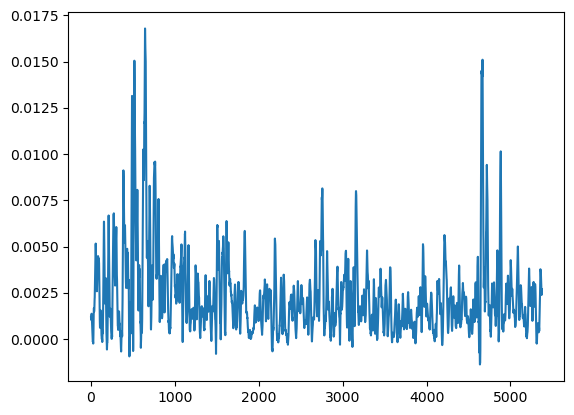

In [60]:
plt.plot(y_past_data[:,0])

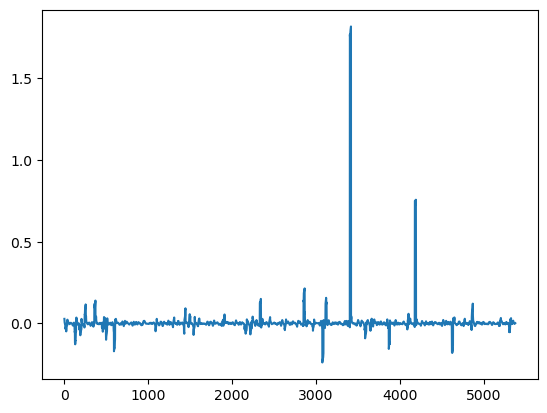

In [61]:
plt.plot(y_past_data[:,1])

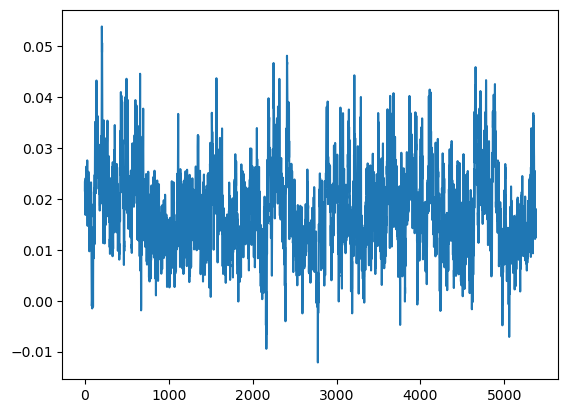

In [62]:
plt.plot(p[:,0])

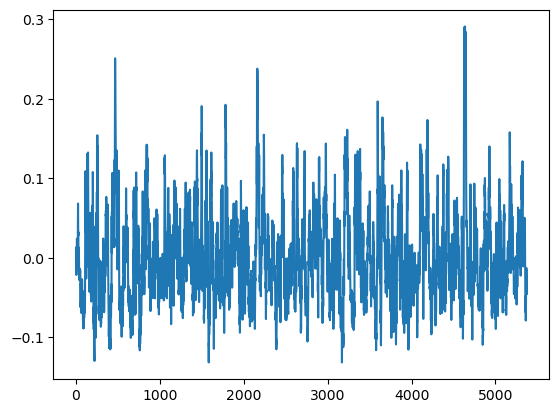

In [63]:
plt.plot(p[:,1])

In [64]:
p.shape

(5376, 2)

In [65]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [66]:
tickDF.shape[0] - p.shape[0]

-55

In [67]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [68]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_future = p[:,0]
p_future_derivation = p[:,1]

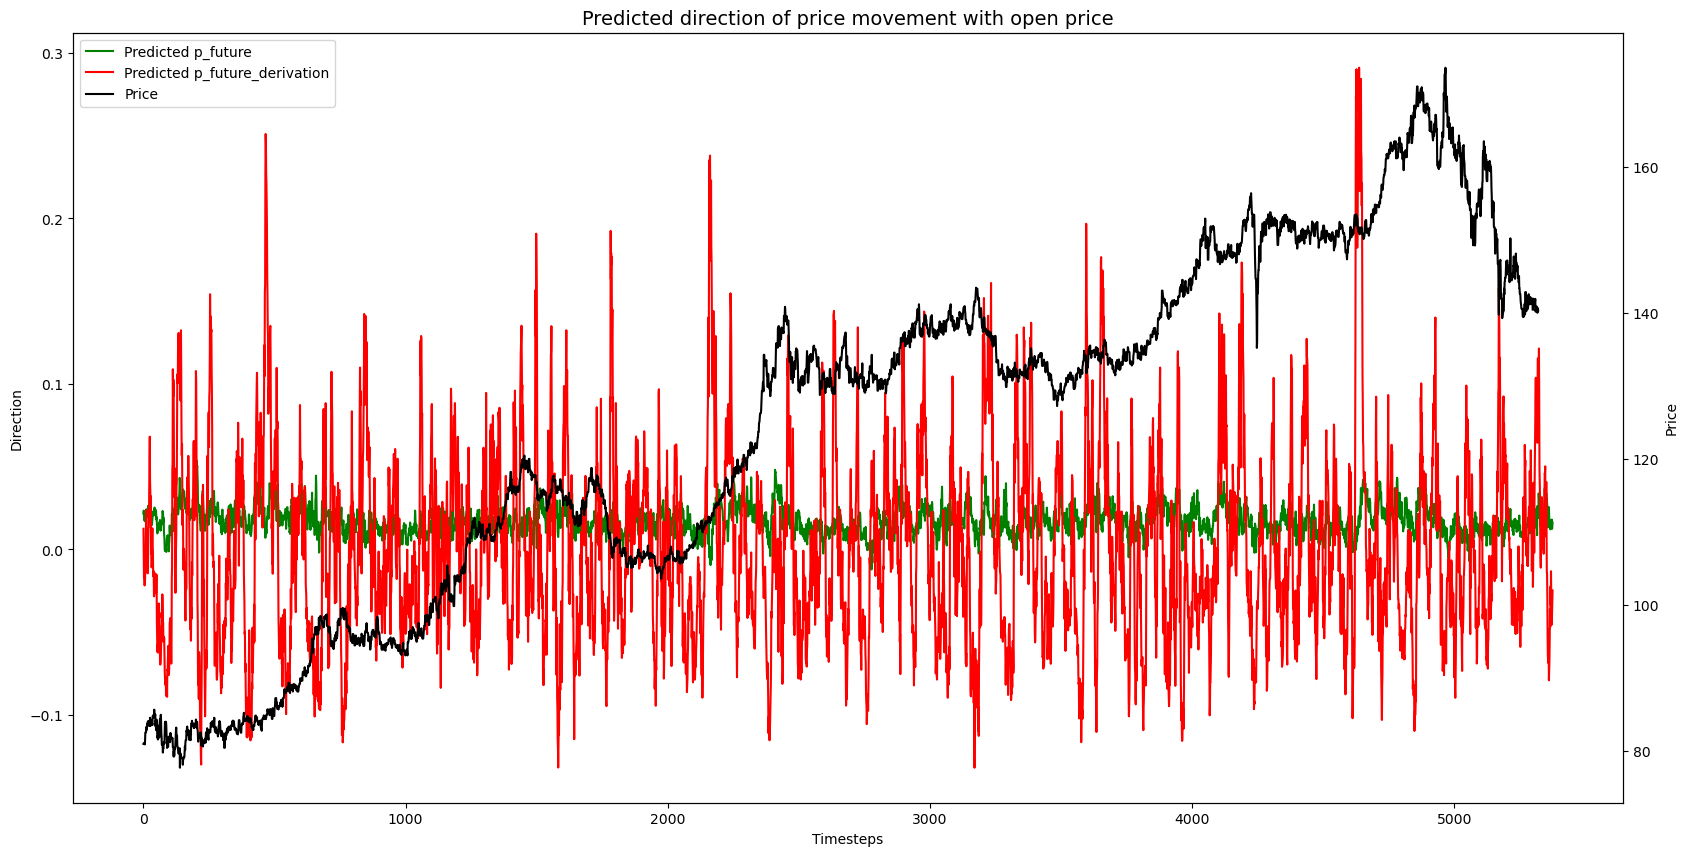

In [69]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_future, color="green", label="Predicted p_future")
_ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [70]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

NameError: name 'p_past_gain' is not defined

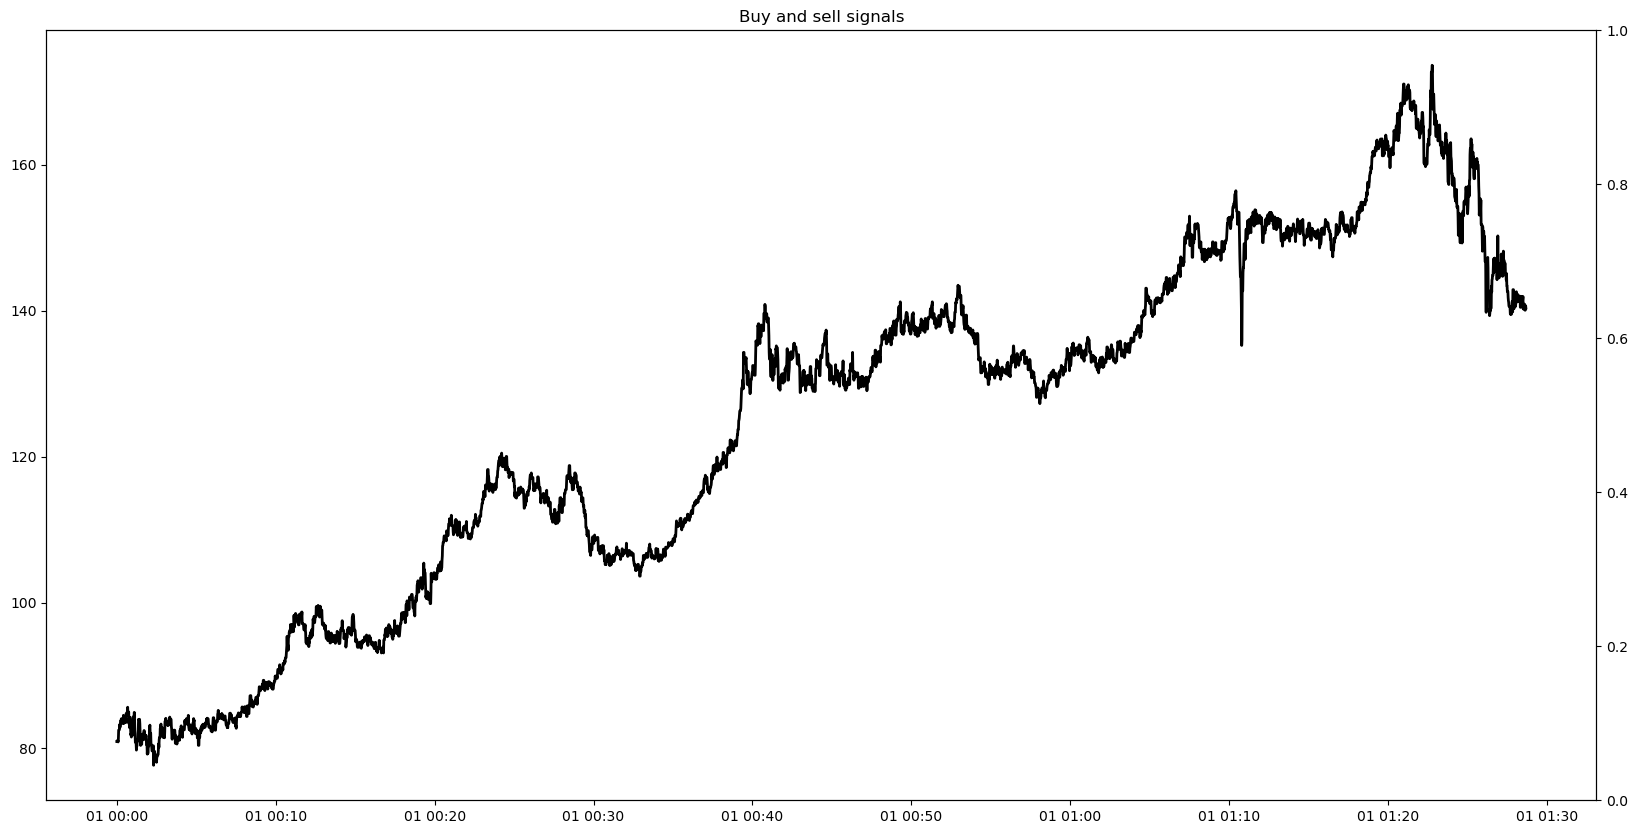

In [71]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [ ]:
!mkdir /content/dataset/etffancy/FPNWithAttentionBigger_3_FutureOnly
!mkdir /content/dataset/etffancy/FPNWithAttentionBigger_3_FutureOnly/test
!mkdir /content/dataset/etffancy/FPNWithAttentionBigger_3_FutureOnly/eval

In [73]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

#fileList = EVAL_FILES
#PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBigger_3_FutureOnly/eval"

fileList = TEST_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBigger_3_FutureOnly/test"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenEval, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/266 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/etffancy/LU1598688189.csv' for index 0
INFO:root:File 'LU1598688189.csv' loaded, 0 left
INFO:root:p.shape: (6144, 2)
INFO:root:File 'LU1598688189.csv' loaded, 0 left
INFO:root:Saved the predicted data.
  0%|█▋                                                                                                                                                                                                                                                                                 